<span>
<b>Authors:</b> 
<a href="http://------">Ornela Danushi </a>
<a href="http://------">Gerlando Gramaglia </a>
<a href="http://------">Domenico Profumo </a><br/>
<b>Python version:</b>  3.x<br/>
</span>

# Import library

In [1]:
import time

import statistics 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import scikitplot as skplt

#confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


import graphviz
from sklearn.tree import export_graphviz

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Load dataset

In [3]:
df = pd.read_csv("dataset/tennis_players.csv", skipinitialspace=True, sep=',', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2120 entries, 0 to 3906
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   2120 non-null   object 
 1   num_matches            2120 non-null   int64  
 2   ratio                  2120 non-null   float64
 3   ratio_2016-2019        2120 non-null   float64
 4   num_matches_2020-2021  2120 non-null   float64
 5   ratio_2020-2021        2120 non-null   float64
 6   hand                   2120 non-null   object 
 7   gender                 2120 non-null   object 
 8   ioc                    2120 non-null   object 
 9   birth                  2120 non-null   float64
 10  ht                     2120 non-null   float64
 11  minutes                2120 non-null   float64
 12  perc_ace               2120 non-null   float64
 13  _1stwon_1stIn          2120 non-null   float64
 14  perc_df                2120 non-null   float64
 15  perc

### Adding player's rank on tennis player's profile

In [4]:
df_rank = pd.read_csv('../Task1/dataset/matches_datacleaning.csv', index_col = 0)
pd.set_option('display.max_columns', None) # to visualize all the columns
df_rank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185750 entries, 0 to 185749
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          185750 non-null  object 
 1   tourney_name        185750 non-null  object 
 2   surface             185588 non-null  object 
 3   draw_size           185750 non-null  float64
 4   tourney_level       185750 non-null  object 
 5   tourney_date        185750 non-null  object 
 6   match_num           185750 non-null  float64
 7   winner_id           185750 non-null  float64
 8   winner_name         185750 non-null  object 
 9   winner_hand         185750 non-null  object 
 10  winner_ioc          185750 non-null  object 
 11  loser_id            185750 non-null  float64
 12  loser_name          185750 non-null  object 
 13  loser_hand          185750 non-null  object 
 14  loser_ioc           185750 non-null  object 
 15  score               185581 non-nul

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
winner_rank = df_rank[['winner_name', 'winner_rank']]
winner_rank.set_axis(['name', 'rank'], axis=1, inplace=True)

loser_rank = df_rank[['loser_name', 'loser_rank']]
loser_rank.set_axis(['name', 'rank'], axis=1, inplace=True)

player_rank = loser_rank.append(winner_rank)
player = df[['name']]
player = pd.merge(player, player_rank, how='left', on='name')
print(player, '\n# of nan:', player['rank'].isna().sum())

                   name    rank
0         AARON ADDISON  1037.0
1         AARON ADDISON  1254.0
2         AARON ADDISON  1255.0
3         AARON ADDISON  1047.0
4         AARON ADDISON  1055.0
...                 ...     ...
266887  ZUZANA ZLOCHOVA   343.0
266888  ZUZANA ZLOCHOVA   335.0
266889  ZUZANA ZLOCHOVA   316.0
266890  ZUZANA ZLOCHOVA   318.0
266891  ZUZANA ZLOCHOVA   316.0

[266892 rows x 2 columns] 
# of nan: 7921


In [6]:
#osserviamo quanti giocatori hanno QUALCHE nan
nan_name = player[player['rank'].isna()]
nan_name['name'].nunique()

790

In [7]:
#prendiamo la media del rank e vediamo se sono rimasti nan (per quelli che avranno nan come rank vuol dire che nel db originale 
# non era presente nessun valore di rank per quel giocatore)
player = player.groupby('name').mean()
player['rank']=player['rank'].round(0)
player['rank'].describe()

count    2079.000000
mean      496.550746
std       333.184933
min         3.000000
25%       243.000000
50%       428.000000
75%       696.500000
max      1908.000000
Name: rank, dtype: float64

In [8]:
#stampo il numero di giocatori che non hanno nemmeno un valore associato al rank
player.isna().sum()

rank    41
dtype: int64

In [9]:
player['rank'].nunique()

947

In [10]:
player.reset_index(inplace = True)
player

name    rank
0                 AARON ADDISON  1131.0
1                   ABBIE MYERS   475.0
2     ABHINAV SANJEEV SHANMUGAM  1233.0
3           ABIGAIL TERE APISAH   422.0
4                ABIR EL FAHIMI     NaN
...                         ...     ...
2115                ZIZOU BERGS   369.0
2116                  ZOE HIVES   319.0
2117                 ZOE KRUGER   750.0
2118              ZSOMBOR PIROS   453.0
2119            ZUZANA ZLOCHOVA   461.0

[2120 rows x 2 columns]

In [11]:
#unisco le due tabelle
df = pd.merge(df, player, how='left', on='name')
df.describe()

num_matches        ratio  ratio_2016-2019  num_matches_2020-2021  \
count  2120.000000  2120.000000      2120.000000            2120.000000   
mean    125.892453    48.145441        47.308430              23.863679   
std      98.550168    12.089893        13.943840              27.020238   
min      11.000000     4.166667         0.000000               0.000000   
25%      34.000000    41.882363        41.078328               0.000000   
50%     100.000000    50.000000        50.000000              11.000000   
75%     208.000000    56.160661        56.352814              46.000000   
max     387.000000    85.250737       100.000000             108.000000   

       ratio_2020-2021        birth           ht      minutes     perc_ace  \
count      2120.000000  2120.000000  2120.000000  2120.000000  2120.000000   
mean         30.619122  1993.779245   179.207650    80.938008     6.727476   
std          26.477303     5.111969     8.134681    16.400592     5.464472   
min           0.000000  1973.000000   155.000000    40.000000     0.000000   
25%           0.000000  1990.000000   173.000000    62.789282     2.390000   
50%          37.066906  1994.000000   178.000000    82.647443     5.705000   
75%          53.077168  1998.000000   185.705882    94.781937     9.792500   
max         100.000000  2006.000000   211.000000   132.724084    40.000000   

       _1stwon_1stIn      perc_df  perc_2ndwon   perc_v_ace    perc_v_df  \
count    2120.000000  2120.000000  2120.000000  2120.000000  2120.000000   
mean       57.332763     7.546972    42.933934     6.764241     6.386939   
std        17.035407     3.591227    12.249540     4.649582     1.990824   
min         3.234105     0.000000     0.000000     0.070000     0.000000   
25%        53.724864     5.220000    40.532500     2.547500     5.420000   
50%        63.567684     6.995000    47.150000     6.165000     6.610000   
75%        68.723107     9.252500    50.000000    10.400000     7.590000   
max        82.386560    29.930000    94.180000    23.170000    17.890000   

       perc_v_1stwon         rank  
count    2120.000000  2079.000000  
mean       53.913325   496.550746  
std        19.585296   333.184933  
min         0.910000     3.000000  
25%        37.820000   243.000000  
50%        64.400000   428.000000  
75%        69.700000   696.500000  
max        81.880000  1908.000000

## Transform categorical features into numerical ones

In [12]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [13]:
#discretize the categorical variables
variables = ['hand', 'gender', 'ioc']
df = discretize_data(df, variables)

In [14]:
#drop the categorical variables since we don't need them anymore 
df.drop(columns=['name','hand', 'gender', 'ioc'], axis=1,inplace=True)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2120 entries, 0 to 2119
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_matches            2120 non-null   int64  
 1   ratio                  2120 non-null   float64
 2   ratio_2016-2019        2120 non-null   float64
 3   num_matches_2020-2021  2120 non-null   float64
 4   ratio_2020-2021        2120 non-null   float64
 5   birth                  2120 non-null   float64
 6   ht                     2120 non-null   float64
 7   minutes                2120 non-null   float64
 8   perc_ace               2120 non-null   float64
 9   _1stwon_1stIn          2120 non-null   float64
 10  perc_df                2120 non-null   float64
 11  perc_2ndwon            2120 non-null   float64
 12  perc_v_ace             2120 non-null   float64
 13  perc_v_df              2120 non-null   float64
 14  perc_v_1stwon          2120 non-null   float64
 15  rank

### Write to csv before classification

In [16]:
df.to_csv('dataset/players_classification.csv')

## Labels

Abbiamo bisogno di capire qual'è il target associato ad ogni insieme per fare il processo di classificazione, un idea potrebbe essere utilizzando un attributo specifico che tiene tratta delle "performance" di ogni giocatore, in modo da poter contraddistingure i giocatori più forti da quelli più deboli. Nel nostro caso ci siamo basati sul rank. 

Nota: questa non è una metrica efficace perchè il vero label del giocatore viene calcolato in base a diversi parametri come ad esempio il punteggio realizzato derivante dalla vincita dei vari tornei ma dato che esso risulta difficile stimarlo utilizzare le informazioni sui rank potrebbe essere la soluzione più efficente 

Quindi possiamo usare i percentili o i quartili per contraddistinguere i due tipi di giocatori, in paticolare consideriamo i giocatori più forti quelli che compaiono nei primi 25% del dataset in ordine di rank decrescente, mentre i rimanenti risultano di basso livello

In [17]:
df.sort_values(by=['rank'])

num_matches      ratio  ratio_2016-2019  num_matches_2020-2021  \
1651          314  83.439490        84.063745                   63.0   
1525          339  85.250737        84.000000                   89.0   
1823          293  74.061433        73.684211                   46.0   
1707          229  82.969432        84.210526                   20.0   
1045          348  69.827586        71.071429                   68.0   
...           ...        ...              ...                    ...   
1812           16   6.250000         6.666667                    1.0   
1874           16  50.000000        50.000000                    0.0   
1907           23  39.130435        39.130435                    0.0   
1937           24   4.166667         4.166667                    0.0   
1982           35  34.285714        25.000000                   19.0   

      ratio_2020-2021   birth          ht     minutes  perc_ace  \
1651        80.952381  1986.0  185.000000  128.560922      7.25   
1525        88.764045  1987.0  188.000000  121.779204     10.34   
1823        76.086957  1991.0  168.000000   89.320671      4.20   
1707        70.000000  1981.0  185.000000  114.490553     17.45   
1045        64.705882  1992.0  184.000000   96.256908     15.73   
...               ...     ...         ...         ...       ...   
1812         0.000000  1993.0  168.000000   59.866667      0.17   
1874         0.000000  1994.0  173.363636   59.750000      0.00   
1907         0.000000  1994.0  172.137868   76.420635      0.75   
1937         0.000000  1981.0  191.142857  104.521739      7.78   
1982        42.105263  2000.0  165.000000   60.239130      0.00   

      _1stwon_1stIn  perc_df  perc_2ndwon  perc_v_ace  perc_v_df  \
1651      72.752799     3.77        57.67       12.01       5.74   
1525      74.216409     4.90        54.86       10.90       5.97   
1823      64.033508     5.47        47.88        4.45       7.11   
1707      78.359655     3.40        58.37       10.95       5.59   
1045      71.493825     7.82        45.45        7.39       8.47   
...             ...      ...          ...         ...        ...   
1812      22.682119     9.77        36.69        1.06       4.09   
1874      13.067151     5.81        13.16        1.44       2.89   
1907      52.136752    11.65        42.18        1.68       8.79   
1937      66.836735    21.81        41.01       12.75      12.05   
1982      21.160651     8.14        26.14        0.07       0.07   

      perc_v_1stwon  rank  hand_num  gender_num  ioc_num  
1651          64.40   3.0         0           1       26  
1525          65.08   3.0         1           1       78  
1823          58.31   3.0         1           0       71  
1707          67.99   4.0         1           1       80  
1045          63.61   7.0         1           0       20  
...             ...   ...       ...         ...      ...  
1812          29.39   NaN         1           0       84  
1874          11.19   NaN         2           0       29  
1907          28.04   NaN         2           0       52  
1937          74.97   NaN         1           1       68  
1982           0.91   NaN         2           0        4  

[2120 rows x 19 columns]

In [18]:
# primo quartile (25%)
quantile_a = df['rank'].quantile(0.25)


In [19]:
blindtest=df[df['rank'].isna()]
del blindtest['rank']

In [20]:
#faccio un drop dei null perchè saranno quelli con cui poi andrò a stimarne il valore
df = df.drop(df[df['rank'].isna()].index)

In [21]:
labels = []
for index, rank in df['rank'].items():
    if rank <= quantile_a:
        labels.append(0)
    else:
        labels.append(1)

In [22]:
class_names = ['high-level', 'low-level']

In [23]:
classes = pd.DataFrame()
classes['labels'] = labels
classes.labels.value_counts(True)

1    0.748437
0    0.251563
Name: labels, dtype: float64

### Prepare dataset (splitting)

In [24]:
del df['rank']

In [25]:
#use stratify because database contain unbalanced label, in this way it's possible to mantain this percentage 
#of label in train and test set 
train_set, test_set, train_label, test_label = train_test_split(df, labels, stratify=labels, test_size=0.25)

In [26]:
np.size(train_label)

1559

# Classification 

Abbiamo usato 9 metodi di classificazione diversi al fine di selezionare il migliore in particolare:

**Tree-based classifiers**
- Decision Tree

**Naive Bayes classifiers**
- Bayesian classifier

**Machine Learning classifiers**
- Neural Network

**Neighbors-based classifiers**
- KNN
- Radius-Neighbors 

**Support Vector Machine**
- SVM

**Rule based classifiers**
- Rule based

**Ensemble Method**
- AdaBoosting
- Random forest

# Function for print report, ROC, confusion matrix

In [27]:
def print_all(models, training , training_pred, test, test_pred, roc="yes"):
    #print all classification report
    print("TRAINING:\n",classification_report(train_label, training_pred, target_names=class_names))
    print("TEST:\n",classification_report(test_label, test_pred, target_names=class_names))
    
    #plot confusion matrix
    cm = confusion_matrix(test_label, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    
    #plot ROC
    if(roc=="yes"):
        test_pred_proba = models.predict_proba(test)
        skplt.metrics.plot_roc(test_label, test_pred_proba)

## Classfication with decision tree

In [28]:
#Library for decision tree
from sklearn import tree
from sklearn.metrics import classification_report
import pydotplus 
from IPython.display import Image

### Grid Search

In [29]:
dt_max_depth = [2,3,5,6,7,10,12,None]
dt_min_samples_split = sp_randint(2, 51)
min_samples_leaf = sp_randint(1, 51)
criterion = ["entropy", "gini"]
splitter = ["best", "random"]
max_features = [None, 2, 3, 4, 5]

dt_param_grid = {
    "max_depth": dt_max_depth,
    "min_samples_split": dt_min_samples_split.rvs(5),
    "min_samples_leaf": min_samples_leaf.rvs(5),
    "criterion": criterion,
    "splitter": splitter,
    "max_features": max_features,
    "class_weight":[None, {0: 0.65, 1: 0.25}]
    }


#define the grid search
dt_grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=dt_param_grid, n_jobs=-1,
                            scoring=make_scorer(f1_score))

In [30]:
best_model = dt_grid.fit(train_set, train_label)
print(dt_grid.best_params_)
train_pred_dt = dt_grid.predict(train_set)
test_pred_dt = dt_grid.predict(test_set)

{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 13, 'min_samples_split': 49, 'splitter': 'random'}


In [31]:
blind_pred_dt = dt_grid.predict(blindtest)

In [32]:
dot_data = export_graphviz(best_model.best_estimator_, out_file=None, 
            filled=True, rounded=True, class_names=['0','1'])

In [33]:
graph = pydotplus.graph_from_dot_data(dot_data)
print(graph.to_string())
#Image(graph.create_png())


digraph Tree {
node [color="black", fontname="helvetica", shape=box, style="filled, rounded"];
edge [fontname="helvetica"];
0 [fillcolor="#7cbeee", label="X[5] <= 1989.494\ngini = 0.376\nsamples = 1559\nvalue = [392, 1167]\nclass = 1"];
1 [fillcolor="#dceefa", label="X[3] <= 1.373\ngini = 0.495\nsamples = 314\nvalue = [142, 172]\nclass = 1"];
0 -> 1  [headlabel="True", labelangle=45, labeldistance="2.5"];
2 [fillcolor="#81c0ee", label="X[0] <= 158.682\ngini = 0.39\nsamples = 177\nvalue = [47, 130]\nclass = 1"];
1 -> 2;
3 [fillcolor="#6db7ec", label="X[0] <= 89.336\ngini = 0.33\nsamples = 163\nvalue = [34, 129]\nclass = 1"];
2 -> 3;
4 [fillcolor="#53aae8", label="X[0] <= 45.004\ngini = 0.207\nsamples = 128\nvalue = [15, 113]\nclass = 1"];
3 -> 4;
5 [fillcolor="#43a2e6", label="X[12] <= 4.268\ngini = 0.088\nsamples = 87\nvalue = [4, 83]\nclass = 1"];
4 -> 5;
6 [fillcolor="#53aae8", label="gini = 0.208\nsamples = 17\nvalue = [2, 15]\nclass = 1"];
5 -> 6;
7 [fillcolor="#3fa0e6", label="X[2

### Evaluation of the decision tree

TRAINING:
               precision    recall  f1-score   support

  high-level       0.80      0.82      0.81       392
   low-level       0.94      0.93      0.94      1167

    accuracy                           0.90      1559
   macro avg       0.87      0.87      0.87      1559
weighted avg       0.90      0.90      0.90      1559

TEST:
               precision    recall  f1-score   support

  high-level       0.79      0.77      0.78       131
   low-level       0.92      0.93      0.93       389

    accuracy                           0.89       520
   macro avg       0.86      0.85      0.85       520
weighted avg       0.89      0.89      0.89       520



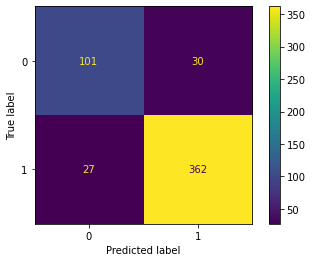

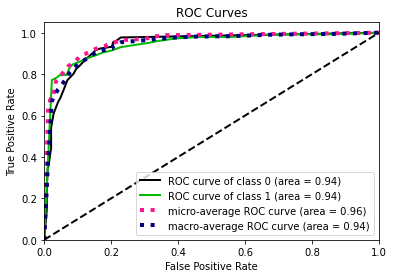

In [34]:
print_all(dt_grid,train_set,train_pred_dt,test_set,test_pred_dt)

## Bayesian classifier

In [35]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [36]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)
train_pred_gnb = gnb.predict(train_set)
#predict on the test set
test_pred_gnb = gnb.predict(test_set)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       0.64      0.91      0.75       392
   low-level       0.96      0.83      0.89      1167

    accuracy                           0.85      1559
   macro avg       0.80      0.87      0.82      1559
weighted avg       0.88      0.85      0.86      1559

TEST:
               precision    recall  f1-score   support

  high-level       0.66      0.84      0.74       131
   low-level       0.94      0.85      0.89       389

    accuracy                           0.85       520
   macro avg       0.80      0.85      0.82       520
weighted avg       0.87      0.85      0.86       520



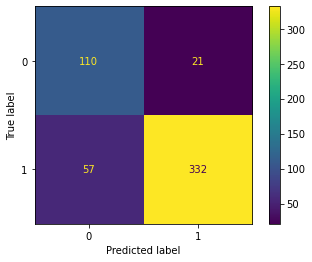

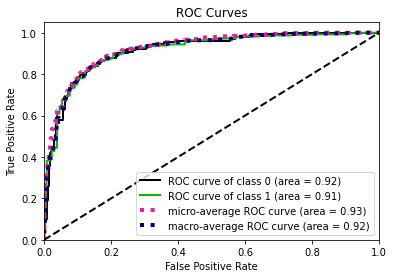

In [37]:
print_all(gnb,train_set,train_pred_gnb,test_set,test_pred_gnb)

## Neural Network

In [38]:
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Init Plugin
Init Graph Optimizer
Init Kernel


In [61]:
def create_model(n_input, n_neurons1, activation1, optimizer, activation_out, loss): 
    # create model
    model = Sequential()
    model.add(Dense(n_neurons1, kernel_initializer='uniform', input_dim=n_input, activation=activation1)) 
    model.add(Dense(1,  kernel_initializer='uniform', activation=activation_out))
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return model

In [62]:
grid_param = {
    "n_input": [len(df.columns)],
    "n_neurons1":[5,7,20,12],
    "activation1":["relu","sigmoidal","tanh"],
    "optimizer": ['adam'],
    "activation_out":["linear"],
    "loss":["mean_squared_error","binary_crossentropy"]
}

nn = KerasClassifier(build_fn=create_model, epochs=150, batch_size=32)
nn_grid = GridSearchCV(nn, param_grid=grid_param, n_jobs=-1, cv=8, scoring=make_scorer(f1_score))

In [63]:
start = time.time()
best_model = nn_grid.fit(train_set, train_label)
print(nn_grid.best_params_)
train_pred_nn = nn_grid.predict(train_set)
test_pred_nn = nn_grid.predict(test_set)
print('Time taken for fit: {} sec\n'.format(time.time() - start))

2022-01-05 11:00:39.043940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:00:39.053559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:00:39.054666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:00:39.057149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:00:39.070090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:00:39.073172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:00:39.073906: I tensorflow/core/grappler/optimizers/cust

Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
 1/43 [..............................] - ETA: 43s - loss: 0.7184 - accuracy: 0.2812Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
 1/43 [..............................] - ETA: 43s - loss: 0.7458 - accuracy: 0.2500Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
 1/43 [..............................] - ETA: 43s - loss: 0.8743 - accuracy: 0.1250Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1

43/43 [==============================] - 1s 18ms/step - loss: 0.2205 - accuracy: 0.7273
Epoch 7/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1931 - accuracy: 0.7375
Epoch 8/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1994 - accuracy: 0.7449
Epoch 8/150
43/43 [==============================] - 1s 15ms/step - loss: 0.1916 - accuracy: 0.7449
Epoch 9/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1890 - accuracy: 0.7456
Epoch 9/150
43/43 [==============================] - 1s 15ms/step - loss: 0.1789 - accuracy: 0.7515
Epoch 10/150
43/43 [==============================] - 1s 17ms/step - loss: 0.1706 - accuracy: 0.7463
Epoch 11/150
43/43 [==============================] - 1s 17ms/step - loss: 0.1868 - accuracy: 0.7463
Epoch 11/150
43/43 [==============================] - 1s 15ms/step - loss: 0.1433 - accuracy: 0.7698
Epoch 12/150
43/43 [==============================] - 1s 18ms/step - loss: 0.1580 - accuracy: 0.7581
Epoch 12

43/43 [==============================] - 1s 19ms/step - loss: 0.1236 - accuracy: 0.8218
Epoch 14/150
43/43 [==============================] - 1s 17ms/step - loss: 0.1340 - accuracy: 0.7956
Epoch 14/150
43/43 [==============================] - 1s 17ms/step - loss: 0.1299 - accuracy: 0.7999
Epoch 15/150
43/43 [==============================] - 1s 18ms/step - loss: 0.1258 - accuracy: 0.8234
Epoch 15/150
43/43 [==============================] - 1s 14ms/step - loss: 0.1195 - accuracy: 0.8344
Epoch 16/150
43/43 [==============================] - 1s 16ms/step - loss: 0.1158 - accuracy: 0.8504
Epoch 17/150
43/43 [==============================] - 1s 19ms/step - loss: 0.1376 - accuracy: 0.7837
Epoch 17/150
43/43 [==============================] - 1s 16ms/step - loss: 0.1118 - accuracy: 0.8600
Epoch 17/150
43/43 [==============================] - 1s 19ms/step - loss: 0.1127 - accuracy: 0.8541
Epoch 18/150
43/43 [==============================] - 1s 17ms/step - loss: 0.1078 - accuracy: 0.8644
Epo

43/43 [==============================] - 1s 20ms/step - loss: 0.1066 - accuracy: 0.8666
Epoch 19/150
43/43 [==============================] - 1s 18ms/step - loss: 0.1034 - accuracy: 0.8746
Epoch 20/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0958 - accuracy: 0.8827
Epoch 20/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0955 - accuracy: 0.8864
Epoch 22/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0999 - accuracy: 0.8798
Epoch 21/150
43/43 [==============================] - 1s 16ms/step - loss: 0.1030 - accuracy: 0.8732
Epoch 21/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0986 - accuracy: 0.8849
Epoch 22/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0924 - accuracy: 0.8864
Epoch 23/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0920 - accuracy: 0.8937
Epoch 24/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1042 - accuracy: 0.8688
Epo

43/43 [==============================] - 1s 15ms/step - loss: 0.0885 - accuracy: 0.8966
Epoch 26/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0953 - accuracy: 0.8864
Epoch 25/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0921 - accuracy: 0.8915
Epoch 25/150
43/43 [==============================] - 1s 15ms/step - loss: 0.1001 - accuracy: 0.8739
Epoch 26/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0942 - accuracy: 0.8834
Epoch 27/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0914 - accuracy: 0.8900
Epoch 28/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0912 - accuracy: 0.8938
Epoch 28/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0904 - accuracy: 0.8952
Epoch 30/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0894 - accuracy: 0.9018
Epoch 31/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0845 - accuracy: 0.9113
Epo

43/43 [==============================] - 1s 16ms/step - loss: 0.0814 - accuracy: 0.9135
Epoch 40/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0840 - accuracy: 0.9136
Epoch 39/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0838 - accuracy: 0.9113
Epoch 39/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0801 - accuracy: 0.9179
Epoch 41/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0812 - accuracy: 0.9128
Epoch 42/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0823 - accuracy: 0.9135
Epoch 43/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0819 - accuracy: 0.9164
Epoch 42/150
23/43 [===============>..............] - ETA: 0s - loss: 0.0822 - accuracy: 0.9130Epoch 43/150


43/43 [==============================] - 1s 16ms/step - loss: 0.0811 - accuracy: 0.9172
Epoch 45/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0810 - accuracy: 0.9164
Epoch 46/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0822 - accuracy: 0.9136
Epoch 45/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0799 - accuracy: 0.9186
Epoch 47/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0821 - accuracy: 0.9165
Epoch 47/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0810 - accuracy: 0.9194
Epoch 48/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0797 - accuracy: 0.9164
Epoch 48/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0788 - accuracy: 0.9179
Epoch 49/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0792 - accuracy: 0.9157
Epoch 48/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0785 - accuracy: 0.9208
Epo

43/43 [==============================] - 1s 14ms/step - loss: 0.0779 - accuracy: 0.9172
Epoch 56/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0788 - accuracy: 0.9208
Epoch 57/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0791 - accuracy: 0.9179
Epoch 57/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0788 - accuracy: 0.9164
Epoch 59/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0770 - accuracy: 0.9216
Epoch 59/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0786 - accuracy: 0.9216
Epoch 60/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0788 - accuracy: 0.9164
Epoch 62/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0780 - accuracy: 0.9238
Epoch 61/150
20/43 [============>.................] - ETA: 0s - loss: 0.0818 - accuracy: 0.9172Epoch 62/150


43/43 [==============================] - 1s 16ms/step - loss: 0.0783 - accuracy: 0.9245
Epoch 62/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0768 - accuracy: 0.9252
Epoch 63/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0774 - accuracy: 0.9260
Epoch 64/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0782 - accuracy: 0.9230
Epoch 63/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0772 - accuracy: 0.9282
Epoch 65/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0778 - accuracy: 0.9238
Epoch 63/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0789 - accuracy: 0.9186
Epoch 64/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0780 - accuracy: 0.9194
Epoch 66/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0776 - accuracy: 0.9245
Epoch 65/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0785 - accuracy: 0.9238
Epo

43/43 [==============================] - 1s 20ms/step - loss: 0.0781 - accuracy: 0.9238
Epoch 70/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0774 - accuracy: 0.9238
Epoch 70/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0771 - accuracy: 0.9282
Epoch 70/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0773 - accuracy: 0.9260
Epoch 71/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0769 - accuracy: 0.9311
Epoch 73/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0777 - accuracy: 0.9194
Epoch 72/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0782 - accuracy: 0.9209
Epoch 73/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0773 - accuracy: 0.9282
Epoch 75/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0768 - accuracy: 0.9282
Epoch 75/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0766 - accuracy: 0.9267
Epo

43/43 [==============================] - 1s 18ms/step - loss: 0.0778 - accuracy: 0.9245
Epoch 82/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0761 - accuracy: 0.9289
Epoch 83/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0754 - accuracy: 0.9252
Epoch 84/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0771 - accuracy: 0.9201
Epoch 84/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0764 - accuracy: 0.9245
Epoch 86/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0771 - accuracy: 0.9260
Epoch 85/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0750 - accuracy: 0.9245
Epoch 87/150
39/43 [==========================>...] - ETA: 0s - loss: 0.0772 - accuracy: 0.9295Epoch 88/150


43/43 [==============================] - 1s 16ms/step - loss: 0.0765 - accuracy: 0.9260
Epoch 89/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0758 - accuracy: 0.9267
Epoch 89/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0763 - accuracy: 0.9282
Epoch 88/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0758 - accuracy: 0.9289
Epoch 88/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0752 - accuracy: 0.9289
Epoch 89/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0763 - accuracy: 0.9282
Epoch 89/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0755 - accuracy: 0.9311
Epoch 91/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0756 - accuracy: 0.9274
Epoch 92/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0774 - accuracy: 0.9231
Epoch 93/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0741 - accuracy: 0.9252
Epo

43/43 [==============================] - 1s 16ms/step - loss: 0.0751 - accuracy: 0.9260
Epoch 95/150
43/43 [==============================] - 0s 11ms/step - loss: 0.0755 - accuracy: 0.9289
Epoch 96/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0749 - accuracy: 0.9311
Epoch 96/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0766 - accuracy: 0.9223
Epoch 95/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0749 - accuracy: 0.9296
Epoch 97/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0768 - accuracy: 0.9253
Epoch 96/150
43/43 [==============================] - 0s 12ms/step - loss: 0.0764 - accuracy: 0.9260
Epoch 98/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0740 - accuracy: 0.9274
Epoch 99/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0757 - accuracy: 0.9289
Epoch 100/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0768 - accuracy: 0.9245
Ep

43/43 [==============================] - 1s 17ms/step - loss: 0.0761 - accuracy: 0.9275
Epoch 105/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0755 - accuracy: 0.9296
Epoch 108/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0759 - accuracy: 0.9267
Epoch 107/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0760 - accuracy: 0.9260
Epoch 108/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0755 - accuracy: 0.9296
Epoch 108/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0748 - accuracy: 0.9289
Epoch 109/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0762 - accuracy: 0.9253
Epoch 109/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0751 - accuracy: 0.9282
Epoch 110/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0759 - accuracy: 0.9275
Epoch 111/150
 5/43 [==>...........................] - ETA: 0s - loss: 0.0789 - accuracy: 0.9187

43/43 [==============================] - 1s 15ms/step - loss: 0.0745 - accuracy: 0.9296
Epoch 114/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0754 - accuracy: 0.9282
Epoch 112/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0750 - accuracy: 0.9289
Epoch 115/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0758 - accuracy: 0.9260
Epoch 115/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0752 - accuracy: 0.9289
Epoch 114/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0769 - accuracy: 0.9245
Epoch 116/150
 9/43 [=====>........................] - ETA: 0s - loss: 0.0755 - accuracy: 0.9340Epoch 117/150


43/43 [==============================] - 1s 15ms/step - loss: 0.0748 - accuracy: 0.9333
Epoch 119/150
43/43 [==============================] - 1s 12ms/step - loss: 0.0748 - accuracy: 0.9311
Epoch 119/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0733 - accuracy: 0.9304
Epoch 121/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0753 - accuracy: 0.9289
Epoch 120/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0755 - accuracy: 0.9267
Epoch 121/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0750 - accuracy: 0.9274
Epoch 123/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0745 - accuracy: 0.9311
Epoch 123/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0754 - accuracy: 0.9289
Epoch 122/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0750 - accuracy: 0.9333
Epoch 123/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0761 - accuracy: 0

43/43 [==============================] - 1s 16ms/step - loss: 0.0754 - accuracy: 0.9289
Epoch 129/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0742 - accuracy: 0.9296
Epoch 128/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0747 - accuracy: 0.9296
Epoch 130/150
43/43 [==============================] - 1s 12ms/step - loss: 0.0730 - accuracy: 0.9326
Epoch 133/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0748 - accuracy: 0.9311
Epoch 132/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0748 - accuracy: 0.9289
Epoch 131/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0756 - accuracy: 0.9260
Epoch 131/150
 6/43 [===>..........................] - ETA: 0s - loss: 0.0772 - accuracy: 0.9375Epoch 133/150


43/43 [==============================] - 1s 17ms/step - loss: 0.0747 - accuracy: 0.9296
Epoch 132/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0755 - accuracy: 0.9260
Epoch 132/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0750 - accuracy: 0.9296
Epoch 132/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0747 - accuracy: 0.9304
Epoch 134/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0749 - accuracy: 0.9304
Epoch 132/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0759 - accuracy: 0.9260
Epoch 134/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0747 - accuracy: 0.9326
Epoch 135/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0729 - accuracy: 0.9296
Epoch 140/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0747 - accuracy: 0.9311


43/43 [==============================] - 1s 13ms/step - loss: 0.0731 - accuracy: 0.9289
Epoch 141/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0742 - accuracy: 0.9348
Epoch 138/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0741 - accuracy: 0.9289
Epoch 139/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0752 - accuracy: 0.9260
Epoch 139/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0748 - accuracy: 0.9311
Epoch 138/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0748 - accuracy: 0.9274
Epoch 141/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0745 - accuracy: 0.9296
Epoch 142/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0748 - accuracy: 0.9304
Epoch 144/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0740 - accuracy: 0.9326
Epoch 143/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0754 - accuracy: 0

43/43 [==============================] - 1s 16ms/step - loss: 0.0741 - accuracy: 0.9333
Epoch 144/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0752 - accuracy: 0.9267
Epoch 145/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0744 - accuracy: 0.9304
Epoch 148/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0757 - accuracy: 0.9289
Epoch 148/150
11/43 [======>.......................] - ETA: 0s - loss: 0.0688 - accuracy: 0.9432

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:02:25.573474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 18ms/step - loss: 0.0749 - accuracy: 0.9289
Epoch 149/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0749 - accuracy: 0.9260
Epoch 150/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0753 - accuracy: 0.9275
Epoch 149/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0742 - accuracy: 0.9252
Epoch 150/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0746 - accuracy: 0.9304
Epoch 150/150
41/43 [===========================>..] - ETA: 0s - loss: 0.0741 - accuracy: 0.9322

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")

33/43 [======================>.......] - ETA: 0s - loss: 0.0754 - accuracy: 0.9290

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:02:27.173739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 14ms/step - loss: 0.0745 - accuracy: 0.9304
Epoch 150/150
 5/43 [==>...........................] - ETA: 0s - loss: 0.0739 - accuracy: 0.9438

2022-01-05 11:02:27.275045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:02:27.275125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:02:27.470668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Pl

Epoch 150/150
 1/43 [..............................] - ETA: 0s - loss: 0.0924 - accuracy: 0.8750

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")

15/43 [=========>....................] - ETA: 0s - loss: 0.0669 - accuracy: 0.9438

2022-01-05 11:02:28.093950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:02:28.099016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:02:28.287192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 14ms/step - loss: 0.6568 - accuracy: 0.2507
Epoch 2/150
 8/43 [====>.........................] - ETA: 0s - loss: 0.5157 - accuracy: 0.2070

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:02:28.711522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:02:28.771520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


28/43 [==================>...........] - ETA: 0s - loss: 0.4218 - accuracy: 0.2366

2022-01-05 11:02:28.807668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 14ms/step - loss: 0.6498 - accuracy: 0.2434
Epoch 2/150
43/43 [==============================] - 1s 20ms/step - loss: 0.2465 - accuracy: 0.6386
Epoch 4/150
43/43 [==============================] - 1s 16ms/step - loss: 0.4412 - accuracy: 0.2478
Epoch 3/150
43/43 [==============================] - 1s 14ms/step - loss: 0.2728 - accuracy: 0.4619
Epoch 4/150
43/43 [==============================] - 1s 22ms/step - loss: 0.2385 - accuracy: 0.6745
Epoch 5/150
43/43 [==============================] - 4s 18ms/step - loss: 0.7014 - accuracy: 0.2515
Epoch 2/150
11/43 [======>.......................] - ETA: 0s - loss: 0.2064 - accuracy: 0.7386

2022-01-05 11:02:32.560954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 21ms/step - loss: 0.5283 - accuracy: 0.2515
Epoch 7/150
43/43 [==============================] - 1s 24ms/step - loss: 0.2168 - accuracy: 0.7251
Epoch 7/150
43/43 [==============================] - 1s 20ms/step - loss: 0.2716 - accuracy: 0.4743
Epoch 4/150
43/43 [==============================] - 1s 21ms/step - loss: 0.2061 - accuracy: 0.7331
Epoch 8/150
43/43 [==============================] - 1s 21ms/step - loss: 0.2332 - accuracy: 0.6943
Epoch 5/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1847 - accuracy: 0.7412
Epoch 10/150
43/43 [==============================] - 1s 22ms/step - loss: 0.2116 - accuracy: 0.7309
Epoch 7/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1272 - accuracy: 0.8079
Epoch 8/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1912 - accuracy: 0.7427
Epoch 14/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1205 - accuracy: 0.8299
Epoch 9/15

43/43 [==============================] - 1s 25ms/step - loss: 0.1060 - accuracy: 0.8702
Epoch 16/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1690 - accuracy: 0.7478
Epoch 18/150
43/43 [==============================] - 1s 22ms/step - loss: 0.2251 - accuracy: 0.7128
Epoch 17/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1309 - accuracy: 0.7999
Epoch 15/150
 8/43 [====>.........................] - ETA: 0s - loss: 0.1409 - accuracy: 0.8008Epoch 20/150


43/43 [==============================] - 1s 22ms/step - loss: 0.1169 - accuracy: 0.8482
Epoch 17/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1038 - accuracy: 0.8673
Epoch 21/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0934 - accuracy: 0.8834
Epoch 21/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1016 - accuracy: 0.8768
Epoch 22/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0876 - accuracy: 0.8952
Epoch 20/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1043 - accuracy: 0.8739
Epoch 24/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0896 - accuracy: 0.8981
Epoch 25/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0889 - accuracy: 0.8944
Epoch 24/150
43/43 [==============================] - 1s 17ms/step - loss: 0.1258 - accuracy: 0.8242
Epoch 12/150
 5/43 [==>...........................] - ETA: 0s - loss: 0.1091 - accuracy: 0.8500Epoch 25/

43/43 [==============================] - 1s 15ms/step - loss: 0.1060 - accuracy: 0.8666
Epoch 27/150
43/43 [==============================] - 1s 13ms/step - loss: 0.1015 - accuracy: 0.8739
Epoch 25/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0928 - accuracy: 0.8790
Epoch 31/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0821 - accuracy: 0.9106
Epoch 18/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0915 - accuracy: 0.8849
Epoch 27/150


43/43 [==============================] - 0s 11ms/step - loss: 0.0844 - accuracy: 0.9098
Epoch 31/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0968 - accuracy: 0.8835
Epoch 19/150
43/43 [==============================] - 1s 12ms/step - loss: 0.0948 - accuracy: 0.8901
Epoch 20/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0945 - accuracy: 0.8893
Epoch 33/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0919 - accuracy: 0.8960
Epoch 35/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0935 - accuracy: 0.8886
Epoch 31/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0907 - accuracy: 0.8916
Epoch 32/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0916 - accuracy: 0.8908
Epoch 33/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0813 - accuracy: 0.9164
Epoch 38/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0849 - accuracy: 0.9076
Epo

43/43 [==============================] - 1s 23ms/step - loss: 0.0868 - accuracy: 0.9084
Epoch 41/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0799 - accuracy: 0.9179
Epoch 44/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0814 - accuracy: 0.9150
Epoch 43/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0767 - accuracy: 0.9194
Epoch 48/150
30/43 [===================>..........] - ETA: 0s - loss: 0.0783 - accuracy: 0.9260Epoch 49/150


43/43 [==============================] - 1s 28ms/step - loss: 0.0768 - accuracy: 0.9194
Epoch 50/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0817 - accuracy: 0.9187
Epoch 37/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0778 - accuracy: 0.9186
Epoch 41/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0772 - accuracy: 0.9216
Epoch 55/150


43/43 [==============================] - 1s 25ms/step - loss: 0.0799 - accuracy: 0.9186
Epoch 57/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0777 - accuracy: 0.9252
Epoch 57/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0788 - accuracy: 0.9216
Epoch 58/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0777 - accuracy: 0.9252
Epoch 58/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0771 - accuracy: 0.9208
Epoch 55/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0784 - accuracy: 0.9223
Epoch 60/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0752 - accuracy: 0.9260
Epoch 61/150
24/43 [===============>..............] - ETA: 0s - loss: 0.0800 - accuracy: 0.9206Epoch 48/150


43/43 [==============================] - 1s 23ms/step - loss: 0.0783 - accuracy: 0.9223
Epoch 58/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0777 - accuracy: 0.9238
Epoch 61/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0761 - accuracy: 0.9223
Epoch 66/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0800 - accuracy: 0.9164
Epoch 62/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0788 - accuracy: 0.9216
Epoch 63/150
29/43 [===================>..........] - ETA: 0s - loss: 0.0761 - accuracy: 0.9246Epoch 54/150


43/43 [==============================] - 1s 19ms/step - loss: 0.0773 - accuracy: 0.9238
Epoch 68/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0766 - accuracy: 0.9245
Epoch 69/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0760 - accuracy: 0.9238
Epoch 65/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0795 - accuracy: 0.9194
Epoch 65/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0782 - accuracy: 0.9186
Epoch 70/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0743 - accuracy: 0.9267
Epoch 71/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0744 - accuracy: 0.9274
Epoch 58/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0757 - accuracy: 0.9260
Epoch 71/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0768 - accuracy: 0.9245
Epoch 69/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0763 - accuracy: 0.9252
Epo

43/43 [==============================] - 1s 25ms/step - loss: 0.0768 - accuracy: 0.9245
Epoch 71/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0788 - accuracy: 0.9208
Epoch 71/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0776 - accuracy: 0.9230
Epoch 75/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0758 - accuracy: 0.9223
Epoch 77/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0788 - accuracy: 0.9238
Epoch 73/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0765 - accuracy: 0.9252
Epoch 74/150
13/43 [========>.....................] - ETA: 0s - loss: 0.0835 - accuracy: 0.9111Epoch 79/150


43/43 [==============================] - 1s 23ms/step - loss: 0.0753 - accuracy: 0.9340
Epoch 81/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0760 - accuracy: 0.9267
Epoch 78/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0779 - accuracy: 0.9252
Epoch 79/150
14/43 [========>.....................] - ETA: 0s - loss: 0.0772 - accuracy: 0.9286Epoch 86/150


43/43 [==============================] - 1s 23ms/step - loss: 0.0770 - accuracy: 0.9260
Epoch 82/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0757 - accuracy: 0.9289
Epoch 82/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0737 - accuracy: 0.9304
Epoch 87/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0777 - accuracy: 0.9238
Epoch 83/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0735 - accuracy: 0.9274
Epoch 88/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0774 - accuracy: 0.9267
Epoch 84/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0754 - accuracy: 0.9304
Epoch 88/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0757 - accuracy: 0.9282
Epoch 85/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0773 - accuracy: 0.9245
Epoch 87/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0761 - accuracy: 0.9267
Epo

43/43 [==============================] - 1s 25ms/step - loss: 0.0733 - accuracy: 0.9289
Epoch 99/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0747 - accuracy: 0.9296
Epoch 103/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0768 - accuracy: 0.9252
Epoch 99/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0757 - accuracy: 0.9245
Epoch 89/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0760 - accuracy: 0.9260


43/43 [==============================] - 1s 24ms/step - loss: 0.0763 - accuracy: 0.9318
Epoch 104/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0759 - accuracy: 0.9282
Epoch 92/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0751 - accuracy: 0.9289
Epoch 106/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0762 - accuracy: 0.9282
Epoch 104/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0759 - accuracy: 0.9245
Epoch 109/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0744 - accuracy: 0.9304
Epoch 108/150
36/43 [========================>.....] - ETA: 0s - loss: 0.0769 - accuracy: 0.9245Epoch 106/150


43/43 [==============================] - 1s 24ms/step - loss: 0.0747 - accuracy: 0.9304
Epoch 111/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0747 - accuracy: 0.9252
Epoch 112/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0767 - accuracy: 0.9231
Epoch 98/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0743 - accuracy: 0.9296
Epoch 109/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0758 - accuracy: 0.9311
Epoch 114/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0756 - accuracy: 0.9289
Epoch 100/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0745 - accuracy: 0.9311
Epoch 115/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0752 - accuracy: 0.9289
Epoch 111/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0748 - accuracy: 0.9326
Epoch 113/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0753 - accuracy: 0.

43/43 [==============================] - 1s 23ms/step - loss: 0.0744 - accuracy: 0.9304
Epoch 124/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0759 - accuracy: 0.9304
Epoch 120/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0761 - accuracy: 0.9267
Epoch 125/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0754 - accuracy: 0.9274
Epoch 124/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0742 - accuracy: 0.9318
Epoch 122/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0741 - accuracy: 0.9340
Epoch 122/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0755 - accuracy: 0.9282
Epoch 113/150
16/43 [==========>...................] - ETA: 0s - loss: 0.0741 - accuracy: 0.9141Epoch 126/150


43/43 [==============================] - 1s 22ms/step - loss: 0.0742 - accuracy: 0.9304
Epoch 129/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0740 - accuracy: 0.9326
Epoch 127/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0754 - accuracy: 0.9282
Epoch 129/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0750 - accuracy: 0.9296
Epoch 116/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0749 - accuracy: 0.9296
Epoch 131/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0743 - accuracy: 0.9311
Epoch 133/150
27/43 [=================>............] - ETA: 0s - loss: 0.0743 - accuracy: 0.9317Epoch 130/150


43/43 [==============================] - 1s 22ms/step - loss: 0.0729 - accuracy: 0.9318
Epoch 134/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0750 - accuracy: 0.9282
Epoch 133/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0751 - accuracy: 0.9289
Epoch 122/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0739 - accuracy: 0.9340
Epoch 136/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0740 - accuracy: 0.9296
Epoch 138/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0729 - accuracy: 0.9296
Epoch 138/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0752 - accuracy: 0.9245
Epoch 124/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0738 - accuracy: 0.9348
Epoch 137/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0743 - accuracy: 0.9282
Epoch 135/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0743 - accuracy: 0

43/43 [==============================] - 1s 28ms/step - loss: 0.0752 - accuracy: 0.9275
Epoch 126/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0742 - accuracy: 0.9311
Epoch 142/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0723 - accuracy: 0.9333
Epoch 142/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0742 - accuracy: 0.9348
Epoch 141/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0749 - accuracy: 0.9318
Epoch 143/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0752 - accuracy: 0.9252
Epoch 144/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0741 - accuracy: 0.9304
Epoch 150/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0743 - accuracy: 0.9333
Epoch 145/150
15/43 [=========>....................] - ETA: 0s - loss: 0.0714 - accuracy: 0.9458

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


41/43 [===========================>..] - ETA: 0s - loss: 0.0739 - accuracy: 0.9322

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:04:54.407992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


13/43 [========>.....................] - ETA: 0s - loss: 0.0749 - accuracy: 0.9279

2022-01-05 11:04:54.763154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


33/43 [======================>.......] - ETA: 0s - loss: 0.0750 - accuracy: 0.9318

2022-01-05 11:04:55.076474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 21ms/step - loss: 0.0738 - accuracy: 0.9326


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 147/150
31/43 [====================>.........] - ETA: 0s - loss: 0.0705 - accuracy: 0.9435

2022-01-05 11:04:55.814894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/43 [..............................] - ETA: 0s - loss: 0.0835 - accuracy: 0.9375

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/43 [========================>.....] - ETA: 0s - loss: 0.0722 - accuracy: 0.9341

2022-01-05 11:04:56.386034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:04:56.497376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 20ms/step - loss: 0.0750 - accuracy: 0.9275
Epoch 139/150
 9/43 [=====>........................] - ETA: 0s - loss: 0.0845 - accuracy: 0.9167

2022-01-05 11:04:56.662624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0749 - accuracy: 0.9289
Epoch 1/150
12/43 [=======>......................] - ETA: 0s - loss: 0.0794 - accuracy: 0.9141

2022-01-05 11:04:57.153589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 15ms/step - loss: 0.0749 - accuracy: 0.9289
Epoch 140/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0749 - accuracy: 0.9274
Epoch 2/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0751 - accuracy: 0.9260
Epoch 141/150
24/43 [===============>..............] - ETA: 0s - loss: 0.0758 - accuracy: 0.9245

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 4/43 [=>............................] - ETA: 0s - loss: 0.1918 - accuracy: 0.7656

2022-01-05 11:04:58.108149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/43 [===========================>..] - ETA: 0s - loss: 0.2638 - accuracy: 0.5595

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:04:58.580201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 16ms/step - loss: 0.2619 - accuracy: 0.5667
Epoch 3/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0750 - accuracy: 0.9267
Epoch 142/150
34/43 [======================>.......] - ETA: 0s - loss: 0.2838 - accuracy: 0.4651

2022-01-05 11:04:58.714905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 14ms/step - loss: 0.2759 - accuracy: 0.5103
Epoch 3/150
41/43 [===========================>..] - ETA: 0s - loss: 0.2264 - accuracy: 0.7165

2022-01-05 11:04:59.010726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 14ms/step - loss: 0.0748 - accuracy: 0.9297
Epoch 143/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1794 - accuracy: 0.7507
Epoch 3/150
38/43 [=========================>....] - ETA: 0s - loss: 0.1758 - accuracy: 0.7401

2022-01-05 11:05:01.926318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 18ms/step - loss: 0.0749 - accuracy: 0.9267
Epoch 147/150
17/43 [==========>...................] - ETA: 0s - loss: 0.1644 - accuracy: 0.7279

2022-01-05 11:05:02.484155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/150
43/43 [==============================] - 1s 19ms/step - loss: 0.1489 - accuracy: 0.7595
Epoch 8/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0745 - accuracy: 0.9304
Epoch 2/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1434 - accuracy: 0.7720
Epoch 7/150
19/43 [============>.................] - ETA: 0s - loss: 0.1997 - accuracy: 0.7566

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


34/43 [======================>.......] - ETA: 0s - loss: 0.1331 - accuracy: 0.7886

2022-01-05 11:05:06.928227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 21ms/step - loss: 0.0921 - accuracy: 0.8930
Epoch 14/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1612 - accuracy: 0.7507
Epoch 11/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1423 - accuracy: 0.7771
Epoch 12/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0895 - accuracy: 0.8937
Epoch 17/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0947 - accuracy: 0.8864
Epoch 13/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0883 - accuracy: 0.8952
Epoch 14/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1150 - accuracy: 0.8468
Epoch 17/150
38/43 [=========================>....] - ETA: 0s - loss: 0.0855 - accuracy: 0.9128

2022-01-05 11:05:13.261763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 48ms/step - loss: 0.0845 - accuracy: 0.9135
Epoch 18/150
43/43 [==============================] - 6s 48ms/step - loss: 0.6205 - accuracy: 0.2579
Epoch 2/150
43/43 [==============================] - 2s 36ms/step - loss: 0.1032 - accuracy: 0.8724
Epoch 13/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0826 - accuracy: 0.9142
Epoch 14/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0932 - accuracy: 0.8878
Epoch 15/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0813 - accuracy: 0.9157
Epoch 23/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0787 - accuracy: 0.9135
Epoch 24/150
35/43 [=======================>......] - ETA: 0s - loss: 0.1880 - accuracy: 0.7357Epoch 17/150


43/43 [==============================] - 1s 26ms/step - loss: 0.0801 - accuracy: 0.9150
Epoch 25/150
43/43 [==============================] - 1s 34ms/step - loss: 0.1506 - accuracy: 0.7656
Epoch 9/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0813 - accuracy: 0.9164
Epoch 27/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0801 - accuracy: 0.9208
Epoch 10/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0747 - accuracy: 0.9157
Epoch 28/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0854 - accuracy: 0.9091
Epoch 21/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0846 - accuracy: 0.9062
Epoch 22/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0782 - accuracy: 0.9179
Epoch 23/150
 3/43 [=>............................] - ETA: 2s - loss: 0.0891 - accuracy: 0.9062Epoch 30/150


43/43 [==============================] - 1s 26ms/step - loss: 0.0797 - accuracy: 0.9186
Epoch 28/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0695 - accuracy: 0.9208
Epoch 33/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0792 - accuracy: 0.9179
Epoch 26/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0782 - accuracy: 0.9238
Epoch 34/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0796 - accuracy: 0.9172
Epoch 28/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0873 - accuracy: 0.9077
Epoch 36/150
 3/43 [=>............................] - ETA: 1s - loss: 0.0767 - accuracy: 0.9479Epoch 19/150


43/43 [==============================] - 1s 25ms/step - loss: 0.0784 - accuracy: 0.9186
Epoch 33/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0637 - accuracy: 0.9267
Epoch 39/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0783 - accuracy: 0.9194
Epoch 35/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0789 - accuracy: 0.9216
Epoch 33/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0779 - accuracy: 0.9238
Epoch 37/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0762 - accuracy: 0.9238
Epoch 41/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0619 - accuracy: 0.9267
Epoch 35/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0773 - accuracy: 0.9172
Epoch 39/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0770 - accuracy: 0.9230
Epoch 36/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0610 - accuracy: 0.9245
Epo

43/43 [==============================] - 1s 22ms/step - loss: 0.0769 - accuracy: 0.9274
Epoch 43/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0762 - accuracy: 0.9245
Epoch 51/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0760 - accuracy: 0.9260
Epoch 53/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0704 - accuracy: 0.9238
Epoch 37/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0696 - accuracy: 0.9245
Epoch 52/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0746 - accuracy: 0.9260
Epoch 56/150
43/43 [==============================] - 2s 35ms/step - loss: 0.0681 - accuracy: 0.9245
Epoch 42/150
12/43 [=======>......................] - ETA: 0s - loss: 0.0821 - accuracy: 0.9115Epoch 60/150


43/43 [==============================] - 2s 41ms/step - loss: 0.0564 - accuracy: 0.9289
Epoch 61/150
43/43 [==============================] - 2s 39ms/step - loss: 0.0669 - accuracy: 0.9289
Epoch 45/150
43/43 [==============================] - 2s 39ms/step - loss: 0.0588 - accuracy: 0.9340
Epoch 62/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0736 - accuracy: 0.9267
Epoch 57/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0661 - accuracy: 0.9275
Epoch 48/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0567 - accuracy: 0.9318
Epoch 66/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0756 - accuracy: 0.9216
Epoch 64/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0730 - accuracy: 0.9267
Epoch 67/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0754 - accuracy: 0.9223
Epoch 64/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0755 - accuracy: 0.9304
Epo

43/43 [==============================] - 1s 31ms/step - loss: 0.0754 - accuracy: 0.9333
Epoch 66/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0758 - accuracy: 0.9230
Epoch 68/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0714 - accuracy: 0.9260
Epoch 73/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0755 - accuracy: 0.9289
Epoch 73/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0529 - accuracy: 0.9326
Epoch 77/150
43/43 [==============================] - 1s 35ms/step - loss: 0.0706 - accuracy: 0.9252
Epoch 76/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0546 - accuracy: 0.9326
Epoch 78/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0750 - accuracy: 0.9296
Epoch 76/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0538 - accuracy: 0.9304
Epoch 80/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0755 - accuracy: 0.9304
Epo

43/43 [==============================] - 1s 26ms/step - loss: 0.0522 - accuracy: 0.9340
Epoch 84/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0756 - accuracy: 0.9289
Epoch 81/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0687 - accuracy: 0.9252
Epoch 86/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0617 - accuracy: 0.9326
Epoch 69/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0763 - accuracy: 0.9230
Epoch 83/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0523 - accuracy: 0.9326
Epoch 84/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0728 - accuracy: 0.9274


43/43 [==============================] - 1s 30ms/step - loss: 0.0528 - accuracy: 0.9289
Epoch 92/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0522 - accuracy: 0.9311
Epoch 86/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0504 - accuracy: 0.9391
Epoch 92/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0527 - accuracy: 0.9274
Epoch 92/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0749 - accuracy: 0.9326
Epoch 93/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0523 - accuracy: 0.9318
Epoch 77/150
13/43 [========>.....................] - ETA: 0s - loss: 0.0522 - accuracy: 0.9567Epoch 90/150


43/43 [==============================] - 1s 27ms/step - loss: 0.0604 - accuracy: 0.9370
Epoch 92/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0611 - accuracy: 0.9341
Epoch 82/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0524 - accuracy: 0.9267
Epoch 100/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0750 - accuracy: 0.9311
Epoch 96/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0724 - accuracy: 0.9289
Epoch 101/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0746 - accuracy: 0.9304
Epoch 96/150
 1/43 [..............................] - ETA: 2s - loss: 0.0870 - accuracy: 0.9062Epoch 99/150


43/43 [==============================] - 1s 29ms/step - loss: 0.0508 - accuracy: 0.9355
Epoch 102/150
43/43 [==============================] - 1s 35ms/step - loss: 0.0733 - accuracy: 0.9252
Epoch 98/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0747 - accuracy: 0.9274
Epoch 102/150
43/43 [==============================] - 4s 103ms/step - loss: 0.0509 - accuracy: 0.9311
Epoch 109/150
43/43 [==============================] - 2s 58ms/step - loss: 0.0756 - accuracy: 0.9274


43/43 [==============================] - 2s 41ms/step - loss: 0.0753 - accuracy: 0.9311
Epoch 109/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0756 - accuracy: 0.9318
Epoch 106/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0499 - accuracy: 0.9370
Epoch 112/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0520 - accuracy: 0.9304
Epoch 114/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0524 - accuracy: 0.9274
Epoch 115/150
12/43 [=======>......................] - ETA: 1s - loss: 0.0517 - accuracy: 0.9297Epoch 108/150


43/43 [==============================] - 1s 29ms/step - loss: 0.0648 - accuracy: 0.9333
Epoch 113/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0504 - accuracy: 0.9333
Epoch 98/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0518 - accuracy: 0.9296
Epoch 116/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0494 - accuracy: 0.9348
Epoch 115/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0726 - accuracy: 0.9318
Epoch 109/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0501 - accuracy: 0.9318
Epoch 99/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0744 - accuracy: 0.9333
Epoch 113/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0516 - accuracy: 0.9326
Epoch 118/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0753 - accuracy: 0.9296
Epoch 100/150
43/43 [==============================] - 2s 41ms/step - loss: 0.0743 - accuracy: 0.9

43/43 [==============================] - 2s 37ms/step - loss: 0.0745 - accuracy: 0.9274
Epoch 118/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0724 - accuracy: 0.9274
Epoch 121/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0490 - accuracy: 0.9370
Epoch 121/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0516 - accuracy: 0.9296
Epoch 123/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0748 - accuracy: 0.9260
Epoch 116/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0595 - accuracy: 0.9326
Epoch 120/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0494 - accuracy: 0.9377
Epoch 124/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0502 - accuracy: 0.9362
Epoch 123/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0743 - accuracy: 0.9296
Epoch 119/150
24/43 [===============>..............] - ETA: 0s - loss: 0.0770 - accuracy: 0.9219

43/43 [==============================] - 2s 35ms/step - loss: 0.0737 - accuracy: 0.9252
Epoch 127/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0504 - accuracy: 0.9340
Epoch 125/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0623 - accuracy: 0.9289
Epoch 130/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0731 - accuracy: 0.9260
Epoch 132/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0725 - accuracy: 0.9274
Epoch 129/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0494 - accuracy: 0.9355
Epoch 135/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0484 - accuracy: 0.9370
Epoch 130/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0619 - accuracy: 0.9333
Epoch 138/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0498 - accuracy: 0.9311
Epoch 132/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0619 - accuracy: 0

43/43 [==============================] - 1s 25ms/step - loss: 0.0509 - accuracy: 0.9304
Epoch 133/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0745 - accuracy: 0.9370
Epoch 138/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0480 - accuracy: 0.9355
Epoch 141/150
43/43 [==============================] - 2s 35ms/step - loss: 0.0750 - accuracy: 0.9340
Epoch 125/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0732 - accuracy: 0.9230
Epoch 144/150
 1/43 [..............................] - ETA: 0s - loss: 0.0471 - accuracy: 0.9375Epoch 142/150


43/43 [==============================] - 1s 28ms/step - loss: 0.0595 - accuracy: 0.9341
Epoch 143/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0626 - accuracy: 0.9340
Epoch 144/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0725 - accuracy: 0.9340
Epoch 146/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0505 - accuracy: 0.9318
Epoch 148/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0491 - accuracy: 0.9370
Epoch 147/150
 8/43 [====>.........................] - ETA: 0s - loss: 0.0745 - accuracy: 0.9492

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 28ms/step - loss: 0.0752 - accuracy: 0.9238
Epoch 143/150
27/43 [=================>............] - ETA: 0s - loss: 0.0736 - accuracy: 0.9340

2022-01-05 11:08:10.796907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 24ms/step - loss: 0.0745 - accuracy: 0.9318
Epoch 148/150
31/43 [====================>.........] - ETA: 0s - loss: 0.0510 - accuracy: 0.9355

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


26/43 [=================>............] - ETA: 0s - loss: 0.0622 - accuracy: 0.9375

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:08:12.253925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.0494 - accuracy: 0.9355
Epoch 145/150
15/43 [=========>....................] - ETA: 0s - loss: 0.0712 - accuracy: 0.9396

2022-01-05 11:08:12.454331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


24/43 [===============>..............] - ETA: 0s - loss: 0.0489 - accuracy: 0.9336

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:08:13.596181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:08:13.636476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 136/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0747 - accuracy: 0.9296
Epoch 146/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0745 - accuracy: 0.9304


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 16ms/step - loss: 0.0745 - accuracy: 0.9340
Epoch 147/150
 9/43 [=====>........................] - ETA: 0s - loss: 0.0612 - accuracy: 0.9410

2022-01-05 11:08:14.306702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


23/43 [===============>..............] - ETA: 0s - loss: 0.0593 - accuracy: 0.9389

2022-01-05 11:08:14.513555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


37/43 [========================>.....] - ETA: 0s - loss: 0.0588 - accuracy: 0.9358

2022-01-05 11:08:14.760946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 15ms/step - loss: 0.0751 - accuracy: 0.9289
Epoch 138/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0591 - accuracy: 0.9319
Epoch 149/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0486 - accuracy: 0.9340
Epoch 150/150
 6/43 [===>..........................] - ETA: 0s - loss: 0.0741 - accuracy: 0.9531

2022-01-05 11:08:16.146331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


23/43 [===============>..............] - ETA: 0s - loss: 0.0571 - accuracy: 0.9457

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:08:16.481326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:08:16.484535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0589 - accuracy: 0.9363
Epoch 141/150
30/43 [===================>..........] - ETA: 0s - loss: 0.6797 - accuracy: 0.2365

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:08:17.025353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 5s 15ms/step - loss: 0.6247 - accuracy: 0.2507
Epoch 2/150
43/43 [==============================] - 1s 19ms/step - loss: 0.3112 - accuracy: 0.4194
Epoch 3/150
43/43 [==============================] - 5s 18ms/step - loss: 0.6346 - accuracy: 0.2434
Epoch 2/150
43/43 [==============================] - 1s 16ms/step - loss: 0.2299 - accuracy: 0.7045
Epoch 4/150
43/43 [==============================] - 1s 16ms/step - loss: 0.2117 - accuracy: 0.7302
Epoch 5/150
26/43 [=================>............] - ETA: 0s - loss: 0.0576 - accuracy: 0.9351

2022-01-05 11:08:19.327618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 15ms/step - loss: 0.0584 - accuracy: 0.9326
Epoch 145/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0585 - accuracy: 0.9333
Epoch 146/150
43/43 [==============================] - 1s 17ms/step - loss: 0.2166 - accuracy: 0.7265
Epoch 5/150
41/43 [===========================>..] - ETA: 0s - loss: 0.1755 - accuracy: 0.7386

2022-01-05 11:08:20.526647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 0.1994 - accuracy: 0.7405
Epoch 3/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0587 - accuracy: 0.9311
Epoch 149/150
43/43 [==============================] - 1s 22ms/step - loss: 0.2139 - accuracy: 0.7251
Epoch 6/150
27/43 [=================>............] - ETA: 0s - loss: 0.1140 - accuracy: 0.8600

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/43 [==================>...........] - ETA: 0s - loss: 0.1259 - accuracy: 0.8114

2022-01-05 11:08:25.427066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.1254 - accuracy: 0.8101
Epoch 11/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1054 - accuracy: 0.8776
Epoch 8/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1591 - accuracy: 0.7507
Epoch 8/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1410 - accuracy: 0.7749
Epoch 10/150
22/43 [==============>...............] - ETA: 0s - loss: 0.2528 - accuracy: 0.5795

2022-01-05 11:08:29.828339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.1287 - accuracy: 0.8057
Epoch 4/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0989 - accuracy: 0.8798
Epoch 17/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1107 - accuracy: 0.8607
Epoch 6/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0898 - accuracy: 0.8966
Epoch 17/150
43/43 [==============================] - 1s 15ms/step - loss: 0.1565 - accuracy: 0.7522
Epoch 10/150
17/43 [==========>...................] - ETA: 0s - loss: 0.1011 - accuracy: 0.8658Epoch 2/150


43/43 [==============================] - 0s 10ms/step - loss: 0.3118 - accuracy: 0.4264
Epoch 11/150
43/43 [==============================] - 1s 16ms/step - loss: 0.1320 - accuracy: 0.7933
Epoch 22/150
43/43 [==============================] - 1s 16ms/step - loss: 0.1356 - accuracy: 0.7852
Epoch 18/150
43/43 [==============================] - 1s 14ms/step - loss: 0.1088 - accuracy: 0.8688
Epoch 25/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0879 - accuracy: 0.9032
Epoch 21/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0829 - accuracy: 0.9135
Epoch 8/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0818 - accuracy: 0.9142
Epoch 28/150


43/43 [==============================] - 1s 12ms/step - loss: 0.0999 - accuracy: 0.8739
Epoch 18/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0803 - accuracy: 0.9135
Epoch 32/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0806 - accuracy: 0.9186
Epoch 28/150
43/43 [==============================] - 1s 12ms/step - loss: 0.0803 - accuracy: 0.9208
Epoch 13/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0840 - accuracy: 0.9106
Epoch 31/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0934 - accuracy: 0.8820
Epoch 21/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0917 - accuracy: 0.8849
Epoch 22/150
23/43 [===============>..............] - ETA: 0s - loss: 0.0785 - accuracy: 0.9117Epoch 34/150


43/43 [==============================] - 1s 17ms/step - loss: 0.0798 - accuracy: 0.9179
Epoch 29/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0792 - accuracy: 0.9157
Epoch 34/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0965 - accuracy: 0.8857
Epoch 16/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0791 - accuracy: 0.9216
Epoch 24/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0791 - accuracy: 0.9238
Epoch 17/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0881 - accuracy: 0.9032
Epoch 25/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0867 - accuracy: 0.9040
Epoch 36/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0784 - accuracy: 0.9186
Epoch 33/150
43/43 [==============================] - 1s 12ms/step - loss: 0.0814 - accuracy: 0.9172
Epoch 38/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0855 - accuracy: 0.9128
Epo

43/43 [==============================] - 1s 16ms/step - loss: 0.0770 - accuracy: 0.9216
Epoch 47/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0790 - accuracy: 0.9223
Epoch 42/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0814 - accuracy: 0.9142
Epoch 36/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0797 - accuracy: 0.9201
Epoch 48/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0776 - accuracy: 0.9194
Epoch 44/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0820 - accuracy: 0.9158
Epoch 30/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0761 - accuracy: 0.9223
Epoch 49/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0764 - accuracy: 0.9252
Epoch 48/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0782 - accuracy: 0.9216
Epoch 45/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0774 - accuracy: 0.9230
Epo

43/43 [==============================] - 1s 13ms/step - loss: 0.0765 - accuracy: 0.9245
Epoch 49/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0812 - accuracy: 0.9128
Epoch 34/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0769 - accuracy: 0.9238
Epoch 42/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0762 - accuracy: 0.9304
Epoch 50/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0766 - accuracy: 0.9260
Epoch 44/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0769 - accuracy: 0.9216
Epoch 52/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0789 - accuracy: 0.9223
Epoch 38/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0779 - accuracy: 0.9208


43/43 [==============================] - 1s 14ms/step - loss: 0.0791 - accuracy: 0.9194
Epoch 41/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0764 - accuracy: 0.9296
Epoch 57/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0754 - accuracy: 0.9230
Epoch 58/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0760 - accuracy: 0.9318
Epoch 61/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0772 - accuracy: 0.9238
Epoch 43/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0763 - accuracy: 0.9238
Epoch 61/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0775 - accuracy: 0.9230
Epoch 52/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0781 - accuracy: 0.9208
Epoch 62/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0759 - accuracy: 0.9267
Epoch 64/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0775 - accuracy: 0.9238
Epo

43/43 [==============================] - 1s 17ms/step - loss: 0.0746 - accuracy: 0.9267
Epoch 70/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0777 - accuracy: 0.9252
Epoch 60/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0752 - accuracy: 0.9238
Epoch 70/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0766 - accuracy: 0.9238
Epoch 61/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0752 - accuracy: 0.9252
Epoch 71/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0773 - accuracy: 0.9209
Epoch 53/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0758 - accuracy: 0.9311
Epoch 70/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0758 - accuracy: 0.9267
Epoch 71/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0766 - accuracy: 0.9282
Epoch 65/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0749 - accuracy: 0.9282
Epo

43/43 [==============================] - 1s 17ms/step - loss: 0.0747 - accuracy: 0.9289
Epoch 83/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0763 - accuracy: 0.9274
Epoch 80/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0767 - accuracy: 0.9260
Epoch 65/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0749 - accuracy: 0.9296
Epoch 85/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0749 - accuracy: 0.9304
Epoch 88/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0750 - accuracy: 0.9267
Epoch 86/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0736 - accuracy: 0.9230
Epoch 79/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0744 - accuracy: 0.9318
Epoch 87/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0752 - accuracy: 0.9230
Epoch 88/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0732 - accuracy: 0.9318
Epo

43/43 [==============================] - 1s 14ms/step - loss: 0.0751 - accuracy: 0.9311
Epoch 84/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0731 - accuracy: 0.9311
Epoch 75/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0762 - accuracy: 0.9172
Epoch 76/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0751 - accuracy: 0.9289
Epoch 85/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0739 - accuracy: 0.9340
Epoch 95/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0732 - accuracy: 0.9267
Epoch 94/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0742 - accuracy: 0.9355
Epoch 97/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0732 - accuracy: 0.9238
Epoch 99/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0750 - accuracy: 0.9311
Epoch 87/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0756 - accuracy: 0.9260
Epo

43/43 [==============================] - 1s 14ms/step - loss: 0.0742 - accuracy: 0.9370
Epoch 100/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0746 - accuracy: 0.9267
Epoch 102/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0750 - accuracy: 0.9318
Epoch 92/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0754 - accuracy: 0.9296
Epoch 93/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0746 - accuracy: 0.9311
Epoch 93/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0750 - accuracy: 0.9296
Epoch 84/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0746 - accuracy: 0.9311
Epoch 94/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0746 - accuracy: 0.9304
Epoch 102/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0753 - accuracy: 0.9296
Epoch 95/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0746 - accuracy: 0.9311


43/43 [==============================] - 1s 16ms/step - loss: 0.0746 - accuracy: 0.9289
Epoch 109/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0738 - accuracy: 0.9340
Epoch 107/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0751 - accuracy: 0.9296
Epoch 98/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0758 - accuracy: 0.9260
Epoch 88/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0752 - accuracy: 0.9296
Epoch 106/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0740 - accuracy: 0.9245
Epoch 107/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0752 - accuracy: 0.9282
Epoch 100/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0756 - accuracy: 0.9238
Epoch 108/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0753 - accuracy: 0.9289
Epoch 92/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0751 - accuracy: 0.92

43/43 [==============================] - 1s 17ms/step - loss: 0.0756 - accuracy: 0.9275
Epoch 114/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0751 - accuracy: 0.9326
Epoch 103/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0736 - accuracy: 0.9362
Epoch 113/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0744 - accuracy: 0.9296
Epoch 116/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0752 - accuracy: 0.9282
Epoch 104/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0725 - accuracy: 0.9274
Epoch 94/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0746 - accuracy: 0.9289
Epoch 112/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0748 - accuracy: 0.9260
Epoch 117/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0743 - accuracy: 0.9304
Epoch 119/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0748 - accuracy: 0.

43/43 [==============================] - 1s 14ms/step - loss: 0.0744 - accuracy: 0.9333
Epoch 118/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0743 - accuracy: 0.9333
Epoch 120/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0749 - accuracy: 0.9282
Epoch 126/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0742 - accuracy: 0.9296
Epoch 121/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0752 - accuracy: 0.9245
Epoch 104/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0736 - accuracy: 0.9260
Epoch 126/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0749 - accuracy: 0.9318
Epoch 128/150
11/43 [======>.......................] - ETA: 0s - loss: 0.0823 - accuracy: 0.9148Epoch 105/150


43/43 [==============================] - 1s 19ms/step - loss: 0.0745 - accuracy: 0.9304
Epoch 116/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0729 - accuracy: 0.9289
Epoch 127/150
43/43 [==============================] - 2s 35ms/step - loss: 0.0744 - accuracy: 0.9274
Epoch 131/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0749 - accuracy: 0.9274
Epoch 131/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0749 - accuracy: 0.9245
Epoch 128/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0749 - accuracy: 0.9318
Epoch 133/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0727 - accuracy: 0.9340
Epoch 130/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0750 - accuracy: 0.9238
Epoch 123/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0744 - accuracy: 0.9304
Epoch 135/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0741 - accuracy: 0

43/43 [==============================] - 1s 27ms/step - loss: 0.0740 - accuracy: 0.9296
Epoch 128/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0742 - accuracy: 0.9333
Epoch 139/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0744 - accuracy: 0.9282
Epoch 140/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0742 - accuracy: 0.9245
Epoch 145/150
26/43 [=================>............] - ETA: 0s - loss: 0.0748 - accuracy: 0.9303Epoch 146/150


43/43 [==============================] - 1s 27ms/step - loss: 0.0738 - accuracy: 0.9311
Epoch 144/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0725 - accuracy: 0.9304
Epoch 146/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0734 - accuracy: 0.9355
Epoch 146/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0742 - accuracy: 0.9289
Epoch 145/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0756 - accuracy: 0.9245
Epoch 150/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0738 - accuracy: 0.9340
Epoch 148/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0722 - accuracy: 0.9304
Epoch 138/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0741 - accuracy: 0.9340
Epoch 146/150
31/43 [====================>.........] - ETA: 0s - loss: 0.0778 - accuracy: 0.9294

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 27ms/step - loss: 0.0743 - accuracy: 0.9333
Epoch 146/150
34/43 [======================>.......] - ETA: 0s - loss: 0.0756 - accuracy: 0.9256

2022-01-05 11:10:17.825635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


32/43 [=====================>........] - ETA: 0s - loss: 0.0734 - accuracy: 0.9375

2022-01-05 11:10:18.566478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 20ms/step - loss: 0.0746 - accuracy: 0.9296
Epoch 148/150
17/43 [==========>...................] - ETA: 0s - loss: 0.0729 - accuracy: 0.9265

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 148/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0744 - accuracy: 0.9304
Epoch 141/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0745 - accuracy: 0.9333


2022-01-05 11:10:19.830053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 142/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0739 - accuracy: 0.9304
Epoch 142/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0752 - accuracy: 0.9275
Epoch 132/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0743 - accuracy: 0.9311
Epoch 144/150
12/43 [=======>......................] - ETA: 0s - loss: 0.0793 - accuracy: 0.9219

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 18ms/step - loss: 0.0752 - accuracy: 0.9282
Epoch 133/150
17/43 [==========>...................] - ETA: 0s - loss: 0.0815 - accuracy: 0.9191

2022-01-05 11:10:21.790819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 16ms/step - loss: 0.0737 - accuracy: 0.9362
Epoch 144/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0744 - accuracy: 0.9318
Epoch 145/150
 9/43 [=====>........................] - ETA: 0s - loss: 0.0754 - accuracy: 0.9410

2022-01-05 11:10:22.161628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


26/43 [=================>............] - ETA: 0s - loss: 0.0759 - accuracy: 0.9279

2022-01-05 11:10:22.441054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 13ms/step - loss: 0.0736 - accuracy: 0.9333
Epoch 145/150
41/43 [===========================>..] - ETA: 0s - loss: 0.0747 - accuracy: 0.9337

2022-01-05 11:10:23.152692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 14ms/step - loss: 0.0742 - accuracy: 0.9348
Epoch 147/150
 1/43 [..............................] - ETA: 0s - loss: 0.0367 - accuracy: 1.0000

2022-01-05 11:10:23.519751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 13ms/step - loss: 0.0744 - accuracy: 0.9333
Epoch 147/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0746 - accuracy: 0.9238
Epoch 149/150
11/43 [======>.......................] - ETA: 0s - loss: 0.0717 - accuracy: 0.9432

2022-01-05 11:10:24.809124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/43 [..............................] - ETA: 0s - loss: 0.0733 - accuracy: 0.9688

2022-01-05 11:10:25.052680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 13ms/step - loss: 0.0746 - accuracy: 0.9289
Epoch 139/150
14/43 [========>.....................] - ETA: 0s - loss: 0.0680 - accuracy: 0.9375

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:10:25.778264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 14ms/step - loss: 0.0749 - accuracy: 0.9275
Epoch 140/150
43/43 [==============================] - 1s 20ms/step - loss: 1.9698 - accuracy: 0.2507
Epoch 3/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0749 - accuracy: 0.9253
Epoch 144/150
 5/43 [==>...........................] - ETA: 0s - loss: 4.2469 - accuracy: 0.2250  

2022-01-05 11:10:29.188965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 35ms/step - loss: 1.0058 - accuracy: 0.2471
Epoch 5/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0757 - accuracy: 0.9209
Epoch 6/150
43/43 [==============================] - 1s 30ms/step - loss: 0.7693 - accuracy: 0.4113
Epoch 6/150
43/43 [==============================] - 1s 24ms/step - loss: 1.5509 - accuracy: 0.2544
Epoch 4/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0747 - accuracy: 0.9282
Epoch 9/150
 7/43 [===>..........................] - ETA: 0s - loss: 0.6557 - accuracy: 0.6518

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 29ms/step - loss: 0.8512 - accuracy: 0.2199
Epoch 7/150
 1/43 [..............................] - ETA: 0s - loss: 0.7311 - accuracy: 0.5312

2022-01-05 11:10:36.256847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.6208 - accuracy: 0.7075
Epoch 13/150
43/43 [==============================] - 1s 24ms/step - loss: 0.6657 - accuracy: 0.6532
Epoch 12/150
27/43 [=================>............] - ETA: 0s - loss: 0.5381 - accuracy: 0.7488

2022-01-05 11:10:42.521932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


31/43 [====================>.........] - ETA: 0s - loss: 0.6710 - accuracy: 0.6502

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 30ms/step - loss: 0.5388 - accuracy: 0.7419
Epoch 16/150
13/43 [========>.....................] - ETA: 0s - loss: 0.6237 - accuracy: 0.6827

2022-01-05 11:10:43.170637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.5968 - accuracy: 0.7221
Epoch 10/150
12/43 [=======>......................] - ETA: 0s - loss: 0.6133 - accuracy: 0.7109

2022-01-05 11:10:48.682951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 32ms/step - loss: 0.5814 - accuracy: 0.7236
Epoch 18/150
43/43 [==============================] - 1s 32ms/step - loss: 0.4493 - accuracy: 0.7559
Epoch 19/150
43/43 [==============================] - 1s 31ms/step - loss: 2.1245 - accuracy: 0.2500
Epoch 20/150
43/43 [==============================] - 2s 39ms/step - loss: 0.3778 - accuracy: 0.8057
Epoch 24/150
43/43 [==============================] - 1s 29ms/step - loss: 0.4739 - accuracy: 0.7485
Epoch 25/150
43/43 [==============================] - 1s 27ms/step - loss: 1.0319 - accuracy: 0.2361
Epoch 5/150
43/43 [==============================] - 1s 30ms/step - loss: 0.6788 - accuracy: 0.6415
Epoch 26/150
43/43 [==============================] - 1s 29ms/step - loss: 0.7074 - accuracy: 0.5931
Epoch 7/150
41/43 [===========================>..] - ETA: 0s - loss: 0.4953 - accuracy: 0.7439Epoch 27/150


43/43 [==============================] - 1s 30ms/step - loss: 0.6605 - accuracy: 0.6635
Epoch 28/150
43/43 [==============================] - 1s 30ms/step - loss: 0.4748 - accuracy: 0.7485
Epoch 25/150
43/43 [==============================] - 15s 84ms/step - loss: 3.4644 - accuracy: 0.2579
Epoch 29/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3267 - accuracy: 0.8600
Epoch 29/150
43/43 [==============================] - 1s 35ms/step - loss: 0.4404 - accuracy: 0.7581
Epoch 27/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3180 - accuracy: 0.8644
Epoch 30/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3440 - accuracy: 0.8475
Epoch 30/150
43/43 [==============================] - 1s 31ms/step - loss: 0.4402 - accuracy: 0.7603
Epoch 27/150
43/43 [==============================] - 2s 42ms/step - loss: 0.4115 - accuracy: 0.7742
Epoch 29/150
43/43 [==============================] - 2s 43ms/step - loss: 1.4883 - accuracy: 0.2579
Ep

43/43 [==============================] - 2s 41ms/step - loss: 0.3207 - accuracy: 0.8651
Epoch 42/150
43/43 [==============================] - 2s 41ms/step - loss: 0.3935 - accuracy: 0.7837
Epoch 22/150
43/43 [==============================] - 2s 42ms/step - loss: 0.4940 - accuracy: 0.7434
Epoch 32/150
43/43 [==============================] - 2s 43ms/step - loss: 0.6484 - accuracy: 0.6725
Epoch 40/150
43/43 [==============================] - 2s 40ms/step - loss: 0.3013 - accuracy: 0.8754
Epoch 43/150
43/43 [==============================] - 2s 42ms/step - loss: 0.4121 - accuracy: 0.7757
Epoch 38/150
43/43 [==============================] - 2s 37ms/step - loss: 0.4000 - accuracy: 0.7830
Epoch 49/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2729 - accuracy: 0.8893
Epoch 50/150
43/43 [==============================] - 2s 37ms/step - loss: 0.2819 - accuracy: 0.8834
Epoch 50/150
43/43 [==============================] - 2s 35ms/step - loss: 0.3881 - accuracy: 0.7947
Epo

43/43 [==============================] - 2s 42ms/step - loss: 0.2615 - accuracy: 0.8922
Epoch 53/150
43/43 [==============================] - 2s 38ms/step - loss: 0.5225 - accuracy: 0.7304
Epoch 55/150
43/43 [==============================] - 2s 41ms/step - loss: 0.2524 - accuracy: 0.8988
Epoch 52/150
43/43 [==============================] - 2s 44ms/step - loss: 0.2497 - accuracy: 0.9018
Epoch 54/150
43/43 [==============================] - 2s 37ms/step - loss: 0.2624 - accuracy: 0.9018
Epoch 59/150
43/43 [==============================] - 2s 47ms/step - loss: 0.2416 - accuracy: 0.9054
Epoch 57/150
43/43 [==============================] - 2s 41ms/step - loss: 0.2473 - accuracy: 0.9084
Epoch 60/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2136 - accuracy: 0.9113
Epoch 62/150
38/43 [=========================>....] - ETA: 0s - loss: 0.2420 - accuracy: 0.9087Epoch 38/150


43/43 [==============================] - 2s 41ms/step - loss: 0.2105 - accuracy: 0.9142
Epoch 54/150
43/43 [==============================] - 2s 39ms/step - loss: 0.2488 - accuracy: 0.8981
Epoch 64/150
43/43 [==============================] - 2s 46ms/step - loss: 0.2473 - accuracy: 0.8996
Epoch 66/150
43/43 [==============================] - 2s 37ms/step - loss: 0.2355 - accuracy: 0.9091
Epoch 63/150
43/43 [==============================] - 2s 46ms/step - loss: 0.2601 - accuracy: 0.8922
Epoch 48/150
43/43 [==============================] - 2s 39ms/step - loss: 0.3570 - accuracy: 0.8286
Epoch 43/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2917 - accuracy: 0.8900
Epoch 59/150
 9/43 [=====>........................] - ETA: 1s - loss: 0.2641 - accuracy: 0.9028Epoch 44/150


43/43 [==============================] - 2s 40ms/step - loss: 0.2565 - accuracy: 0.8944
Epoch 60/150
43/43 [==============================] - 2s 39ms/step - loss: 0.2285 - accuracy: 0.9120
Epoch 71/150
43/43 [==============================] - 2s 35ms/step - loss: 0.2401 - accuracy: 0.9069
Epoch 70/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2394 - accuracy: 0.9040
Epoch 71/150
43/43 [==============================] - 2s 37ms/step - loss: 0.2518 - accuracy: 0.8959
Epoch 53/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2392 - accuracy: 0.9098
Epoch 77/150
43/43 [==============================] - 2s 40ms/step - loss: 0.2727 - accuracy: 0.8842
Epoch 76/150
43/43 [==============================] - 2s 45ms/step - loss: 0.2314 - accuracy: 0.9106
Epoch 76/150
43/43 [==============================] - 2s 42ms/step - loss: 0.2678 - accuracy: 0.8878
Epoch 70/150
43/43 [==============================] - 2s 37ms/step - loss: 0.2326 - accuracy: 0.9142


43/43 [==============================] - 2s 36ms/step - loss: 0.2362 - accuracy: 0.9113
Epoch 71/150
43/43 [==============================] - 2s 40ms/step - loss: 0.2840 - accuracy: 0.8842
Epoch 63/150
43/43 [==============================] - 2s 43ms/step - loss: 0.2622 - accuracy: 0.8878
Epoch 74/150
17/43 [==========>...................] - ETA: 1s - loss: 0.2325 - accuracy: 0.9099Epoch 87/150


43/43 [==============================] - 2s 44ms/step - loss: 0.2310 - accuracy: 0.9113
Epoch 69/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2025 - accuracy: 0.9194
Epoch 91/150
43/43 [==============================] - 2s 35ms/step - loss: 0.2250 - accuracy: 0.9179
Epoch 91/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2351 - accuracy: 0.9106
Epoch 92/150
43/43 [==============================] - 2s 35ms/step - loss: 0.2524 - accuracy: 0.8981
Epoch 88/150
43/43 [==============================] - 2s 42ms/step - loss: 0.2052 - accuracy: 0.9208
Epoch 89/150
43/43 [==============================] - 2s 42ms/step - loss: 0.2513 - accuracy: 0.8996
Epoch 83/150
12/43 [=======>......................] - ETA: 1s - loss: 0.2336 - accuracy: 0.9115Epoch 93/150


43/43 [==============================] - 2s 40ms/step - loss: 0.2339 - accuracy: 0.9113
Epoch 73/150
43/43 [==============================] - 2s 33ms/step - loss: 0.2016 - accuracy: 0.9201
Epoch 94/150
43/43 [==============================] - 1s 35ms/step - loss: 0.2072 - accuracy: 0.9201
Epoch 94/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2492 - accuracy: 0.8996
Epoch 85/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2040 - accuracy: 0.9230
Epoch 92/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2470 - accuracy: 0.9018
Epoch 87/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2428 - accuracy: 0.9040
Epoch 98/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2036 - accuracy: 0.9230
Epoch 88/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2304 - accuracy: 0.9120
Epoch 99/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2003 - accuracy: 0.9186
Epo

43/43 [==============================] - 1s 34ms/step - loss: 0.2395 - accuracy: 0.9098
Epoch 96/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1994 - accuracy: 0.9230
Epoch 106/150
43/43 [==============================] - 1s 35ms/step - loss: 0.2295 - accuracy: 0.9128
Epoch 105/150
43/43 [==============================] - 1s 34ms/step - loss: 0.1983 - accuracy: 0.9194
Epoch 108/150
43/43 [==============================] - 1s 34ms/step - loss: 0.1976 - accuracy: 0.9223
Epoch 108/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2354 - accuracy: 0.9076
Epoch 89/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2167 - accuracy: 0.9164
Epoch 90/150
43/43 [==============================] - 2s 38ms/step - loss: 0.1979 - accuracy: 0.9216
Epoch 111/150


43/43 [==============================] - 2s 34ms/step - loss: 0.2157 - accuracy: 0.9164
Epoch 91/150
43/43 [==============================] - 1s 32ms/step - loss: 0.1989 - accuracy: 0.9208
Epoch 108/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2159 - accuracy: 0.9164
Epoch 112/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2064 - accuracy: 0.9194
Epoch 111/150
43/43 [==============================] - 1s 34ms/step - loss: 0.1959 - accuracy: 0.9230
Epoch 114/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2311 - accuracy: 0.9128
Epoch 107/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2117 - accuracy: 0.9172
Epoch 97/150
43/43 [==============================] - 1s 33ms/step - loss: 0.1941 - accuracy: 0.9223
Epoch 119/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2218 - accuracy: 0.9164
Epoch 120/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2479 - accuracy: 0.8

43/43 [==============================] - 2s 37ms/step - loss: 0.2207 - accuracy: 0.9164
Epoch 124/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2042 - accuracy: 0.9208
Epoch 121/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2252 - accuracy: 0.9157
Epoch 99/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2249 - accuracy: 0.9135
Epoch 105/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2028 - accuracy: 0.9216
Epoch 123/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2266 - accuracy: 0.9158
Epoch 118/150
43/43 [==============================] - 2s 36ms/step - loss: 0.1946 - accuracy: 0.9208
Epoch 128/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2085 - accuracy: 0.9260
Epoch 129/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2163 - accuracy: 0.9179


43/43 [==============================] - 1s 34ms/step - loss: 0.2345 - accuracy: 0.9128
Epoch 104/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2180 - accuracy: 0.9296
Epoch 130/150
43/43 [==============================] - 2s 45ms/step - loss: 0.1949 - accuracy: 0.9238
Epoch 134/150
43/43 [==============================] - 2s 40ms/step - loss: 0.2131 - accuracy: 0.9186
Epoch 124/150
43/43 [==============================] - 2s 39ms/step - loss: 0.2225 - accuracy: 0.9128
Epoch 113/150
43/43 [==============================] - 2s 45ms/step - loss: 0.2070 - accuracy: 0.9260
Epoch 134/150
43/43 [==============================] - 2s 40ms/step - loss: 0.2199 - accuracy: 0.9128
Epoch 109/150
43/43 [==============================] - 2s 37ms/step - loss: 0.1925 - accuracy: 0.9245
Epoch 132/150
43/43 [==============================] - 1s 35ms/step - loss: 0.2102 - accuracy: 0.9179
Epoch 134/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2154 - accuracy: 0

43/43 [==============================] - 2s 33ms/step - loss: 0.2103 - accuracy: 0.9208
Epoch 138/150
43/43 [==============================] - 2s 35ms/step - loss: 0.1917 - accuracy: 0.9230
Epoch 122/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2032 - accuracy: 0.9260
Epoch 117/150
43/43 [==============================] - 2s 35ms/step - loss: 0.2083 - accuracy: 0.9201
Epoch 141/150
43/43 [==============================] - 2s 35ms/step - loss: 0.2211 - accuracy: 0.9150
Epoch 136/150
23/43 [===============>..............] - ETA: 0s - loss: 0.1933 - accuracy: 0.9239Epoch 147/150


43/43 [==============================] - 1s 34ms/step - loss: 0.2213 - accuracy: 0.9158
Epoch 148/150
43/43 [==============================] - 2s 43ms/step - loss: 0.2182 - accuracy: 0.9157
Epoch 140/150
 6/43 [===>..........................] - ETA: 1s - loss: 0.2279 - accuracy: 0.8802

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 2s 35ms/step - loss: 0.2204 - accuracy: 0.9158


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:14:20.117453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), a

Epoch 125/150
31/43 [====================>.........] - ETA: 0s - loss: 0.2207 - accuracy: 0.9133

2022-01-05 11:14:20.449927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:14:20.580262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 34ms/step - loss: 0.2159 - accuracy: 0.9157
Epoch 132/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2201 - accuracy: 0.9143
Epoch 127/150
 1/43 [..............................] - ETA: 0s - loss: 0.2501 - accuracy: 0.8750

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/43 [=====>........................] - ETA: 0s - loss: 0.2079 - accuracy: 0.9406

2022-01-05 11:14:24.199888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:14:24.222035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 7/43 [===>..........................] - ETA: 1s - loss: 0.2738 - accuracy: 0.8929

2022-01-05 11:14:24.490929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/43 [..............................] - ETA: 6s - loss: 0.1280 - accuracy: 0.9375

2022-01-05 11:14:25.164019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/43 [=============>................] - ETA: 0s - loss: 2.9502 - accuracy: 0.2202

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/43 [==================>...........] - ETA: 0s - loss: 0.1965 - accuracy: 0.9163

2022-01-05 11:14:26.220607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/43 [========>.....................] - ETA: 1s - loss: 0.2000 - accuracy: 0.9129

2022-01-05 11:14:27.869810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 37ms/step - loss: 0.2039 - accuracy: 0.9208
Epoch 5/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2146 - accuracy: 0.9172
Epoch 138/150
11/43 [======>.......................] - ETA: 1s - loss: 0.7192 - accuracy: 0.5455

2022-01-05 11:14:31.596050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 30ms/step - loss: 0.2040 - accuracy: 0.9216
Epoch 139/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2036 - accuracy: 0.9201
Epoch 140/150
16/43 [==========>...................] - ETA: 1s - loss: 0.7287 - accuracy: 0.5488

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


33/43 [======================>.......] - ETA: 0s - loss: 0.2165 - accuracy: 0.9205

2022-01-05 11:14:34.622036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 34ms/step - loss: 0.6673 - accuracy: 0.6444
Epoch 8/150
43/43 [==============================] - 1s 32ms/step - loss: 0.6909 - accuracy: 0.6180
Epoch 6/150
43/43 [==============================] - 1s 29ms/step - loss: 0.6617 - accuracy: 0.6576
Epoch 10/150
43/43 [==============================] - 1s 32ms/step - loss: 0.7145 - accuracy: 0.5645
Epoch 9/150
15/43 [=========>....................] - ETA: 1s - loss: 0.6348 - accuracy: 0.6917

2022-01-05 11:14:40.691711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 37ms/step - loss: 0.2022 - accuracy: 0.9238
Epoch 12/150
43/43 [==============================] - 2s 43ms/step - loss: 0.6994 - accuracy: 0.5880
Epoch 13/150
43/43 [==============================] - 2s 35ms/step - loss: 0.2026 - accuracy: 0.9238
Epoch 9/150
43/43 [==============================] - 1s 34ms/step - loss: 0.6267 - accuracy: 0.6987
Epoch 10/150
43/43 [==============================] - 2s 35ms/step - loss: 0.5423 - accuracy: 0.7331


31/43 [====================>.........] - ETA: 0s - loss: 0.2282 - accuracy: 0.9113

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 7/43 [===>..........................] - ETA: 0s - loss: 0.6408 - accuracy: 0.6473

2022-01-05 11:14:51.451078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 19/150
43/43 [==============================] - 1s 31ms/step - loss: 0.5033 - accuracy: 0.7405
Epoch 147/150
43/43 [==============================] - 1s 33ms/step - loss: 0.4842 - accuracy: 0.7456
Epoch 16/150
43/43 [==============================] - 1s 35ms/step - loss: 0.5519 - accuracy: 0.7243
Epoch 22/150
22/43 [==============>...............] - ETA: 0s - loss: 0.4172 - accuracy: 0.7756

2022-01-05 11:14:57.911966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/43 [============>.................] - ETA: 0s - loss: 0.3247 - accuracy: 0.8469

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


32/43 [=====================>........] - ETA: 0s - loss: 0.3285 - accuracy: 0.8486

2022-01-05 11:14:59.114124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 32ms/step - loss: 0.3268 - accuracy: 0.8570
Epoch 24/150
43/43 [==============================] - 1s 34ms/step - loss: 0.6476 - accuracy: 0.6840
Epoch 14/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3775 - accuracy: 0.8160
Epoch 21/150
43/43 [==============================] - 1s 29ms/step - loss: 0.4732 - accuracy: 0.7419
Epoch 3/150
43/43 [==============================] - 1s 31ms/step - loss: 0.8845 - accuracy: 0.2735
Epoch 4/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3020 - accuracy: 0.8717
Epoch 27/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3527 - accuracy: 0.8350
Epoch 29/150
24/43 [===============>..............] - ETA: 0s - loss: 0.5956 - accuracy: 0.7253

2022-01-05 11:15:05.305627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 32ms/step - loss: 0.3446 - accuracy: 0.8519
Epoch 24/150
43/43 [==============================] - 1s 33ms/step - loss: 0.4163 - accuracy: 0.7727
Epoch 26/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3990 - accuracy: 0.7874
Epoch 27/150
43/43 [==============================] - 2s 36ms/step - loss: 0.6219 - accuracy: 0.7053
Epoch 8/150
43/43 [==============================] - 1s 35ms/step - loss: 2.0726 - accuracy: 0.2579
Epoch 28/150
43/43 [==============================] - 2s 42ms/step - loss: 0.2770 - accuracy: 0.8827
Epoch 3/150
43/43 [==============================] - 2s 46ms/step - loss: 0.3563 - accuracy: 0.8394
Epoch 10/150
43/43 [==============================] - 2s 42ms/step - loss: 0.5246 - accuracy: 0.7346
Epoch 30/150
43/43 [==============================] - 1s 33ms/step - loss: 0.3009 - accuracy: 0.8783
Epoch 4/150
43/43 [==============================] - 2s 37ms/step - loss: 0.5098 - accuracy: 0.7449


43/43 [==============================] - 1s 35ms/step - loss: 0.2595 - accuracy: 0.8988
Epoch 37/150
43/43 [==============================] - 1s 30ms/step - loss: 0.4386 - accuracy: 0.7603
Epoch 33/150
43/43 [==============================] - 2s 40ms/step - loss: 0.2396 - accuracy: 0.9076


43/43 [==============================] - 2s 40ms/step - loss: 0.2324 - accuracy: 0.9025
Epoch 39/150
43/43 [==============================] - 2s 40ms/step - loss: 0.3299 - accuracy: 0.8490
Epoch 20/150
43/43 [==============================] - 2s 41ms/step - loss: 0.6442 - accuracy: 0.6762
Epoch 15/150
43/43 [==============================] - 1s 33ms/step - loss: 0.6184 - accuracy: 0.7026


43/43 [==============================] - 2s 37ms/step - loss: 0.2594 - accuracy: 0.8922
Epoch 45/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2129 - accuracy: 0.9164
Epoch 51/150
43/43 [==============================] - 1s 34ms/step - loss: 0.3022 - accuracy: 0.8739
Epoch 48/150
43/43 [==============================] - 1s 33ms/step - loss: 0.5463 - accuracy: 0.7282
Epoch 41/150
43/43 [==============================] - 1s 33ms/step - loss: 0.5309 - accuracy: 0.7289
Epoch 52/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2427 - accuracy: 0.9010
Epoch 43/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2091 - accuracy: 0.9150
Epoch 24/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2715 - accuracy: 0.8871
Epoch 31/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2592 - accuracy: 0.8930
Epoch 34/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2713 - accuracy: 0.8834
Epo

43/43 [==============================] - 2s 37ms/step - loss: 0.2276 - accuracy: 0.9172
Epoch 58/150
43/43 [==============================] - 2s 37ms/step - loss: 0.2491 - accuracy: 0.9032
Epoch 37/150
43/43 [==============================] - 2s 35ms/step - loss: 0.4103 - accuracy: 0.7832
Epoch 31/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2378 - accuracy: 0.9084
Epoch 62/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2453 - accuracy: 0.9047
Epoch 38/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2271 - accuracy: 0.9128


43/43 [==============================] - 1s 25ms/step - loss: 0.2424 - accuracy: 0.9032
Epoch 55/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2395 - accuracy: 0.9062
Epoch 59/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2271 - accuracy: 0.9135
Epoch 46/150
35/43 [=======================>......] - ETA: 0s - loss: 0.2220 - accuracy: 0.9143Epoch 71/150


43/43 [==============================] - 1s 30ms/step - loss: 0.2165 - accuracy: 0.9179
Epoch 74/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2016 - accuracy: 0.9230
Epoch 65/150
 1/43 [..............................] - ETA: 2s - loss: 0.1629 - accuracy: 0.9062Epoch 66/150


43/43 [==============================] - 1s 35ms/step - loss: 0.2177 - accuracy: 0.9201
Epoch 53/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2139 - accuracy: 0.9223
Epoch 47/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1990 - accuracy: 0.9238
Epoch 76/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2188 - accuracy: 0.9186
Epoch 54/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2181 - accuracy: 0.9172
Epoch 75/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2933 - accuracy: 0.8777
Epoch 78/150
43/43 [==============================] - 1s 24ms/step - loss: 0.2153 - accuracy: 0.9238
Epoch 70/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2832 - accuracy: 0.8842
Epoch 52/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2130 - accuracy: 0.9172
Epoch 81/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2114 - accuracy: 0.9194
Epo

43/43 [==============================] - 2s 37ms/step - loss: 0.2565 - accuracy: 0.8967
Epoch 59/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2092 - accuracy: 0.9208
Epoch 91/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2224 - accuracy: 0.9201
Epoch 64/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2138 - accuracy: 0.9238


43/43 [==============================] - 1s 28ms/step - loss: 0.2523 - accuracy: 0.8996
Epoch 65/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2227 - accuracy: 0.9172
Epoch 96/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2188 - accuracy: 0.9179
Epoch 95/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2120 - accuracy: 0.9216
Epoch 73/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2107 - accuracy: 0.9201
Epoch 94/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2032 - accuracy: 0.9216
Epoch 93/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2028 - accuracy: 0.9194
Epoch 95/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2047 - accuracy: 0.9238
Epoch 99/150
17/43 [==========>...................] - ETA: 0s - loss: 0.2445 - accuracy: 0.8971Epoch 101/150


43/43 [==============================] - 1s 28ms/step - loss: 0.2087 - accuracy: 0.9194
Epoch 80/150
43/43 [==============================] - 1s 25ms/step - loss: 0.2012 - accuracy: 0.9274
Epoch 100/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2056 - accuracy: 0.9194
Epoch 94/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2124 - accuracy: 0.9186
Epoch 106/150
14/43 [========>.....................] - ETA: 0s - loss: 0.2100 - accuracy: 0.9129Epoch 107/150


43/43 [==============================] - 1s 25ms/step - loss: 0.1986 - accuracy: 0.9179
Epoch 106/150
43/43 [==============================] - 1s 35ms/step - loss: 0.2047 - accuracy: 0.9238
Epoch 84/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2027 - accuracy: 0.9223
Epoch 86/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2293 - accuracy: 0.9143
Epoch 106/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2099 - accuracy: 0.9223
Epoch 112/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1929 - accuracy: 0.9245
Epoch 111/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1991 - accuracy: 0.9223
Epoch 112/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2073 - accuracy: 0.9172
Epoch 117/150
43/43 [==============================] - 1s 23ms/step - loss: 0.2018 - accuracy: 0.9223
Epoch 116/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2084 - accuracy: 0.9

43/43 [==============================] - 1s 29ms/step - loss: 0.1997 - accuracy: 0.9230
Epoch 114/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2016 - accuracy: 0.9252
Epoch 117/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1978 - accuracy: 0.9201
Epoch 114/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1971 - accuracy: 0.9230
Epoch 116/150
43/43 [==============================] - 2s 39ms/step - loss: 0.2257 - accuracy: 0.9120
Epoch 123/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2062 - accuracy: 0.9274
Epoch 121/150
43/43 [==============================] - 2s 37ms/step - loss: 0.1976 - accuracy: 0.9208
Epoch 118/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2050 - accuracy: 0.9150
Epoch 112/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2028 - accuracy: 0.9260
Epoch 123/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2055 - accuracy: 0

43/43 [==============================] - 2s 37ms/step - loss: 0.2083 - accuracy: 0.9260
Epoch 131/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2245 - accuracy: 0.9179
Epoch 128/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2044 - accuracy: 0.9216
Epoch 136/150
43/43 [==============================] - 1s 34ms/step - loss: 0.1977 - accuracy: 0.9252


43/43 [==============================] - 2s 35ms/step - loss: 0.2113 - accuracy: 0.9186
Epoch 140/150
43/43 [==============================] - 1s 32ms/step - loss: 0.1965 - accuracy: 0.9260
Epoch 138/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2042 - accuracy: 0.9223
Epoch 141/150
43/43 [==============================] - 1s 32ms/step - loss: 0.1999 - accuracy: 0.9164
Epoch 129/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1948 - accuracy: 0.9238
Epoch 111/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2233 - accuracy: 0.9179
Epoch 117/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2117 - accuracy: 0.9245
Epoch 137/150


43/43 [==============================] - 1s 33ms/step - loss: 0.1995 - accuracy: 0.9179
Epoch 143/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1988 - accuracy: 0.9267
Epoch 113/150
43/43 [==============================] - 1s 33ms/step - loss: 0.1937 - accuracy: 0.9238
Epoch 142/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2022 - accuracy: 0.9208
Epoch 147/150
 1/43 [..............................] - ETA: 1s - loss: 0.0721 - accuracy: 0.9688Epoch 146/150


43/43 [==============================] - 1s 32ms/step - loss: 0.2013 - accuracy: 0.9223
Epoch 149/150
13/43 [========>.....................] - ETA: 1s - loss: 0.1898 - accuracy: 0.9135

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/43 [============================>.] - ETA: 0s - loss: 0.1856 - accuracy: 0.9263

2022-01-05 11:17:52.441318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.1969 - accuracy: 0.9216
Epoch 147/150
19/43 [============>.................] - ETA: 0s - loss: 0.1796 - accuracy: 0.9326

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 25ms/step - loss: 0.1981 - accuracy: 0.9267
Epoch 150/150
32/43 [=====================>........] - ETA: 0s - loss: 0.1860 - accuracy: 0.9229

2022-01-05 11:17:54.183662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.2200 - accuracy: 0.9158
Epoch 141/150
29/43 [===================>..........] - ETA: 0s - loss: 0.1833 - accuracy: 0.9235

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 24ms/step - loss: 0.2005 - accuracy: 0.9245
Epoch 149/150
34/43 [======================>.......] - ETA: 0s - loss: 0.1971 - accuracy: 0.9219

2022-01-05 11:17:55.340151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.1940 - accuracy: 0.9216
Epoch 149/150
16/43 [==========>...................] - ETA: 0s - loss: 0.2007 - accuracy: 0.9180

2022-01-05 11:17:56.528838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 150/150
29/43 [===================>..........] - ETA: 0s - loss: 0.2154 - accuracy: 0.9224

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:17:57.113982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/150
43/43 [==============================] - 1s 24ms/step - loss: 0.2071 - accuracy: 0.9194
Epoch 131/150
 7/43 [===>..........................] - ETA: 1s - loss: 0.2162 - accuracy: 0.9286

2022-01-05 11:17:57.385040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


29/43 [===================>..........] - ETA: 0s - loss: 0.1763 - accuracy: 0.9332

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 1/43 [..............................] - ETA: 1:40 - loss: 5.6034 - accuracy: 0.3750

2022-01-05 11:17:57.897023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


31/43 [====================>.........] - ETA: 0s - loss: 1.1781 - accuracy: 0.2460

2022-01-05 11:17:58.575409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 24ms/step - loss: 1.1091 - accuracy: 0.2397
Epoch 3/150
43/43 [==============================] - 3s 23ms/step - loss: 2.2144 - accuracy: 0.2434
Epoch 1/150
43/43 [==============================] - 1s 22ms/step - loss: 0.2021 - accuracy: 0.9223
Epoch 2/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1951 - accuracy: 0.9267
Epoch 3/150
11/43 [======>.......................] - ETA: 0s - loss: 0.1854 - accuracy: 0.9318

2022-01-05 11:18:01.569401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/43 [========>.....................] - ETA: 0s - loss: 0.2098 - accuracy: 0.9196

2022-01-05 11:18:03.144641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.1992 - accuracy: 0.9201
Epoch 150/150
43/43 [==============================] - 5s 35ms/step - loss: 2.7973 - accuracy: 0.2544
Epoch 6/150
43/43 [==============================] - 1s 29ms/step - loss: 0.6092 - accuracy: 0.7097
Epoch 8/150
20/43 [============>.................] - ETA: 0s - loss: 0.5812 - accuracy: 0.7297

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 31ms/step - loss: 0.6327 - accuracy: 0.7111
Epoch 138/150
35/43 [=======================>......] - ETA: 0s - loss: 1.1731 - accuracy: 0.2554

2022-01-05 11:18:05.740524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.5947 - accuracy: 0.7317
Epoch 7/150
43/43 [==============================] - 1s 27ms/step - loss: 0.6996 - accuracy: 0.6122
Epoch 5/150
 3/43 [=>............................] - ETA: 1s - loss: 0.1394 - accuracy: 0.9479

2022-01-05 11:18:11.568493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 33ms/step - loss: 0.3886 - accuracy: 0.8578
Epoch 17/150
43/43 [==============================] - 1s 34ms/step - loss: 11.5461 - accuracy: 0.2515
Epoch 5/150
 4/43 [=>............................] - ETA: 2s - loss: 10.9662 - accuracy: 0.2891Epoch 17/150


43/43 [==============================] - 1s 29ms/step - loss: 0.3940 - accuracy: 0.8021
Epoch 145/150
43/43 [==============================] - 2s 39ms/step - loss: 0.3205 - accuracy: 0.8607
Epoch 21/150
 4/43 [=>............................] - ETA: 1s - loss: 0.3335 - accuracy: 0.8281

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


23/43 [===============>..............] - ETA: 0s - loss: 11.5058 - accuracy: 0.2541

2022-01-05 11:18:23.544207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 40ms/step - loss: 0.4840 - accuracy: 0.7390
Epoch 22/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3778 - accuracy: 0.8174
Epoch 17/150
43/43 [==============================] - 1s 26ms/step - loss: 11.5461 - accuracy: 0.2515
Epoch 12/150
43/43 [==============================] - 1s 26ms/step - loss: 0.3481 - accuracy: 0.8556
Epoch 23/150
20/43 [============>.................] - ETA: 0s - loss: 0.3105 - accuracy: 0.8609

2022-01-05 11:18:28.445126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.3865 - accuracy: 0.7977
Epoch 21/150
 6/43 [===>..........................] - ETA: 0s - loss: 0.4385 - accuracy: 0.8073

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/150
 1/43 [..............................] - ETA: 0s - loss: 0.4404 - accuracy: 0.8125

2022-01-05 11:18:29.958455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 30ms/step - loss: 0.2768 - accuracy: 0.8849
Epoch 30/150
35/43 [=======================>......] - ETA: 0s - loss: 11.5549 - accuracy: 0.2509

2022-01-05 11:18:35.064753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 32ms/step - loss: 0.2393 - accuracy: 0.9040
Epoch 31/150
43/43 [==============================] - 1s 30ms/step - loss: 0.6121 - accuracy: 0.7148
Epoch 31/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2229 - accuracy: 0.9084
Epoch 6/150
 1/43 [..............................] - ETA: 0s - loss: 0.7117 - accuracy: 0.5625Epoch 35/150


43/43 [==============================] - 1s 25ms/step - loss: 0.5414 - accuracy: 0.7346
Epoch 14/150
43/43 [==============================] - 1s 32ms/step - loss: 0.5466 - accuracy: 0.7297
Epoch 38/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2473 - accuracy: 0.9040
Epoch 35/150
 7/43 [===>..........................] - ETA: 0s - loss: 0.3138 - accuracy: 0.8304Epoch 42/150


43/43 [==============================] - 1s 28ms/step - loss: 0.2168 - accuracy: 0.9157
Epoch 40/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3146 - accuracy: 0.8644
Epoch 45/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3127 - accuracy: 0.8644
Epoch 22/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3477 - accuracy: 0.8380
Epoch 34/150
29/43 [===================>..........] - ETA: 0s - loss: 0.3122 - accuracy: 0.8836Epoch 42/150


43/43 [==============================] - 1s 33ms/step - loss: 0.2323 - accuracy: 0.9135
Epoch 39/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3032 - accuracy: 0.8688
Epoch 52/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2306 - accuracy: 0.9120
Epoch 29/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3002 - accuracy: 0.8702
Epoch 52/150


43/43 [==============================] - 1s 33ms/step - loss: 11.5461 - accuracy: 0.2515
Epoch 53/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2361 - accuracy: 0.9157
Epoch 56/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2316 - accuracy: 0.9142
Epoch 58/150
43/43 [==============================] - 1s 32ms/step - loss: 11.5461 - accuracy: 0.2515
Epoch 52/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2003 - accuracy: 0.9216
Epoch 57/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2680 - accuracy: 0.8856
Epoch 46/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2404 - accuracy: 0.9077
Epoch 30/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2455 - accuracy: 0.9047
Epoch 57/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2201 - accuracy: 0.9216
Epoch 63/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2318 - accuracy: 0.9099
E

43/43 [==============================] - 1s 35ms/step - loss: 0.1967 - accuracy: 0.9186
Epoch 43/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2324 - accuracy: 0.9172
Epoch 55/150
43/43 [==============================] - 1s 29ms/step - loss: 11.5461 - accuracy: 0.2515
Epoch 56/150
43/43 [==============================] - 2s 35ms/step - loss: 0.1962 - accuracy: 0.9194
Epoch 68/150
32/43 [=====================>........] - ETA: 0s - loss: 11.4482 - accuracy: 0.2578Epoch 66/150


43/43 [==============================] - 1s 31ms/step - loss: 0.2197 - accuracy: 0.9106
Epoch 72/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2209 - accuracy: 0.9114
Epoch 46/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2093 - accuracy: 0.9216
Epoch 53/150
 6/43 [===>..........................] - ETA: 1s - loss: 0.3430 - accuracy: 0.8854Epoch 65/150


43/43 [==============================] - 1s 32ms/step - loss: 0.2426 - accuracy: 0.9172
Epoch 78/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2305 - accuracy: 0.9186
Epoch 55/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2068 - accuracy: 0.9216
Epoch 77/150
43/43 [==============================] - 1s 27ms/step - loss: 0.6675 - accuracy: 0.7048
Epoch 71/150


43/43 [==============================] - 2s 35ms/step - loss: 0.2189 - accuracy: 0.9142
Epoch 73/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2136 - accuracy: 0.9179
Epoch 63/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2476 - accuracy: 0.9018
Epoch 86/150
 3/43 [=>............................] - ETA: 1s - loss: 0.2170 - accuracy: 0.8854Epoch 59/150


43/43 [==============================] - 1s 32ms/step - loss: 0.2026 - accuracy: 0.9223
Epoch 86/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2127 - accuracy: 0.9164
Epoch 91/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2023 - accuracy: 0.9216
Epoch 81/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2207 - accuracy: 0.9172
Epoch 90/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2119 - accuracy: 0.9216
Epoch 91/150
 1/43 [..............................] - ETA: 0s - loss: 0.1760 - accuracy: 0.8750Epoch 72/150


43/43 [==============================] - 1s 33ms/step - loss: 0.2125 - accuracy: 0.9186
Epoch 92/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2048 - accuracy: 0.9230
Epoch 100/150
15/43 [=========>....................] - ETA: 0s - loss: 0.2820 - accuracy: 0.8896Epoch 100/150


43/43 [==============================] - 2s 35ms/step - loss: 0.2092 - accuracy: 0.9186
Epoch 78/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2944 - accuracy: 0.8872
Epoch 72/150
43/43 [==============================] - 2s 36ms/step - loss: 11.5461 - accuracy: 0.2515
Epoch 91/150
43/43 [==============================] - 2s 35ms/step - loss: 0.2308 - accuracy: 0.9150
Epoch 102/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2289 - accuracy: 0.9142
Epoch 104/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2045 - accuracy: 0.9223
Epoch 102/150
16/43 [==========>...................] - ETA: 0s - loss: 0.2776 - accuracy: 0.9180Epoch 103/150


43/43 [==============================] - 1s 29ms/step - loss: 0.2013 - accuracy: 0.9230
Epoch 111/150
43/43 [==============================] - 1s 32ms/step - loss: 0.1958 - accuracy: 0.9252
Epoch 108/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2108 - accuracy: 0.9230
Epoch 109/150
39/43 [==========================>...] - ETA: 0s - loss: 11.5811 - accuracy: 0.2492Epoch 111/150


43/43 [==============================] - 1s 29ms/step - loss: 0.1955 - accuracy: 0.9260
Epoch 110/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2233 - accuracy: 0.9201
Epoch 113/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2478 - accuracy: 0.8966
Epoch 110/150
43/43 [==============================] - 1s 35ms/step - loss: 11.5461 - accuracy: 0.2515
Epoch 104/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1967 - accuracy: 0.9230
Epoch 114/150
31/43 [====================>.........] - ETA: 0s - loss: 0.2076 - accuracy: 0.9204Epoch 118/150


43/43 [==============================] - 1s 28ms/step - loss: 0.1958 - accuracy: 0.9238
Epoch 118/150
43/43 [==============================] - 1s 29ms/step - loss: 11.5461 - accuracy: 0.2515
Epoch 109/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1967 - accuracy: 0.9223
Epoch 117/150
43/43 [==============================] - 1s 28ms/step - loss: 11.5461 - accuracy: 0.2515
Epoch 118/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2394 - accuracy: 0.9084
Epoch 121/150
43/43 [==============================] - 2s 37ms/step - loss: 0.1950 - accuracy: 0.9282
Epoch 125/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1989 - accuracy: 0.9208


43/43 [==============================] - 2s 33ms/step - loss: 0.2012 - accuracy: 0.9216
Epoch 122/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1958 - accuracy: 0.9260
Epoch 116/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2314 - accuracy: 0.9106
Epoch 124/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1903 - accuracy: 0.9267
Epoch 126/150
10/43 [=====>........................] - ETA: 0s - loss: 0.1642 - accuracy: 0.9250Epoch 108/150


43/43 [==============================] - 1s 35ms/step - loss: 0.3519 - accuracy: 0.8680
Epoch 109/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1941 - accuracy: 0.9267
Epoch 132/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2007 - accuracy: 0.9333
Epoch 137/150
12/43 [=======>......................] - ETA: 1s - loss: 11.4080 - accuracy: 0.2604Epoch 132/150


43/43 [==============================] - 1s 28ms/step - loss: 11.5461 - accuracy: 0.2515
Epoch 127/150
11/43 [======>.......................] - ETA: 0s - loss: 0.1978 - accuracy: 0.9290Epoch 138/150


43/43 [==============================] - 1s 28ms/step - loss: 0.2219 - accuracy: 0.9121
Epoch 144/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2208 - accuracy: 0.9121
Epoch 143/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2189 - accuracy: 0.9216
Epoch 143/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2206 - accuracy: 0.9114
Epoch 144/150
43/43 [==============================] - 1s 35ms/step - loss: 11.5461 - accuracy: 0.2515
Epoch 133/150
43/43 [==============================] - 1s 33ms/step - loss: 0.1851 - accuracy: 0.9304
Epoch 145/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1826 - accuracy: 0.9311
Epoch 143/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1916 - accuracy: 0.9260
Epoch 143/150
43/43 [==============================] - 2s 36ms/step - loss: 0.1932 - accuracy: 0.9186
Epoch 144/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2193 - accuracy: 

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 29ms/step - loss: 0.1814 - accuracy: 0.9296
Epoch 146/150
43/43 [==============================] - ETA: 0s - loss: 11.5461 - accuracy: 0.2515

2022-01-05 11:21:15.311660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 30ms/step - loss: 0.2205 - accuracy: 0.9223
Epoch 128/150
31/43 [====================>.........] - ETA: 0s - loss: 11.4288 - accuracy: 0.2591

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


22/43 [==============>...............] - ETA: 0s - loss: 0.2053 - accuracy: 0.9176

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:21:18.205912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 7/43 [===>..........................] - ETA: 1s - loss: 0.1257 - accuracy: 0.9375

2022-01-05 11:21:18.356582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


17/43 [==========>...................] - ETA: 0s - loss: 11.3419 - accuracy: 0.2647

2022-01-05 11:21:19.473536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


34/43 [======================>.......] - ETA: 0s - loss: 0.1988 - accuracy: 0.9265

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 4s 23ms/step - loss: 2.3945 - accuracy: 0.2507
Epoch 143/150
 5/43 [==>...........................] - ETA: 0s - loss: 1.6217 - accuracy: 0.2750

2022-01-05 11:21:21.225837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


27/43 [=================>............] - ETA: 0s - loss: 0.2167 - accuracy: 0.9144

2022-01-05 11:21:21.494019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:21:21.560238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:21:21.671497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Pl

43/43 [==============================] - 1s 23ms/step - loss: 0.2176 - accuracy: 0.9136
Epoch 126/150
43/43 [==============================] - 1s 22ms/step - loss: 11.5461 - accuracy: 0.2515
Epoch 2/150
43/43 [==============================] - 1s 23ms/step - loss: 0.2061 - accuracy: 0.9208
Epoch 2/150
43/43 [==============================] - 1s 24ms/step - loss: 1.7535 - accuracy: 0.2434
Epoch 5/150
39/43 [==========================>...] - ETA: 0s - loss: 0.6771 - accuracy: 0.6466

2022-01-05 11:21:24.989052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.2167 - accuracy: 0.9143
Epoch 129/150
43/43 [==============================] - 1s 25ms/step - loss: 1.0290 - accuracy: 0.2441
Epoch 6/150
 4/43 [=>............................] - ETA: 0s - loss: 0.6713 - accuracy: 0.6641

2022-01-05 11:21:25.270708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 33ms/step - loss: 0.7331 - accuracy: 0.5425
Epoch 2/150
43/43 [==============================] - 1s 32ms/step - loss: 1.9004 - accuracy: 0.2544
Epoch 3/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2161 - accuracy: 0.9143
Epoch 9/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2050 - accuracy: 0.9216
Epoch 140/150
43/43 [==============================] - 1s 31ms/step - loss: 0.6855 - accuracy: 0.6210
Epoch 133/150
25/43 [================>.............] - ETA: 0s - loss: 1.0889 - accuracy: 0.2488

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/43 [====================>.........] - ETA: 0s - loss: 0.6883 - accuracy: 0.6260

2022-01-05 11:21:31.236055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 33ms/step - loss: 0.6852 - accuracy: 0.6320
Epoch 9/150
43/43 [==============================] - 1s 27ms/step - loss: 0.7242 - accuracy: 0.5499
Epoch 10/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2157 - accuracy: 0.9143
Epoch 12/150
30/43 [===================>..........] - ETA: 0s - loss: 0.6002 - accuracy: 0.7281

2022-01-05 11:21:36.960872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.5982 - accuracy: 0.7265
Epoch 14/150
43/43 [==============================] - 1s 30ms/step - loss: 0.5320 - accuracy: 0.7368
Epoch 15/150
43/43 [==============================] - 1s 30ms/step - loss: 0.5080 - accuracy: 0.7434
Epoch 18/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3591 - accuracy: 0.8248
Epoch 19/150
43/43 [==============================] - 1s 30ms/step - loss: 0.4595 - accuracy: 0.7537
Epoch 20/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2103 - accuracy: 0.9245
Epoch 15/150
13/43 [========>.....................] - ETA: 0s - loss: 0.3003 - accuracy: 0.8798

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


41/43 [===========================>..] - ETA: 0s - loss: 0.5032 - accuracy: 0.7508

2022-01-05 11:21:43.439624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.7232 - accuracy: 0.5425
Epoch 21/150
43/43 [==============================] - 1s 26ms/step - loss: 0.3958 - accuracy: 0.7955
Epoch 18/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3717 - accuracy: 0.8145
Epoch 25/150
24/43 [===============>..............] - ETA: 0s - loss: 0.3631 - accuracy: 0.8307

2022-01-05 11:21:48.937686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 24/150
43/43 [==============================] - 1s 25ms/step - loss: 0.3937 - accuracy: 0.7977
Epoch 25/150
43/43 [==============================] - 1s 29ms/step - loss: 0.5909 - accuracy: 0.7265
Epoch 12/150
43/43 [==============================] - 6s 33ms/step - loss: 2.8652 - accuracy: 0.2500
Epoch 2/150
37/43 [========================>.....] - ETA: 0s - loss: 0.2864 - accuracy: 0.8834

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:21:52.114898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 31ms/step - loss: 0.3219 - accuracy: 0.8710
Epoch 29/150
20/43 [============>.................] - ETA: 0s - loss: 0.2569 - accuracy: 0.8969

2022-01-05 11:21:56.861505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 35ms/step - loss: 0.2982 - accuracy: 0.8680
Epoch 1/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3001 - accuracy: 0.8717
Epoch 28/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2928 - accuracy: 0.8783
Epoch 29/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2781 - accuracy: 0.8790
Epoch 34/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3586 - accuracy: 0.8255
Epoch 23/150
20/43 [============>.................] - ETA: 0s - loss: 0.3539 - accuracy: 0.8453Epoch 33/150


43/43 [==============================] - 1s 31ms/step - loss: 0.2641 - accuracy: 0.8952
Epoch 40/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2790 - accuracy: 0.8886
Epoch 40/150
43/43 [==============================] - 1s 34ms/step - loss: 11.4472 - accuracy: 0.2579
Epoch 10/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2802 - accuracy: 0.8893
Epoch 43/150
43/43 [==============================] - 1s 28ms/step - loss: 11.4472 - accuracy: 0.2579
Epoch 13/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3558 - accuracy: 0.8204
Epoch 42/150
43/43 [==============================] - 2s 37ms/step - loss: 0.2340 - accuracy: 0.9106
Epoch 24/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2626 - accuracy: 0.8930


43/43 [==============================] - 1s 27ms/step - loss: 0.2764 - accuracy: 0.8871
Epoch 44/150
43/43 [==============================] - 2s 33ms/step - loss: 0.2419 - accuracy: 0.9120
Epoch 48/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3096 - accuracy: 0.8644
Epoch 27/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2291 - accuracy: 0.9084
Epoch 47/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2354 - accuracy: 0.9069
Epoch 48/150
 7/43 [===>..........................] - ETA: 1s - loss: 0.2163 - accuracy: 0.9152Epoch 41/150


43/43 [==============================] - 1s 27ms/step - loss: 0.2289 - accuracy: 0.9069
Epoch 56/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2181 - accuracy: 0.9135
Epoch 57/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2141 - accuracy: 0.9164
Epoch 36/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2119 - accuracy: 0.9150
Epoch 58/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2220 - accuracy: 0.9186
Epoch 66/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2229 - accuracy: 0.9142


43/43 [==============================] - 1s 32ms/step - loss: 11.4472 - accuracy: 0.2579
Epoch 35/150
43/43 [==============================] - 1s 35ms/step - loss: 0.2052 - accuracy: 0.9201
Epoch 37/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2216 - accuracy: 0.9157
Epoch 66/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2048 - accuracy: 0.9194
Epoch 47/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2283 - accuracy: 0.9142
Epoch 67/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2030 - accuracy: 0.9230
Epoch 48/150
 1/43 [..............................] - ETA: 1s - loss: 0.2423 - accuracy: 0.8750Epoch 73/150


43/43 [==============================] - 1s 31ms/step - loss: 0.2193 - accuracy: 0.9179
Epoch 71/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2066 - accuracy: 0.9208
Epoch 73/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2333 - accuracy: 0.9128
Epoch 69/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2611 - accuracy: 0.8886
Epoch 71/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2177 - accuracy: 0.9157
Epoch 75/150
43/43 [==============================] - 1s 32ms/step - loss: 11.4472 - accuracy: 0.2579
Epoch 78/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2166 - accuracy: 0.9157
Epoch 78/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2021 - accuracy: 0.9194
Epoch 80/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2162 - accuracy: 0.9230
Epoch 79/150
43/43 [==============================] - 1s 34ms/step - loss: 0.1999 - accuracy: 0.9194
Ep

43/43 [==============================] - 1s 30ms/step - loss: 0.2147 - accuracy: 0.9201
Epoch 84/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2181 - accuracy: 0.9179
Epoch 72/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2195 - accuracy: 0.9186
Epoch 89/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2184 - accuracy: 0.9150
Epoch 84/150
43/43 [==============================] - 1s 35ms/step - loss: 0.2018 - accuracy: 0.9238
Epoch 90/150
43/43 [==============================] - 2s 38ms/step - loss: 11.4472 - accuracy: 0.2579
Epoch 58/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2008 - accuracy: 0.9216
Epoch 87/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2009 - accuracy: 0.9201
Epoch 68/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1998 - accuracy: 0.9245
Epoch 61/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2089 - accuracy: 0.9208
Ep

43/43 [==============================] - 2s 36ms/step - loss: 0.2200 - accuracy: 0.9142
Epoch 72/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2173 - accuracy: 0.9150
Epoch 97/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2100 - accuracy: 0.9179
Epoch 83/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2095 - accuracy: 0.9201
Epoch 84/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2049 - accuracy: 0.9223
Epoch 98/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2157 - accuracy: 0.9142
Epoch 94/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2084 - accuracy: 0.9179
Epoch 85/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2127 - accuracy: 0.9216
Epoch 86/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2067 - accuracy: 0.9186
Epoch 87/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2130 - accuracy: 0.9142
Epo

43/43 [==============================] - 1s 25ms/step - loss: 0.2065 - accuracy: 0.9201
Epoch 90/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2058 - accuracy: 0.9238
Epoch 101/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1937 - accuracy: 0.9223
Epoch 72/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2189 - accuracy: 0.9194
Epoch 104/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2111 - accuracy: 0.9201
Epoch 102/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1923 - accuracy: 0.9230


43/43 [==============================] - 1s 34ms/step - loss: 0.2022 - accuracy: 0.9230
Epoch 97/150
43/43 [==============================] - 1s 33ms/step - loss: 0.1900 - accuracy: 0.9245
Epoch 111/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2216 - accuracy: 0.9091
Epoch 98/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2124 - accuracy: 0.9230
Epoch 110/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2123 - accuracy: 0.9172
Epoch 99/150
43/43 [==============================] - 2s 37ms/step - loss: 0.2036 - accuracy: 0.9252
Epoch 100/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1906 - accuracy: 0.9223
Epoch 115/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2016 - accuracy: 0.9216
Epoch 111/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2221 - accuracy: 0.9186
Epoch 112/150
43/43 [==============================] - 2s 37ms/step - loss: 0.2025 - accuracy: 0.92

43/43 [==============================] - 1s 35ms/step - loss: 11.4472 - accuracy: 0.2579
Epoch 117/150
43/43 [==============================] - 1s 25ms/step - loss: 0.2631 - accuracy: 0.9106
Epoch 120/150
43/43 [==============================] - 1s 26ms/step - loss: 11.4472 - accuracy: 0.2579
Epoch 94/150
34/43 [======================>.......] - ETA: 0s - loss: 0.2628 - accuracy: 0.9099Epoch 127/150


43/43 [==============================] - 1s 28ms/step - loss: 0.2136 - accuracy: 0.9172
Epoch 103/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1929 - accuracy: 0.9216
Epoch 128/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1925 - accuracy: 0.9208
Epoch 124/150
43/43 [==============================] - 1s 35ms/step - loss: 0.1984 - accuracy: 0.9208
Epoch 130/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2033 - accuracy: 0.9252
Epoch 116/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2040 - accuracy: 0.9238
Epoch 131/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2056 - accuracy: 0.9274
Epoch 126/150
43/43 [==============================] - 2s 39ms/step - loss: 0.1962 - accuracy: 0.9238
Epoch 127/150
43/43 [==============================] - 1s 35ms/step - loss: 0.2054 - accuracy: 0.9238


43/43 [==============================] - 1s 30ms/step - loss: 0.2118 - accuracy: 0.9179
Epoch 110/150
43/43 [==============================] - 1s 35ms/step - loss: 0.2471 - accuracy: 0.9135
Epoch 132/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1919 - accuracy: 0.9223
Epoch 133/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2426 - accuracy: 0.9142
Epoch 133/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1959 - accuracy: 0.9201
Epoch 138/150
43/43 [==============================] - 1s 29ms/step - loss: 11.4472 - accuracy: 0.2579
Epoch 106/150
19/43 [============>.................] - ETA: 0s - loss: 11.7209 - accuracy: 0.2401Epoch 136/150


43/43 [==============================] - 1s 30ms/step - loss: 0.1918 - accuracy: 0.9230
Epoch 107/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2402 - accuracy: 0.9142
Epoch 135/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2008 - accuracy: 0.9267
Epoch 127/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2024 - accuracy: 0.9267
Epoch 136/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2000 - accuracy: 0.9289
Epoch 141/150
43/43 [==============================] - 1s 32ms/step - loss: 0.1909 - accuracy: 0.9223
Epoch 140/150
43/43 [==============================] - 2s 41ms/step - loss: 0.1993 - accuracy: 0.9245
Epoch 147/150
43/43 [==============================] - 1s 33ms/step - loss: 11.4472 - accuracy: 0.2579
Epoch 143/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1973 - accuracy: 0.9194


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 28ms/step - loss: 11.4472 - accuracy: 0.2579
Epoch 118/150
38/43 [=========================>....] - ETA: 0s - loss: 0.1989 - accuracy: 0.9186

2022-01-05 11:24:38.269816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


35/43 [=======================>......] - ETA: 0s - loss: 11.6376 - accuracy: 0.2455

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


24/43 [===============>..............] - ETA: 0s - loss: 0.2021 - accuracy: 0.9206

2022-01-05 11:24:39.032644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 11.4472 - accuracy: 0.2579
Epoch 120/150
19/43 [============>.................] - ETA: 0s - loss: 0.2259 - accuracy: 0.9276

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


26/43 [=================>............] - ETA: 0s - loss: 0.2105 - accuracy: 0.9291

2022-01-05 11:24:41.825705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.2067 - accuracy: 0.9179
Epoch 130/150
 4/43 [=>............................] - ETA: 0s - loss: 11.0867 - accuracy: 0.2812

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


24/43 [===============>..............] - ETA: 0s - loss: 0.2036 - accuracy: 0.9180

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:24:43.488987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/43 [=====================>........] - ETA: 0s - loss: 0.2144 - accuracy: 0.9199

2022-01-05 11:24:43.695674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


37/43 [========================>.....] - ETA: 0s - loss: 0.2125 - accuracy: 0.9172

2022-01-05 11:24:43.938188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:24:44.009630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/43 [..............................] - ETA: 0s - loss: 0.2553 - accuracy: 0.8438

2022-01-05 11:24:44.256309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 0.1918 - accuracy: 0.9311
Epoch 3/150
24/43 [===============>..............] - ETA: 0s - loss: 11.6490 - accuracy: 0.2448

2022-01-05 11:24:47.352431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


37/43 [========================>.....] - ETA: 0s - loss: 0.2452 - accuracy: 0.5836

2022-01-05 11:24:47.675744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.2021 - accuracy: 0.7500
Epoch 8/150
43/43 [==============================] - 1s 24ms/step - loss: 0.2405 - accuracy: 0.6078
Epoch 4/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1992 - accuracy: 0.7493
Epoch 131/150
13/43 [========>.....................] - ETA: 0s - loss: 0.2061 - accuracy: 0.9351

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 1/43 [..............................] - ETA: 0s - loss: 0.1993 - accuracy: 0.7500

2022-01-05 11:24:55.532012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 0.2002 - accuracy: 0.7456
Epoch 13/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1466 - accuracy: 0.7764
Epoch 15/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1914 - accuracy: 0.7463
Epoch 11/150
43/43 [==============================] - 1s 19ms/step - loss: 0.1155 - accuracy: 0.8475
Epoch 17/150
43/43 [==============================] - 1s 26ms/step - loss: 11.4472 - accuracy: 0.2579
Epoch 138/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1064 - accuracy: 0.8585


2022-01-05 11:25:01.833085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.1053 - accuracy: 0.8658
Epoch 18/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0998 - accuracy: 0.8710
Epoch 15/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0914 - accuracy: 0.8834
Epoch 21/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1114 - accuracy: 0.8563
Epoch 17/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1034 - accuracy: 0.8695
Epoch 22/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1025 - accuracy: 0.8680
Epoch 18/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0904 - accuracy: 0.8790
Epoch 4/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0970 - accuracy: 0.8783
Epoch 23/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0883 - accuracy: 0.8856
Epoch 19/150
26/43 [=================>............] - ETA: 0s - loss: 0.0909 - accuracy: 0.8798

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 22ms/step - loss: 0.0946 - accuracy: 0.8776
Epoch 6/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0936 - accuracy: 0.8776
Epoch 24/150
12/43 [=======>......................] - ETA: 0s - loss: 0.2020 - accuracy: 0.7552

2022-01-05 11:25:08.064309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 21ms/step - loss: 0.0906 - accuracy: 0.8790
Epoch 21/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0847 - accuracy: 0.8878
Epoch 24/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0830 - accuracy: 0.8944
Epoch 29/150
 1/43 [..............................] - ETA: 0s - loss: 0.1058 - accuracy: 0.8438

2022-01-05 11:25:13.491517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 0.0787 - accuracy: 0.9128
Epoch 26/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0808 - accuracy: 0.9047
Epoch 31/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0774 - accuracy: 0.9106
Epoch 32/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0766 - accuracy: 0.9128
Epoch 29/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0749 - accuracy: 0.9150
Epoch 34/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0771 - accuracy: 0.9128
Epoch 34/150
11/43 [======>.......................] - ETA: 0s - loss: 0.0861 - accuracy: 0.8977

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 22ms/step - loss: 0.4250 - accuracy: 0.2507
Epoch 3/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0781 - accuracy: 0.9120
Epoch 30/150
12/43 [=======>......................] - ETA: 0s - loss: 0.0670 - accuracy: 0.9375

2022-01-05 11:25:17.853744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.1103 - accuracy: 0.8570
Epoch 17/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0773 - accuracy: 0.9142
Epoch 31/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0766 - accuracy: 0.9113
Epoch 36/150
43/43 [==============================] - 1s 25ms/step - loss: 0.2084 - accuracy: 0.7478
Epoch 6/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0779 - accuracy: 0.9157
Epoch 33/150
14/43 [========>.....................] - ETA: 0s - loss: 0.0726 - accuracy: 0.9196

2022-01-05 11:25:22.636480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 30ms/step - loss: 0.0771 - accuracy: 0.9128
Epoch 35/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0750 - accuracy: 0.9179
Epoch 39/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1972 - accuracy: 0.7500
Epoch 36/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0870 - accuracy: 0.8886
Epoch 23/150
43/43 [==============================] - 5s 20ms/step - loss: 0.6530 - accuracy: 0.2579
Epoch 2/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0748 - accuracy: 0.9172
Epoch 42/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0739 - accuracy: 0.9172
Epoch 38/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0839 - accuracy: 0.9003
Epoch 4/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0722 - accuracy: 0.9223
Epoch 44/150
27/43 [=================>............] - ETA: 0s - loss: 0.0774 - accuracy: 0.9120Epoch 41/15

43/43 [==============================] - 1s 27ms/step - loss: 0.0736 - accuracy: 0.9164
Epoch 47/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0752 - accuracy: 0.9157
Epoch 42/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0726 - accuracy: 0.9223
Epoch 47/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0788 - accuracy: 0.9106
Epoch 17/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0749 - accuracy: 0.9179
Epoch 49/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1983 - accuracy: 0.7421
Epoch 10/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0710 - accuracy: 0.9201
Epoch 51/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0720 - accuracy: 0.9186
Epoch 46/150
 8/43 [====>.........................] - ETA: 1s - loss: 0.1019 - accuracy: 0.8477Epoch 51/150


43/43 [==============================] - 1s 27ms/step - loss: 0.0729 - accuracy: 0.9179
Epoch 53/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0707 - accuracy: 0.9186
Epoch 54/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0716 - accuracy: 0.9223
Epoch 49/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0756 - accuracy: 0.9157
Epoch 36/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1209 - accuracy: 0.8366
Epoch 16/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1103 - accuracy: 0.8564
Epoch 17/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0711 - accuracy: 0.9282
Epoch 56/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0710 - accuracy: 0.9223
Epoch 18/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0703 - accuracy: 0.9223
Epoch 59/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0708 - accuracy: 0.9274
Epo

43/43 [==============================] - 1s 24ms/step - loss: 0.0713 - accuracy: 0.9238
Epoch 66/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0762 - accuracy: 0.9150
Epoch 66/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0755 - accuracy: 0.9164
Epoch 67/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0696 - accuracy: 0.9252
Epoch 67/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0696 - accuracy: 0.9260
Epoch 68/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0697 - accuracy: 0.9208
Epoch 68/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0801 - accuracy: 0.9092
Epoch 51/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0713 - accuracy: 0.9260
Epoch 38/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0696 - accuracy: 0.9208
Epoch 70/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0789 - accuracy: 0.9114


43/43 [==============================] - 1s 27ms/step - loss: 0.0711 - accuracy: 0.9252
Epoch 39/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0699 - accuracy: 0.9238
Epoch 65/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0697 - accuracy: 0.9252
Epoch 71/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0692 - accuracy: 0.9252
Epoch 74/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0688 - accuracy: 0.9267
Epoch 43/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0689 - accuracy: 0.9296
Epoch 70/150
 6/43 [===>..........................] - ETA: 0s - loss: 0.0589 - accuracy: 0.9479Epoch 58/150


43/43 [==============================] - 1s 24ms/step - loss: 0.0716 - accuracy: 0.9238
Epoch 73/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0704 - accuracy: 0.9245
Epoch 47/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0686 - accuracy: 0.9289
Epoch 78/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0711 - accuracy: 0.9267
Epoch 41/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0720 - accuracy: 0.9238
Epoch 81/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0719 - accuracy: 0.9208
Epoch 83/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0704 - accuracy: 0.9245
Epoch 65/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0704 - accuracy: 0.9267
Epoch 66/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0680 - accuracy: 0.9296
Epoch 53/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0701 - accuracy: 0.9252
Epo

43/43 [==============================] - 1s 27ms/step - loss: 0.0734 - accuracy: 0.9172
Epoch 50/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0697 - accuracy: 0.9267
Epoch 91/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0709 - accuracy: 0.9230
Epoch 59/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0674 - accuracy: 0.9304
Epoch 92/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0702 - accuracy: 0.9238
Epoch 91/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0700 - accuracy: 0.9282
Epoch 87/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0696 - accuracy: 0.9304
Epoch 53/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0700 - accuracy: 0.9282
Epoch 88/150
 1/43 [..............................] - ETA: 0s - loss: 0.0688 - accuracy: 0.9375Epoch 93/150


43/43 [==============================] - 1s 27ms/step - loss: 0.0676 - accuracy: 0.9274
Epoch 95/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0671 - accuracy: 0.9260
Epoch 91/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0698 - accuracy: 0.9252
Epoch 92/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0674 - accuracy: 0.9274
Epoch 99/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0695 - accuracy: 0.9208
Epoch 94/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0665 - accuracy: 0.9252
Epoch 82/150
 7/43 [===>..........................] - ETA: 1s - loss: 0.0737 - accuracy: 0.9018Epoch 95/150


43/43 [==============================] - 1s 25ms/step - loss: 0.0720 - accuracy: 0.9216
Epoch 61/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0663 - accuracy: 0.9274
Epoch 97/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0670 - accuracy: 0.9311
Epoch 70/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0720 - accuracy: 0.9187
Epoch 103/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0672 - accuracy: 0.9282
Epoch 102/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0662 - accuracy: 0.9260
Epoch 98/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0673 - accuracy: 0.9274
Epoch 72/150
23/43 [===============>..............] - ETA: 0s - loss: 0.0700 - accuracy: 0.9253Epoch 101/150


43/43 [==============================] - 1s 28ms/step - loss: 0.0662 - accuracy: 0.9311
Epoch 90/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0689 - accuracy: 0.9274
Epoch 104/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0661 - accuracy: 0.9318
Epoch 79/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0656 - accuracy: 0.9267
Epoch 93/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0684 - accuracy: 0.9252
Epoch 111/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0670 - accuracy: 0.9267
Epoch 94/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0657 - accuracy: 0.9267


43/43 [==============================] - 1s 28ms/step - loss: 0.0710 - accuracy: 0.9209
Epoch 113/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0654 - accuracy: 0.9260
Epoch 109/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0655 - accuracy: 0.9274
Epoch 110/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0666 - accuracy: 0.9282
Epoch 116/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0687 - accuracy: 0.9289
Epoch 99/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0664 - accuracy: 0.9296
Epoch 112/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0681 - accuracy: 0.9282
Epoch 100/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0683 - accuracy: 0.9304
Epoch 121/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0697 - accuracy: 0.9267
Epoch 89/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0654 - accuracy: 0.9

43/43 [==============================] - 1s 26ms/step - loss: 0.0678 - accuracy: 0.9304
Epoch 125/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0649 - accuracy: 0.9318
Epoch 124/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0702 - accuracy: 0.9216
Epoch 86/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0657 - accuracy: 0.9289
Epoch 121/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0640 - accuracy: 0.9223
Epoch 127/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0695 - accuracy: 0.9231
Epoch 128/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0656 - accuracy: 0.9274
Epoch 124/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0674 - accuracy: 0.9296
Epoch 130/150
14/43 [========>.....................] - ETA: 0s - loss: 0.0666 - accuracy: 0.9353Epoch 125/150


43/43 [==============================] - 1s 26ms/step - loss: 0.0664 - accuracy: 0.9296
Epoch 113/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0692 - accuracy: 0.9253
Epoch 126/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0638 - accuracy: 0.9267
Epoch 126/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0637 - accuracy: 0.9274
Epoch 132/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0645 - accuracy: 0.9333
Epoch 133/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0661 - accuracy: 0.9267
Epoch 118/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0642 - accuracy: 0.9311


43/43 [==============================] - 1s 26ms/step - loss: 0.0674 - accuracy: 0.9304
Epoch 132/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0653 - accuracy: 0.9289
Epoch 137/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0669 - accuracy: 0.9304
Epoch 121/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0691 - accuracy: 0.9253
Epoch 101/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0668 - accuracy: 0.9274
Epoch 142/150
38/43 [=========================>....] - ETA: 0s - loss: 0.0696 - accuracy: 0.9211Epoch 137/150


43/43 [==============================] - 1s 22ms/step - loss: 0.0649 - accuracy: 0.9289
Epoch 143/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0658 - accuracy: 0.9304
Epoch 107/150
 4/43 [=>............................] - ETA: 2s - loss: 0.0633 - accuracy: 0.9375Epoch 148/150


43/43 [==============================] - 1s 33ms/step - loss: 0.0653 - accuracy: 0.9296
Epoch 130/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0650 - accuracy: 0.9311
Epoch 131/150
 8/43 [====>.........................] - ETA: 0s - loss: 0.0763 - accuracy: 0.9141

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")

32/43 [=====================>........] - ETA: 0s - loss: 0.0651 - accuracy: 0.9307

2022-01-05 11:27:29.256194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:27:29.278515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.0623 - accuracy: 0.9260
Epoch 146/150
27/43 [=================>............] - ETA: 0s - loss: 0.0695 - accuracy: 0.9259

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 8/43 [====>.........................] - ETA: 0s - loss: 0.0716 - accuracy: 0.9180

2022-01-05 11:27:30.233941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.0660 - accuracy: 0.9311
Epoch 148/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0652 - accuracy: 0.9318
Epoch 135/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0621 - accuracy: 0.9282
Epoch 150/150
33/43 [======================>.......] - ETA: 0s - loss: 0.0629 - accuracy: 0.9384

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 14ms/step - loss: 0.0648 - accuracy: 0.9282
Epoch 125/150
14/43 [========>.....................] - ETA: 0s - loss: 0.0637 - accuracy: 0.9509

2022-01-05 11:27:33.182010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:27:33.184919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:27:33.232410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn(

19/43 [============>.................] - ETA: 0s - loss: 0.0662 - accuracy: 0.9260

2022-01-05 11:27:33.420608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:27:33.569245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 17ms/step - loss: 0.0651 - accuracy: 0.9296
Epoch 126/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0673 - accuracy: 0.9260
Epoch 118/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0644 - accuracy: 0.9296
Epoch 141/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0643 - accuracy: 0.9296
Epoch 142/150
43/43 [==============================] - 1s 21ms/step - loss: 0.2242 - accuracy: 0.7104
Epoch 4/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0646 - accuracy: 0.9318
Epoch 129/150
 4/43 [=>............................] - ETA: 0s - loss: 0.0656 - accuracy: 0.9219

2022-01-05 11:27:37.074433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/43 [==========>...................] - ETA: 0s - loss: 0.2048 - accuracy: 0.7539

2022-01-05 11:27:37.356856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 4s 25ms/step - loss: 0.6152 - accuracy: 0.2537
Epoch 2/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0679 - accuracy: 0.9201
Epoch 123/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2012 - accuracy: 0.7478
Epoch 7/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0670 - accuracy: 0.9260
Epoch 9/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0653 - accuracy: 0.9267
Epoch 10/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1718 - accuracy: 0.7507
Epoch 5/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0668 - accuracy: 0.9260
Epoch 148/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1638 - accuracy: 0.7573
Epoch 6/150
18/43 [===========>..................] - ETA: 0s - loss: 0.2011 - accuracy: 0.7483Epoch 127/150


43/43 [==============================] - 1s 29ms/step - loss: 0.1389 - accuracy: 0.7837
Epoch 12/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1967 - accuracy: 0.7419
Epoch 8/150
31/43 [====================>.........] - ETA: 0s - loss: 0.0677 - accuracy: 0.9244

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 25ms/step - loss: 0.1199 - accuracy: 0.8416
Epoch 138/150
 1/43 [..............................] - ETA: 1s - loss: 0.1273 - accuracy: 0.8750

2022-01-05 11:27:47.815649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 9/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1733 - accuracy: 0.7441
Epoch 15/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0633 - accuracy: 0.9318
Epoch 141/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1486 - accuracy: 0.7625
Epoch 12/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1360 - accuracy: 0.7984
Epoch 17/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1307 - accuracy: 0.8226
Epoch 18/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1198 - accuracy: 0.8336
Epoch 18/150
28/43 [==================>...........] - ETA: 0s - loss: 0.1109 - accuracy: 0.8583

2022-01-05 11:27:52.931472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.0896 - accuracy: 0.8856
Epoch 19/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0665 - accuracy: 0.9253
Epoch 137/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0833 - accuracy: 0.9032
Epoch 23/150
 1/43 [..............................] - ETA: 0s - loss: 0.0475 - accuracy: 1.0000Epoch 6/150


43/43 [==============================] - 1s 26ms/step - loss: 0.0859 - accuracy: 0.8878
Epoch 20/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0621 - accuracy: 0.9289
Epoch 150/150
37/43 [========================>.....] - ETA: 0s - loss: 0.0860 - accuracy: 0.8944

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 24ms/step - loss: 0.0863 - accuracy: 0.8930
Epoch 142/150
23/43 [===============>..............] - ETA: 0s - loss: 0.0784 - accuracy: 0.9117

2022-01-05 11:28:04.107060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.1599 - accuracy: 0.7529
Epoch 29/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1256 - accuracy: 0.8240
Epoch 13/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0761 - accuracy: 0.9150
Epoch 31/150
30/43 [===================>..........] - ETA: 0s - loss: 0.0805 - accuracy: 0.9042

2022-01-05 11:28:08.613592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.0812 - accuracy: 0.9120
Epoch 27/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0762 - accuracy: 0.9216
Epoch 33/150
27/43 [=================>............] - ETA: 0s - loss: 0.0733 - accuracy: 0.9236

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:28:13.593045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.0742 - accuracy: 0.9194
Epoch 36/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0756 - accuracy: 0.9179
Epoch 38/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0752 - accuracy: 0.9164
Epoch 39/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1938 - accuracy: 0.7493
Epoch 8/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0859 - accuracy: 0.8959
Epoch 21/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0735 - accuracy: 0.9186
Epoch 39/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0846 - accuracy: 0.9003
Epoch 22/150
16/43 [==========>...................] - ETA: 0s - loss: 0.0859 - accuracy: 0.9043

2022-01-05 11:28:19.736578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.0747 - accuracy: 0.9172
Epoch 42/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0742 - accuracy: 0.9172
Epoch 40/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0732 - accuracy: 0.9252
Epoch 47/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0737 - accuracy: 0.9216


43/43 [==============================] - 1s 26ms/step - loss: 0.0726 - accuracy: 0.9274
Epoch 50/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0888 - accuracy: 0.8842
Epoch 19/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0733 - accuracy: 0.9201
Epoch 46/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1538 - accuracy: 0.7597
Epoch 52/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1341 - accuracy: 0.8015
Epoch 12/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0717 - accuracy: 0.9230
Epoch 35/150


43/43 [==============================] - 1s 24ms/step - loss: 0.0732 - accuracy: 0.9230
Epoch 13/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1017 - accuracy: 0.8711
Epoch 15/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0715 - accuracy: 0.9260
Epoch 52/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0725 - accuracy: 0.9223
Epoch 39/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0715 - accuracy: 0.9230
Epoch 53/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0733 - accuracy: 0.9208
Epoch 53/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0724 - accuracy: 0.9223


43/43 [==============================] - 1s 29ms/step - loss: 0.0725 - accuracy: 0.9216
Epoch 61/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0744 - accuracy: 0.9230
Epoch 44/150
31/43 [====================>.........] - ETA: 0s - loss: 0.0690 - accuracy: 0.9345Epoch 34/150


43/43 [==============================] - 1s 25ms/step - loss: 0.0724 - accuracy: 0.9260
Epoch 61/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0748 - accuracy: 0.9157
Epoch 35/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0733 - accuracy: 0.9223
Epoch 67/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0721 - accuracy: 0.9282
Epoch 64/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0732 - accuracy: 0.9267
Epoch 51/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0720 - accuracy: 0.9238
Epoch 71/150
23/43 [===============>..............] - ETA: 0s - loss: 0.0695 - accuracy: 0.9321Epoch 40/150


43/43 [==============================] - 1s 28ms/step - loss: 0.0705 - accuracy: 0.9333
Epoch 42/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0718 - accuracy: 0.9289
Epoch 75/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0726 - accuracy: 0.9238
Epoch 44/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0723 - accuracy: 0.9238
Epoch 57/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0707 - accuracy: 0.9238
Epoch 75/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0728 - accuracy: 0.9230
Epoch 58/150
 1/43 [..............................] - ETA: 1s - loss: 0.0699 - accuracy: 0.9375Epoch 73/150


43/43 [==============================] - 1s 27ms/step - loss: 0.0708 - accuracy: 0.9238
Epoch 75/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0713 - accuracy: 0.9252
Epoch 75/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0720 - accuracy: 0.9230
Epoch 61/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0710 - accuracy: 0.9282
Epoch 76/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0713 - accuracy: 0.9282
Epoch 82/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0698 - accuracy: 0.9260
Epoch 81/150
 9/43 [=====>........................] - ETA: 0s - loss: 0.0604 - accuracy: 0.9444Epoch 42/150


43/43 [==============================] - 1s 25ms/step - loss: 0.0714 - accuracy: 0.9238
Epoch 53/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0707 - accuracy: 0.9260
Epoch 82/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0695 - accuracy: 0.9282
Epoch 87/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0718 - accuracy: 0.9260
Epoch 69/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0714 - accuracy: 0.9289
Epoch 70/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0708 - accuracy: 0.9252
Epoch 90/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0738 - accuracy: 0.9179
Epoch 59/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0691 - accuracy: 0.9318
Epoch 91/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0732 - accuracy: 0.9223
Epoch 53/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0714 - accuracy: 0.9289
Epo

43/43 [==============================] - 1s 25ms/step - loss: 0.0700 - accuracy: 0.9260
Epoch 96/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0710 - accuracy: 0.9282
Epoch 97/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0702 - accuracy: 0.9260
Epoch 93/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0706 - accuracy: 0.9282
Epoch 93/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0685 - accuracy: 0.9333
Epoch 97/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0710 - accuracy: 0.9311
Epoch 98/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0702 - accuracy: 0.9230
Epoch 94/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0687 - accuracy: 0.9340
Epoch 98/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0704 - accuracy: 0.9318
Epoch 101/150
41/43 [===========================>..] - ETA: 0s - loss: 0.0720 - accuracy: 0.9230Epoch 70

43/43 [==============================] - 1s 24ms/step - loss: 0.0727 - accuracy: 0.9223
Epoch 60/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0705 - accuracy: 0.9274
Epoch 102/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0705 - accuracy: 0.9274
Epoch 102/150
 9/43 [=====>........................] - ETA: 0s - loss: 0.0611 - accuracy: 0.9340Epoch 103/150


43/43 [==============================] - 1s 27ms/step - loss: 0.0699 - accuracy: 0.9326
Epoch 104/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0698 - accuracy: 0.9267


43/43 [==============================] - 1s 21ms/step - loss: 0.0698 - accuracy: 0.9267
Epoch 110/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0719 - accuracy: 0.9194
Epoch 113/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0676 - accuracy: 0.9304
Epoch 72/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0685 - accuracy: 0.9296
Epoch 110/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0699 - accuracy: 0.9267
Epoch 111/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0694 - accuracy: 0.9267
Epoch 112/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0672 - accuracy: 0.9333
Epoch 115/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0686 - accuracy: 0.9296
Epoch 119/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0696 - accuracy: 0.9311


43/43 [==============================] - 1s 27ms/step - loss: 0.0685 - accuracy: 0.9318
Epoch 117/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0665 - accuracy: 0.9355
Epoch 118/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0678 - accuracy: 0.9260
Epoch 120/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0684 - accuracy: 0.9267
Epoch 121/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0713 - accuracy: 0.9223


Epoch 125/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0708 - accuracy: 0.9260
Epoch 122/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0680 - accuracy: 0.9289
Epoch 126/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0677 - accuracy: 0.9296
Epoch 122/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0710 - accuracy: 0.9238
Epoch 123/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0693 - accuracy: 0.9318
Epoch 85/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0687 - accuracy: 0.9304
Epoch 109/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0658 - accuracy: 0.9355
Epoch 110/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0680 - accuracy: 0.9318
Epoch 126/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0689 - accuracy: 0.9326
Epoch 127/150
 3/43 [=>............................] - ETA: 1s - loss: 0.0766 - acc

43/43 [==============================] - 1s 23ms/step - loss: 0.0685 - accuracy: 0.9282
Epoch 113/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0693 - accuracy: 0.9289
Epoch 128/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0703 - accuracy: 0.9267
Epoch 90/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0687 - accuracy: 0.9318
Epoch 129/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0671 - accuracy: 0.9326
Epoch 135/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0683 - accuracy: 0.9296
Epoch 134/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0687 - accuracy: 0.9326
Epoch 116/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0686 - accuracy: 0.9304
Epoch 137/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0682 - accuracy: 0.9289
Epoch 134/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0663 - accuracy: 0.

43/43 [==============================] - 1s 26ms/step - loss: 0.0660 - accuracy: 0.9318
Epoch 113/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0676 - accuracy: 0.9289
Epoch 128/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0672 - accuracy: 0.9304
Epoch 148/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0657 - accuracy: 0.9333
Epoch 108/150
25/43 [================>.............] - ETA: 0s - loss: 0.0649 - accuracy: 0.9400

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 25ms/step - loss: 0.0678 - accuracy: 0.9333


2022-01-05 11:30:24.980604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


18/43 [===========>..................] - ETA: 0s - loss: 0.0647 - accuracy: 0.9340

2022-01-05 11:30:25.383445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


39/43 [==========================>...] - ETA: 0s - loss: 0.0647 - accuracy: 0.9319

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


25/43 [================>.............] - ETA: 0s - loss: 0.0701 - accuracy: 0.9200

2022-01-05 11:30:25.993601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.0690 - accuracy: 0.9253
Epoch 110/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0656 - accuracy: 0.9289
Epoch 121/150
29/43 [===================>..........] - ETA: 0s - loss: 0.0656 - accuracy: 0.9278

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


33/43 [======================>.......] - ETA: 0s - loss: 0.0645 - accuracy: 0.9337

2022-01-05 11:30:28.472535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:30:28.478141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:30:28.649363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 2/43 [>.............................] - ETA: 2s - loss: 0.0840 - accuracy: 0.8906

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:30:28.914362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/150
15/43 [=========>....................] - ETA: 0s - loss: 0.7059 - accuracy: 0.2208

2022-01-05 11:30:29.015002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 0.0687 - accuracy: 0.9275
Epoch 114/150
 7/43 [===>..........................] - ETA: 0s - loss: 0.0599 - accuracy: 0.9509

2022-01-05 11:30:30.742523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 0.0649 - accuracy: 0.9326
Epoch 1/150
43/43 [==============================] - 4s 31ms/step - loss: 0.5102 - accuracy: 0.2515
Epoch 2/150
 1/43 [..............................] - ETA: 1s - loss: 0.0731 - accuracy: 0.9062

2022-01-05 11:30:33.042529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 31ms/step - loss: 0.1907 - accuracy: 0.7507
Epoch 5/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0648 - accuracy: 0.9304
Epoch 129/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1968 - accuracy: 0.7361
Epoch 7/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0659 - accuracy: 0.9296
Epoch 5/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1522 - accuracy: 0.7625
Epoch 147/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1278 - accuracy: 0.8218
Epoch 124/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0679 - accuracy: 0.9275
Epoch 13/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0834 - accuracy: 0.9032
Epoch 137/150
10/43 [=====>........................] - ETA: 0s - loss: 0.1006 - accuracy: 0.8813

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 27ms/step - loss: 0.0881 - accuracy: 0.8937
Epoch 15/150
41/43 [===========================>..] - ETA: 0s - loss: 0.0841 - accuracy: 0.9085

2022-01-05 11:30:46.554259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.0818 - accuracy: 0.9106
Epoch 16/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0646 - accuracy: 0.9289
Epoch 16/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0799 - accuracy: 0.9186
Epoch 14/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0673 - accuracy: 0.9253
Epoch 131/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0800 - accuracy: 0.9172
Epoch 142/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0782 - accuracy: 0.9128
Epoch 20/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0848 - accuracy: 0.9113
Epoch 21/150
16/43 [==========>...................] - ETA: 0s - loss: 0.0759 - accuracy: 0.9160

2022-01-05 11:30:52.238277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 27ms/step - loss: 0.0674 - accuracy: 0.9231
Epoch 135/150
43/43 [==============================] - 6s 29ms/step - loss: 0.5365 - accuracy: 0.2485
Epoch 2/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0761 - accuracy: 0.9208
Epoch 25/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0751 - accuracy: 0.9230
Epoch 23/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0773 - accuracy: 0.9216
Epoch 27/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0751 - accuracy: 0.9201
Epoch 24/150
43/43 [==============================] - 2s 34ms/step - loss: 0.0762 - accuracy: 0.9245
Epoch 26/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0788 - accuracy: 0.9194
Epoch 25/150
38/43 [=========================>....] - ETA: 0s - loss: 0.0742 - accuracy: 0.9235

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 4/43 [=>............................] - ETA: 0s - loss: 0.0596 - accuracy: 0.9375

2022-01-05 11:31:02.110559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.0743 - accuracy: 0.9238
Epoch 31/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0769 - accuracy: 0.9208
Epoch 34/150
23/43 [===============>..............] - ETA: 0s - loss: 0.0888 - accuracy: 0.8981

2022-01-05 11:31:07.580325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 0.0751 - accuracy: 0.9289
Epoch 35/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0751 - accuracy: 0.9216
Epoch 39/150
26/43 [=================>............] - ETA: 0s - loss: 0.2022 - accuracy: 0.7428

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 7/43 [===>..........................] - ETA: 0s - loss: 0.0756 - accuracy: 0.9152

2022-01-05 11:31:13.052359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.0730 - accuracy: 0.9296
Epoch 40/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0746 - accuracy: 0.9260
Epoch 39/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0746 - accuracy: 0.9245
Epoch 40/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0790 - accuracy: 0.9194
Epoch 22/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0741 - accuracy: 0.9311
Epoch 43/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0782 - accuracy: 0.9164
Epoch 23/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1027 - accuracy: 0.8666
Epoch 10/150
27/43 [=================>............] - ETA: 0s - loss: 0.0758 - accuracy: 0.9248

2022-01-05 11:31:19.016816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 24ms/step - loss: 0.0751 - accuracy: 0.9282
Epoch 12/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0744 - accuracy: 0.9282
Epoch 47/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0750 - accuracy: 0.9245
Epoch 44/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0755 - accuracy: 0.9289
Epoch 45/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0716 - accuracy: 0.9282
Epoch 4/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0763 - accuracy: 0.9201
Epoch 48/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0733 - accuracy: 0.9326
Epoch 50/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0714 - accuracy: 0.9267
Epoch 55/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0740 - accuracy: 0.9274
Epoch 55/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0719 - accuracy: 0.9252
Epoc

43/43 [==============================] - 1s 27ms/step - loss: 0.0713 - accuracy: 0.9289
Epoch 59/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0734 - accuracy: 0.9304
Epoch 59/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0892 - accuracy: 0.8952
Epoch 14/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0747 - accuracy: 0.9267
Epoch 56/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0857 - accuracy: 0.9062
Epoch 15/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0744 - accuracy: 0.9260
Epoch 64/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0759 - accuracy: 0.9230
Epoch 62/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0732 - accuracy: 0.9289
Epoch 63/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0813 - accuracy: 0.9172
Epoch 20/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0808 - accuracy: 0.9099
Epo

43/43 [==============================] - 1s 27ms/step - loss: 0.0787 - accuracy: 0.9172
Epoch 69/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0729 - accuracy: 0.9274
Epoch 70/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0735 - accuracy: 0.9274
Epoch 74/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0740 - accuracy: 0.9201
Epoch 54/150
35/43 [=======================>......] - ETA: 0s - loss: 0.0737 - accuracy: 0.9223Epoch 75/150


43/43 [==============================] - 1s 26ms/step - loss: 0.0739 - accuracy: 0.9282
Epoch 57/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0723 - accuracy: 0.9274
Epoch 77/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0694 - accuracy: 0.9304
Epoch 78/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0737 - accuracy: 0.9282
Epoch 80/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0722 - accuracy: 0.9296
Epoch 81/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0724 - accuracy: 0.9348
Epoch 84/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0694 - accuracy: 0.9289
Epoch 82/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0720 - accuracy: 0.9333
Epoch 83/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0763 - accuracy: 0.9245
Epoch 41/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0692 - accuracy: 0.9311
Epo

Epoch 67/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0691 - accuracy: 0.9296
Epoch 85/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0691 - accuracy: 0.9252
Epoch 90/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0729 - accuracy: 0.9318
Epoch 69/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0730 - accuracy: 0.9252
Epoch 89/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0751 - accuracy: 0.9238
Epoch 71/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0751 - accuracy: 0.9260
Epoch 47/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0714 - accuracy: 0.9355
Epoch 92/150
32/43 [=====================>........] - ETA: 0s - loss: 0.0740 - accuracy: 0.9248Epoch 93/150


43/43 [==============================] - 1s 21ms/step - loss: 0.0685 - accuracy: 0.9318
Epoch 95/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0714 - accuracy: 0.9333
Epoch 94/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0729 - accuracy: 0.9311
Epoch 61/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0684 - accuracy: 0.9333
Epoch 96/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0755 - accuracy: 0.9187
Epoch 50/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0684 - accuracy: 0.9296
Epoch 98/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0718 - accuracy: 0.9304
Epoch 96/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0714 - accuracy: 0.9326
Epoch 99/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0727 - accuracy: 0.9311
Epoch 66/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0711 - accuracy: 0.9355
Epo

43/43 [==============================] - 1s 25ms/step - loss: 0.0722 - accuracy: 0.9289
Epoch 108/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0716 - accuracy: 0.9304
Epoch 108/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0739 - accuracy: 0.9319
Epoch 105/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0715 - accuracy: 0.9362
Epoch 87/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0672 - accuracy: 0.9289
Epoch 108/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0714 - accuracy: 0.9318
Epoch 106/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0707 - accuracy: 0.9326
Epoch 109/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0713 - accuracy: 0.9311
Epoch 108/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0678 - accuracy: 0.9245
Epoch 77/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0726 - accuracy: 0.9

43/43 [==============================] - 1s 25ms/step - loss: 0.0730 - accuracy: 0.9311
Epoch 114/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0709 - accuracy: 0.9311
Epoch 114/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0713 - accuracy: 0.9296
Epoch 97/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0704 - accuracy: 0.9311
Epoch 117/150


43/43 [==============================] - 1s 26ms/step - loss: 0.0702 - accuracy: 0.9333
Epoch 121/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0718 - accuracy: 0.9260
Epoch 99/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0705 - accuracy: 0.9304
Epoch 119/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0739 - accuracy: 0.9260
Epoch 76/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0697 - accuracy: 0.9296
Epoch 124/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0696 - accuracy: 0.9355
Epoch 122/150
35/43 [=======================>......] - ETA: 0s - loss: 0.0745 - accuracy: 0.9259Epoch 125/150


43/43 [==============================] - 1s 31ms/step - loss: 0.0725 - accuracy: 0.9274
Epoch 92/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0694 - accuracy: 0.9340
Epoch 107/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0690 - accuracy: 0.9333
Epoch 130/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0707 - accuracy: 0.9318
Epoch 130/150
 1/43 [..............................] - ETA: 1s - loss: 0.0687 - accuracy: 0.9375Epoch 129/150


43/43 [==============================] - 1s 26ms/step - loss: 0.0656 - accuracy: 0.9304
Epoch 130/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0691 - accuracy: 0.9362
Epoch 132/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0700 - accuracy: 0.9282
Epoch 134/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0665 - accuracy: 0.9304
Epoch 136/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0691 - accuracy: 0.9282
Epoch 134/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0728 - accuracy: 0.9304


43/43 [==============================] - 1s 28ms/step - loss: 0.0715 - accuracy: 0.9340
Epoch 133/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0682 - accuracy: 0.9304
Epoch 136/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0689 - accuracy: 0.9326
Epoch 118/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0690 - accuracy: 0.9252
Epoch 137/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0689 - accuracy: 0.9318
Epoch 119/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0725 - accuracy: 0.9253
Epoch 95/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0716 - accuracy: 0.9355
Epoch 138/150
35/43 [=======================>......] - ETA: 0s - loss: 0.0673 - accuracy: 0.9312Epoch 143/150


43/43 [==============================] - 1s 25ms/step - loss: 0.0699 - accuracy: 0.9238
Epoch 142/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0689 - accuracy: 0.9304
Epoch 142/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0695 - accuracy: 0.9304
Epoch 123/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0643 - accuracy: 0.9260
Epoch 145/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0640 - accuracy: 0.9318
Epoch 149/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0686 - accuracy: 0.9296


17/43 [==========>...................] - ETA: 0s - loss: 0.0723 - accuracy: 0.9210

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")

36/43 [========================>.....] - ETA: 0s - loss: 0.0675 - accuracy: 0.9384

2022-01-05 11:33:19.136343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:33:19.275139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.0678 - accuracy: 0.9296
Epoch 147/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0671 - accuracy: 0.9348
Epoch 148/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0711 - accuracy: 0.9340
Epoch 117/150
13/43 [========>.....................] - ETA: 0s - loss: 0.0634 - accuracy: 0.9495

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 19ms/step - loss: 0.0680 - accuracy: 0.9289
Epoch 150/150
31/43 [====================>.........] - ETA: 0s - loss: 0.0648 - accuracy: 0.9415

2022-01-05 11:33:20.607243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


22/43 [==============>...............] - ETA: 0s - loss: 0.0716 - accuracy: 0.9233

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/43 [=====>........................] - ETA: 0s - loss: 0.0699 - accuracy: 0.9187

2022-01-05 11:33:21.263252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 16ms/step - loss: 0.0688 - accuracy: 0.9296
Epoch 132/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0686 - accuracy: 0.9311
Epoch 133/150
43/43 [==============================] - 1s 13ms/step - loss: 0.0708 - accuracy: 0.9340


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 120/150
40/43 [==========================>...] - ETA: 0s - loss: 0.0723 - accuracy: 0.9250

2022-01-05 11:33:22.322782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


28/43 [==================>...........] - ETA: 0s - loss: 0.0748 - accuracy: 0.9275

2022-01-05 11:33:22.578054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:33:22.625209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 121/150
 5/43 [==>...........................] - ETA: 0s - loss: 0.0770 - accuracy: 0.9375

2022-01-05 11:33:23.607167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 18ms/step - loss: 0.0712 - accuracy: 0.9260
Epoch 111/150
43/43 [==============================] - 3s 21ms/step - loss: 0.5971 - accuracy: 0.2507
Epoch 2/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0688 - accuracy: 0.9289
Epoch 136/150
16/43 [==========>...................] - ETA: 0s - loss: 0.3373 - accuracy: 0.2500

2022-01-05 11:33:24.208511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 24ms/step - loss: 0.2222 - accuracy: 0.7331
Epoch 4/150
19/43 [============>.................] - ETA: 0s - loss: 0.0678 - accuracy: 0.9342

2022-01-05 11:33:26.493157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 24ms/step - loss: 0.1755 - accuracy: 0.7522
Epoch 116/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1984 - accuracy: 0.7478
Epoch 6/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1344 - accuracy: 0.7947
Epoch 118/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0696 - accuracy: 0.9340
Epoch 130/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1605 - accuracy: 0.7478
Epoch 10/150
31/43 [====================>.........] - ETA: 0s - loss: 0.0668 - accuracy: 0.9405Epoch 6/150


43/43 [==============================] - 1s 24ms/step - loss: 0.1389 - accuracy: 0.7837
Epoch 11/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0706 - accuracy: 0.9297
Epoch 120/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1104 - accuracy: 0.8541
Epoch 12/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0699 - accuracy: 0.9311
Epoch 14/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0909 - accuracy: 0.8871
Epoch 149/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1091 - accuracy: 0.8644
Epoch 11/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0887 - accuracy: 0.8893
Epoch 14/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1030 - accuracy: 0.8673
Epoch 12/150
 5/43 [==>...........................] - ETA: 0s - loss: 0.0804 - accuracy: 0.9125

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


36/43 [========================>.....] - ETA: 0s - loss: 0.0848 - accuracy: 0.9002

2022-01-05 11:33:40.373374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 18/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0698 - accuracy: 0.9267
Epoch 17/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0694 - accuracy: 0.9348
Epoch 140/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0851 - accuracy: 0.9091
Epoch 20/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0695 - accuracy: 0.9340
Epoch 141/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0818 - accuracy: 0.9098
Epoch 19/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0803 - accuracy: 0.9157
Epoch 21/150
 1/43 [..............................] - ETA: 0s - loss: 0.0575 - accuracy: 0.9688

2022-01-05 11:33:45.378456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.0850 - accuracy: 0.9047
Epoch 19/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0693 - accuracy: 0.9282
Epoch 134/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0795 - accuracy: 0.9157
Epoch 23/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0689 - accuracy: 0.9253
Epoch 136/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0771 - accuracy: 0.9172
Epoch 149/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0779 - accuracy: 0.9179


43/43 [==============================] - 1s 28ms/step - loss: 0.1813 - accuracy: 0.7449
Epoch 7/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0779 - accuracy: 0.9186
Epoch 29/150
31/43 [====================>.........] - ETA: 0s - loss: 0.0786 - accuracy: 0.9173

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


32/43 [=====================>........] - ETA: 0s - loss: 0.1381 - accuracy: 0.7793

2022-01-05 11:33:54.743937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 0.0765 - accuracy: 0.9164
Epoch 141/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0766 - accuracy: 0.9179
Epoch 32/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0763 - accuracy: 0.9201
Epoch 31/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0760 - accuracy: 0.9208
Epoch 143/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0757 - accuracy: 0.9172
Epoch 35/150
35/43 [=======================>......] - ETA: 0s - loss: 0.0771 - accuracy: 0.9179

2022-01-05 11:33:59.517169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.0925 - accuracy: 0.8834
Epoch 146/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0750 - accuracy: 0.9245
Epoch 38/150
43/43 [==============================] - 2s 43ms/step - loss: 0.0751 - accuracy: 0.9216
Epoch 38/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0759 - accuracy: 0.9157
Epoch 40/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0749 - accuracy: 0.9230


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


39/43 [==========================>...] - ETA: 0s - loss: 0.0724 - accuracy: 0.9207

2022-01-05 11:34:08.565473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 27ms/step - loss: 0.0727 - accuracy: 0.9208
Epoch 41/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0743 - accuracy: 0.9252
Epoch 42/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1386 - accuracy: 0.7823
Epoch 9/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0744 - accuracy: 0.9223
Epoch 43/150
38/43 [=========================>....] - ETA: 0s - loss: 0.0724 - accuracy: 0.9219

2022-01-05 11:34:12.929359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 36ms/step - loss: 0.0752 - accuracy: 0.9216
Epoch 45/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0737 - accuracy: 0.9245
Epoch 49/150
30/43 [===================>..........] - ETA: 0s - loss: 0.0755 - accuracy: 0.9167Epoch 51/150


43/43 [==============================] - 1s 33ms/step - loss: 0.0742 - accuracy: 0.9267
Epoch 53/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0733 - accuracy: 0.9274
Epoch 55/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0713 - accuracy: 0.9245
Epoch 56/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0714 - accuracy: 0.9267
Epoch 57/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0709 - accuracy: 0.9223


43/43 [==============================] - 1s 23ms/step - loss: 0.0727 - accuracy: 0.9274
Epoch 58/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0729 - accuracy: 0.9289
Epoch 59/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0708 - accuracy: 0.9296
Epoch 60/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0769 - accuracy: 0.9194
Epoch 28/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0723 - accuracy: 0.9304
Epoch 63/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0729 - accuracy: 0.9289


43/43 [==============================] - 1s 22ms/step - loss: 0.0736 - accuracy: 0.9267
Epoch 20/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0722 - accuracy: 0.9304
Epoch 65/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0703 - accuracy: 0.9296
Epoch 66/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0729 - accuracy: 0.9267
Epoch 62/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0726 - accuracy: 0.9274
Epoch 66/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0727 - accuracy: 0.9267
Epoch 67/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0749 - accuracy: 0.9208
Epoch 47/150
 6/43 [===>..........................] - ETA: 1s - loss: 0.0760 - accuracy: 0.9323Epoch 48/150


43/43 [==============================] - 1s 25ms/step - loss: 0.0729 - accuracy: 0.9252
Epoch 71/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0723 - accuracy: 0.9304
Epoch 71/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0734 - accuracy: 0.9260
Epoch 51/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0717 - accuracy: 0.9311
Epoch 74/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0720 - accuracy: 0.9282
Epoch 52/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0719 - accuracy: 0.9282
Epoch 74/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0691 - accuracy: 0.9318
Epoch 75/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0722 - accuracy: 0.9282
Epoch 54/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0725 - accuracy: 0.9260
Epoch 75/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0725 - accuracy: 0.9238
Epo

43/43 [==============================] - 2s 39ms/step - loss: 0.0728 - accuracy: 0.9238
Epoch 62/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0756 - accuracy: 0.9216
Epoch 38/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0757 - accuracy: 0.9209
Epoch 63/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0713 - accuracy: 0.9282
Epoch 81/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0709 - accuracy: 0.9304
Epoch 40/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0712 - accuracy: 0.9282
Epoch 87/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0729 - accuracy: 0.9267
Epoch 53/150
28/43 [==================>...........] - ETA: 0s - loss: 0.0723 - accuracy: 0.9185Epoch 87/150


43/43 [==============================] - 1s 27ms/step - loss: 0.0724 - accuracy: 0.9245
Epoch 85/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0725 - accuracy: 0.9282
Epoch 90/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0723 - accuracy: 0.9296
Epoch 92/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0713 - accuracy: 0.9296
Epoch 92/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0718 - accuracy: 0.9274
Epoch 94/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0710 - accuracy: 0.9318


43/43 [==============================] - 1s 33ms/step - loss: 0.0717 - accuracy: 0.9289
Epoch 98/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0713 - accuracy: 0.9304
Epoch 94/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0705 - accuracy: 0.9318
Epoch 98/150
20/43 [============>.................] - ETA: 0s - loss: 0.0699 - accuracy: 0.9313Epoch 54/150


43/43 [==============================] - 1s 25ms/step - loss: 0.0697 - accuracy: 0.9274
Epoch 55/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0696 - accuracy: 0.9296
Epoch 80/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0716 - accuracy: 0.9267
Epoch 67/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0736 - accuracy: 0.9194
Epoch 81/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0700 - accuracy: 0.9340
Epoch 104/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0733 - accuracy: 0.9231
Epoch 105/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0698 - accuracy: 0.9296
Epoch 101/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0701 - accuracy: 0.9304


43/43 [==============================] - 1s 27ms/step - loss: 0.0708 - accuracy: 0.9289
Epoch 85/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0700 - accuracy: 0.9289
Epoch 108/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0706 - accuracy: 0.9282
Epoch 108/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0703 - accuracy: 0.9326
Epoch 109/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0666 - accuracy: 0.9304
Epoch 110/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0694 - accuracy: 0.9260
Epoch 89/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0668 - accuracy: 0.9282
Epoch 108/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0704 - accuracy: 0.9333
Epoch 77/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0703 - accuracy: 0.9274
Epoch 91/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0687 - accuracy: 0.931

43/43 [==============================] - 1s 29ms/step - loss: 0.0695 - accuracy: 0.9318
Epoch 119/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0659 - accuracy: 0.9296
Epoch 123/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0689 - accuracy: 0.9318
Epoch 120/150
30/43 [===================>..........] - ETA: 0s - loss: 0.0650 - accuracy: 0.9260Epoch 123/150


43/43 [==============================] - 1s 27ms/step - loss: 0.0687 - accuracy: 0.9289
Epoch 124/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0673 - accuracy: 0.9318
Epoch 122/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0696 - accuracy: 0.9267
Epoch 91/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0673 - accuracy: 0.9296
Epoch 127/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0672 - accuracy: 0.9311
Epoch 128/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0691 - accuracy: 0.9289
Epoch 108/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0680 - accuracy: 0.9304
Epoch 130/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0677 - accuracy: 0.9340
Epoch 134/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0683 - accuracy: 0.9311


43/43 [==============================] - 1s 31ms/step - loss: 0.0678 - accuracy: 0.9304
Epoch 115/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0649 - accuracy: 0.9318
Epoch 137/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0682 - accuracy: 0.9318
Epoch 116/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0661 - accuracy: 0.9326
Epoch 135/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0677 - accuracy: 0.9348
Epoch 104/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0643 - accuracy: 0.9318
Epoch 95/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0674 - accuracy: 0.9318
Epoch 120/150
28/43 [==================>...........] - ETA: 0s - loss: 0.0675 - accuracy: 0.9342Epoch 141/150


43/43 [==============================] - 1s 28ms/step - loss: 0.0643 - accuracy: 0.9296
Epoch 142/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0673 - accuracy: 0.9289
Epoch 142/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0666 - accuracy: 0.9289
Epoch 142/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0694 - accuracy: 0.9253
Epoch 98/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0678 - accuracy: 0.9318
Epoch 122/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0668 - accuracy: 0.9326
Epoch 143/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0676 - accuracy: 0.9282
Epoch 144/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0676 - accuracy: 0.9311
Epoch 123/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0677 - accuracy: 0.9311
Epoch 145/150
37/43 [========================>.....] - ETA: 0s - loss: 0.0633 - accuracy: 0.9316E

43/43 [==============================] - 1s 25ms/step - loss: 0.0637 - accuracy: 0.9282
Epoch 145/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0678 - accuracy: 0.9282
Epoch 129/150
42/43 [============================>.] - ETA: 0s - loss: 0.0689 - accuracy: 0.9263

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/43 [=====>........................] - ETA: 0s - loss: 0.0638 - accuracy: 0.9281

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")

32/43 [=====================>........] - ETA: 0s - loss: 0.0677 - accuracy: 0.9336

2022-01-05 11:36:16.425775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:36:16.507666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 9/43 [=====>........................] - ETA: 0s - loss: 0.0715 - accuracy: 0.9132

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:36:16.821225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 20ms/step - loss: 0.0673 - accuracy: 0.9296
Epoch 131/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0670 - accuracy: 0.9304
Epoch 117/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0691 - accuracy: 0.9275
Epoch 109/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0671 - accuracy: 0.9282
Epoch 133/150
31/43 [====================>.........] - ETA: 0s - loss: 0.0665 - accuracy: 0.9325

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:36:18.857667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/43 [=======>......................] - ETA: 0s - loss: 0.0664 - accuracy: 0.9297

2022-01-05 11:36:19.005744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:36:19.094767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:36:19.135362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 15ms/step - loss: 0.0670 - accuracy: 0.9304
Epoch 134/150
25/43 [================>.............] - ETA: 0s - loss: 0.0668 - accuracy: 0.9325

2022-01-05 11:36:19.254422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


27/43 [=================>............] - ETA: 0s - loss: 2.7535 - accuracy: 0.2593

2022-01-05 11:36:20.981762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 4s 40ms/step - loss: 2.6418 - accuracy: 0.2500
Epoch 136/150
43/43 [==============================] - 3s 34ms/step - loss: 2.4853 - accuracy: 0.2544
Epoch 1/150
43/43 [==============================] - 1s 29ms/step - loss: 1.7626 - accuracy: 0.2507
Epoch 3/150
43/43 [==============================] - 1s 30ms/step - loss: 1.1102 - accuracy: 0.2507
Epoch 5/150
43/43 [==============================] - 1s 31ms/step - loss: 0.9286 - accuracy: 0.2493
Epoch 5/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0672 - accuracy: 0.9289
Epoch 126/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0667 - accuracy: 0.9289
Epoch 118/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0686 - accuracy: 0.9267
Epoch 120/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0660 - accuracy: 0.9340
Epoch 144/150
43/43 [==============================] - 1s 33ms/step - loss: 0.7031 - accuracy: 0.5924
Ep

43/43 [==============================] - 1s 28ms/step - loss: 0.0676 - accuracy: 0.9253
Epoch 14/150
 5/43 [==>...........................] - ETA: 1s - loss: 0.6316 - accuracy: 0.7125

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:36:39.368762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 24ms/step - loss: 0.0673 - accuracy: 0.9253
Epoch 16/150
43/43 [==============================] - 1s 30ms/step - loss: 0.6151 - accuracy: 0.7397
Epoch 17/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0654 - accuracy: 0.9333
Epoch 139/150
43/43 [==============================] - 1s 27ms/step - loss: 0.6090 - accuracy: 0.7412
Epoch 18/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0669 - accuracy: 0.9216
Epoch 141/150
43/43 [==============================] - 1s 28ms/step - loss: 0.5754 - accuracy: 0.7427
Epoch 19/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0652 - accuracy: 0.9318
Epoch 142/150
32/43 [=====================>........] - ETA: 0s - loss: 0.5667 - accuracy: 0.7422

2022-01-05 11:36:45.137653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.5494 - accuracy: 0.7449
Epoch 21/150
43/43 [==============================] - 1s 34ms/step - loss: 0.6017 - accuracy: 0.7449
Epoch 22/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0647 - accuracy: 0.9304
Epoch 146/150
43/43 [==============================] - 1s 28ms/step - loss: 0.5815 - accuracy: 0.7493
Epoch 24/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0645 - accuracy: 0.9326
Epoch 149/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0642 - accuracy: 0.9326
Epoch 27/150
37/43 [========================>.....] - ETA: 0s - loss: 0.4178 - accuracy: 0.7736

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 29ms/step - loss: 0.5270 - accuracy: 0.7485
Epoch 27/150
13/43 [========>.....................] - ETA: 1s - loss: 0.5276 - accuracy: 0.7596

2022-01-05 11:36:55.267054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.0660 - accuracy: 0.9245
Epoch 143/150
43/43 [==============================] - 1s 27ms/step - loss: 0.7003 - accuracy: 0.5821
Epoch 27/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0657 - accuracy: 0.9297
Epoch 145/150
43/43 [==============================] - 1s 30ms/step - loss: 0.4335 - accuracy: 0.7661
Epoch 31/150
38/43 [=========================>....] - ETA: 0s - loss: 0.0635 - accuracy: 0.9301

2022-01-05 11:37:01.372649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 29ms/step - loss: 0.4107 - accuracy: 0.7757
Epoch 31/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0655 - accuracy: 0.9245
Epoch 34/150
37/43 [========================>.....] - ETA: 0s - loss: 0.3772 - accuracy: 0.8142

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 31ms/step - loss: 0.3840 - accuracy: 0.8116
Epoch 35/150
43/43 [==============================] - 1s 26ms/step - loss: 0.6152 - accuracy: 0.7419
Epoch 35/150
17/43 [==========>...................] - ETA: 0s - loss: 0.3604 - accuracy: 0.8254

2022-01-05 11:37:05.204436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.3675 - accuracy: 0.8328
Epoch 36/150
43/43 [==============================] - 1s 24ms/step - loss: 0.2863 - accuracy: 0.8754
Epoch 36/150
43/43 [==============================] - 1s 27ms/step - loss: 0.5994 - accuracy: 0.7434
Epoch 37/150
23/43 [===============>..............] - ETA: 0s - loss: 0.2970 - accuracy: 0.8573

2022-01-05 11:37:10.770859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 27ms/step - loss: 0.2964 - accuracy: 0.8739
Epoch 41/150
43/43 [==============================] - 1s 32ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 40/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2970 - accuracy: 0.8820


43/43 [==============================] - 1s 28ms/step - loss: 0.2592 - accuracy: 0.8871
Epoch 47/150
43/43 [==============================] - 1s 33ms/step - loss: 0.6707 - accuracy: 0.6315
Epoch 8/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3864 - accuracy: 0.7984
Epoch 31/150
43/43 [==============================] - 1s 32ms/step - loss: 0.6399 - accuracy: 0.7216
Epoch 10/150
43/43 [==============================] - 2s 32ms/step - loss: 11.5687 - accuracy: 0.2500
Epoch 51/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2687 - accuracy: 0.8842
Epoch 53/150
43/43 [==============================] - 2s 42ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 52/150
43/43 [==============================] - 2s 35ms/step - loss: 0.2376 - accuracy: 0.9047
Epoch 15/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2315 - accuracy: 0.9172
Epoch 55/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2421 - accuracy: 0.9047
Ep

43/43 [==============================] - 1s 30ms/step - loss: 11.5687 - accuracy: 0.2500
Epoch 19/150
43/43 [==============================] - 1s 31ms/step - loss: 0.5471 - accuracy: 0.7414
Epoch 61/150
43/43 [==============================] - 1s 32ms/step - loss: 0.5250 - accuracy: 0.7421
Epoch 22/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2296 - accuracy: 0.9172


43/43 [==============================] - 1s 32ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 62/150
43/43 [==============================] - 2s 39ms/step - loss: 0.2299 - accuracy: 0.9150
Epoch 64/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2585 - accuracy: 0.8900
Epoch 48/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2208 - accuracy: 0.9194
Epoch 65/150
43/43 [==============================] - 2s 37ms/step - loss: 0.2362 - accuracy: 0.8974
Epoch 67/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2155 - accuracy: 0.9208
Epoch 71/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2134 - accuracy: 0.9230
Epoch 73/150
43/43 [==============================] - 1s 35ms/step - loss: 0.2273 - accuracy: 0.9047


43/43 [==============================] - 1s 32ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 36/150
43/43 [==============================] - 1s 29ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 76/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2215 - accuracy: 0.9091
Epoch 79/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2740 - accuracy: 0.8828
Epoch 39/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2438 - accuracy: 0.9003
Epoch 80/150
43/43 [==============================] - 1s 35ms/step - loss: 0.2278 - accuracy: 0.9150
Epoch 49/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2110 - accuracy: 0.9186
Epoch 84/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2550 - accuracy: 0.8945
Epoch 44/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2112 - accuracy: 0.9186
Epoch 85/150
43/43 [==============================] - 1s 34ms/step - loss: 11.5122 - accuracy: 0.2537


43/43 [==============================] - 1s 33ms/step - loss: 11.5122 - accuracy: 0.2537


43/43 [==============================] - 1s 27ms/step - loss: 0.2312 - accuracy: 0.9136
Epoch 96/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2019 - accuracy: 0.9223
Epoch 63/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2259 - accuracy: 0.9172
Epoch 96/150
43/43 [==============================] - 1s 27ms/step - loss: 11.5687 - accuracy: 0.2500
Epoch 64/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2015 - accuracy: 0.9216
Epoch 65/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2103 - accuracy: 0.9216
Epoch 99/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2230 - accuracy: 0.9186
Epoch 100/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2064 - accuracy: 0.9186
Epoch 101/150
43/43 [==============================] - 1s 30ms/step - loss: 11.5687 - accuracy: 0.2500
Epoch 102/150
13/43 [========>.....................] - ETA: 0s - loss: 0.2229 - accuracy: 0.9111Epoc

43/43 [==============================] - 1s 32ms/step - loss: 0.2063 - accuracy: 0.9238
Epoch 105/150
43/43 [==============================] - 1s 34ms/step - loss: 11.5687 - accuracy: 0.2500
Epoch 107/150
43/43 [==============================] - 1s 30ms/step - loss: 11.5687 - accuracy: 0.2500
Epoch 76/150
17/43 [==========>...................] - ETA: 1s - loss: 0.2720 - accuracy: 0.9062Epoch 110/150


43/43 [==============================] - 1s 35ms/step - loss: 0.2156 - accuracy: 0.9158
Epoch 70/150
43/43 [==============================] - 1s 32ms/step - loss: 0.1986 - accuracy: 0.9252
Epoch 93/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2024 - accuracy: 0.9252
Epoch 95/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2169 - accuracy: 0.9201
Epoch 114/150
12/43 [=======>......................] - ETA: 1s - loss: 0.1835 - accuracy: 0.9115Epoch 114/150


43/43 [==============================] - 1s 28ms/step - loss: 0.2321 - accuracy: 0.9164
Epoch 117/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2317 - accuracy: 0.9172
Epoch 119/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2155 - accuracy: 0.9165
Epoch 87/150
43/43 [==============================] - 2s 38ms/step - loss: 11.5687 - accuracy: 0.2500
Epoch 121/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2184 - accuracy: 0.9194
Epoch 81/150
34/43 [======================>.......] - ETA: 0s - loss: 0.2164 - accuracy: 0.9237Epoch 89/150


43/43 [==============================] - 1s 32ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 121/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2171 - accuracy: 0.9216
Epoch 127/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2296 - accuracy: 0.9172
Epoch 128/150
30/43 [===================>..........] - ETA: 0s - loss: 0.2239 - accuracy: 0.9125Epoch 126/150


43/43 [==============================] - 1s 33ms/step - loss: 0.2036 - accuracy: 0.9267
Epoch 111/150
43/43 [==============================] - 2s 37ms/step - loss: 0.1986 - accuracy: 0.9296
Epoch 130/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2289 - accuracy: 0.9179
Epoch 112/150
43/43 [==============================] - 1s 32ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 129/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2174 - accuracy: 0.9172
Epoch 130/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2284 - accuracy: 0.9179
Epoch 133/150
20/43 [============>.................] - ETA: 0s - loss: 0.2059 - accuracy: 0.9266Epoch 93/150


43/43 [==============================] - 1s 31ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 133/150
43/43 [==============================] - 1s 30ms/step - loss: 11.5687 - accuracy: 0.2500
Epoch 137/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2189 - accuracy: 0.9208
Epoch 137/150
41/43 [===========================>..] - ETA: 0s - loss: 0.2146 - accuracy: 0.9177Epoch 140/150


43/43 [==============================] - 1s 32ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 139/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2008 - accuracy: 0.9267
Epoch 123/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1944 - accuracy: 0.9267
Epoch 142/150
43/43 [==============================] - 2s 39ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 143/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2023 - accuracy: 0.9252
Epoch 125/150
43/43 [==============================] - 2s 37ms/step - loss: 11.5687 - accuracy: 0.2500
Epoch 144/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1952 - accuracy: 0.9318
Epoch 145/150
18/43 [===========>..................] - ETA: 0s - loss: 0.1955 - accuracy: 0.9201Epoch 146/150


43/43 [==============================] - 1s 29ms/step - loss: 0.2246 - accuracy: 0.9216
Epoch 147/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2023 - accuracy: 0.9282
Epoch 128/150
43/43 [==============================] - 1s 32ms/step - loss: 0.1933 - accuracy: 0.9267
Epoch 148/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2241 - accuracy: 0.9208
Epoch 149/150
43/43 [==============================] - 1s 31ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 146/150
20/43 [============>.................] - ETA: 0s - loss: 0.1956 - accuracy: 0.9438

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/43 [====================>.........] - ETA: 0s - loss: 11.3977 - accuracy: 0.2611

2022-01-05 11:39:40.974474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 6/43 [===>..........................] - ETA: 0s - loss: 12.2918 - accuracy: 0.2031

2022-01-05 11:39:41.405051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


25/43 [================>.............] - ETA: 0s - loss: 0.2042 - accuracy: 0.9337

2022-01-05 11:39:41.681760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/43 [=======>......................] - ETA: 0s - loss: 0.2089 - accuracy: 0.9167

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:39:42.579670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.1999 - accuracy: 0.9282
Epoch 134/150
41/43 [===========================>..] - ETA: 0s - loss: 0.2254 - accuracy: 0.9207

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:39:43.554621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 15ms/step - loss: 0.2215 - accuracy: 0.9216
Epoch 113/150
43/43 [==============================] - 1s 15ms/step - loss: 11.5687 - accuracy: 0.2500
Epoch 121/150
21/43 [=============>................] - ETA: 0s - loss: 11.2933 - accuracy: 0.2679

2022-01-05 11:39:43.854114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:39:44.003973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 15ms/step - loss: 0.2221 - accuracy: 0.9253
Epoch 114/150
 4/43 [=>............................] - ETA: 0s - loss: 3.9248 - accuracy: 0.2891  

2022-01-05 11:39:44.524972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 20ms/step - loss: 11.5687 - accuracy: 0.2500
Epoch 2/150
40/43 [==========================>...] - ETA: 0s - loss: 0.1976 - accuracy: 0.9320

2022-01-05 11:39:45.130950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 1.5194 - accuracy: 0.2507
Epoch 116/150
31/43 [====================>.........] - ETA: 0s - loss: 0.1901 - accuracy: 0.9304

2022-01-05 11:39:46.966058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 4/150
43/43 [==============================] - 1s 29ms/step - loss: 0.9752 - accuracy: 0.2383
Epoch 5/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2019 - accuracy: 0.9245
Epoch 122/150
43/43 [==============================] - 1s 34ms/step - loss: 0.6588 - accuracy: 0.6723
Epoch 144/150
20/43 [============>.................] - ETA: 0s - loss: 0.2242 - accuracy: 0.9250Epoch 6/150


43/43 [==============================] - 2s 40ms/step - loss: 0.6975 - accuracy: 0.5777
Epoch 10/150
43/43 [==============================] - 2s 37ms/step - loss: 0.2021 - accuracy: 0.9245
Epoch 9/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2027 - accuracy: 0.9260
Epoch 13/150
43/43 [==============================] - 1s 31ms/step - loss: 11.5687 - accuracy: 0.2500
Epoch 135/150
 7/43 [===>..........................] - ETA: 1s - loss: 0.5816 - accuracy: 0.7634Epoch 150/150


19/43 [============>.................] - ETA: 0s - loss: 0.6884 - accuracy: 0.6020

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


25/43 [================>.............] - ETA: 0s - loss: 11.4723 - accuracy: 0.2562

2022-01-05 11:40:05.624509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 27ms/step - loss: 11.5687 - accuracy: 0.2500
Epoch 138/150
43/43 [==============================] - 1s 28ms/step - loss: 0.6166 - accuracy: 0.7280
Epoch 14/150
43/43 [==============================] - 1s 27ms/step - loss: 11.5687 - accuracy: 0.2500
Epoch 140/150
16/43 [==========>...................] - ETA: 1s - loss: 0.5454 - accuracy: 0.7578

2022-01-05 11:40:11.764006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 38ms/step - loss: 0.3600 - accuracy: 0.8336
Epoch 24/150
43/43 [==============================] - 2s 43ms/step - loss: 0.3516 - accuracy: 0.8497
Epoch 25/150
43/43 [==============================] - 2s 40ms/step - loss: 0.2186 - accuracy: 0.9260
Epoch 26/150
43/43 [==============================] - 2s 38ms/step - loss: 0.7585 - accuracy: 0.3864
Epoch 5/150
43/43 [==============================] - 2s 37ms/step - loss: 0.5047 - accuracy: 0.7537
Epoch 140/150
43/43 [==============================] - 1s 34ms/step - loss: 0.1999 - accuracy: 0.9223
Epoch 141/150
43/43 [==============================] - 1s 34ms/step - loss: 0.6227 - accuracy: 0.7265
Epoch 27/150
12/43 [=======>......................] - ETA: 1s - loss: 0.3143 - accuracy: 0.8750

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/43 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.8653

2022-01-05 11:40:26.249684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.6257 - accuracy: 0.7302
Epoch 31/150
43/43 [==============================] - 2s 43ms/step - loss: 0.1982 - accuracy: 0.9238
Epoch 144/150
43/43 [==============================] - 1s 31ms/step - loss: 0.6126 - accuracy: 0.7383
Epoch 32/150
43/43 [==============================] - 1s 35ms/step - loss: 0.1984 - accuracy: 0.9231
Epoch 146/150
24/43 [===============>..............] - ETA: 0s - loss: 0.2706 - accuracy: 0.8854

2022-01-05 11:40:31.041341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 34ms/step - loss: 0.5816 - accuracy: 0.7412
Epoch 13/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2817 - accuracy: 0.8812
Epoch 33/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2564 - accuracy: 0.8915
Epoch 35/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3255 - accuracy: 0.8607


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


36/43 [========================>.....] - ETA: 0s - loss: 0.2551 - accuracy: 0.8976

2022-01-05 11:40:37.392996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 30ms/step - loss: 0.4455 - accuracy: 0.7566
Epoch 18/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2505 - accuracy: 0.8981
Epoch 40/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2841 - accuracy: 0.8834
Epoch 44/150
22/43 [==============>...............] - ETA: 0s - loss: 0.2298 - accuracy: 0.9077

2022-01-05 11:40:44.022169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 33ms/step - loss: 0.2359 - accuracy: 0.9106
Epoch 43/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2287 - accuracy: 0.9128
Epoch 44/150
43/43 [==============================] - 1s 28ms/step - loss: 3.0171 - accuracy: 0.2579
Epoch 3/150
43/43 [==============================] - 1s 32ms/step - loss: 2.9133 - accuracy: 0.2579
Epoch 4/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2331 - accuracy: 0.9120
Epoch 44/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2280 - accuracy: 0.9128
Epoch 47/150
26/43 [=================>............] - ETA: 0s - loss: 0.2246 - accuracy: 0.9135Epoch 29/150


43/43 [==============================] - 1s 33ms/step - loss: 0.3454 - accuracy: 0.8504
Epoch 49/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2227 - accuracy: 0.9128
Epoch 48/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2433 - accuracy: 0.8952
Epoch 52/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3863 - accuracy: 0.7815
Epoch 52/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2436 - accuracy: 0.9018
Epoch 34/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2450 - accuracy: 0.9186
Epoch 56/150
43/43 [==============================] - 1s 32ms/step - loss: 1.7752 - accuracy: 0.2579
Epoch 12/150
23/43 [===============>..............] - ETA: 0s - loss: 0.2614 - accuracy: 0.9090Epoch 35/150


43/43 [==============================] - 1s 29ms/step - loss: 0.2899 - accuracy: 0.8834
Epoch 55/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2149 - accuracy: 0.9142
Epoch 53/150
43/43 [==============================] - 2s 37ms/step - loss: 0.2142 - accuracy: 0.9216
Epoch 54/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2873 - accuracy: 0.8761
Epoch 56/150
18/43 [===========>..................] - ETA: 0s - loss: 0.2756 - accuracy: 0.8837Epoch 60/150


43/43 [==============================] - 1s 34ms/step - loss: 0.2069 - accuracy: 0.9194
Epoch 30/150
43/43 [==============================] - 1s 32ms/step - loss: 1.1681 - accuracy: 0.2579
Epoch 19/150
43/43 [==============================] - 2s 40ms/step - loss: 0.2206 - accuracy: 0.9098
Epoch 61/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2069 - accuracy: 0.9238
Epoch 62/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2601 - accuracy: 0.8871
Epoch 65/150
43/43 [==============================] - 2s 35ms/step - loss: 0.2179 - accuracy: 0.9179
Epoch 33/150
43/43 [==============================] - 1s 34ms/step - loss: 0.9783 - accuracy: 0.2579
Epoch 67/150
 1/43 [..............................] - ETA: 1s - loss: 0.2154 - accuracy: 0.9062Epoch 47/150


43/43 [==============================] - 1s 27ms/step - loss: 0.2127 - accuracy: 0.9164
Epoch 30/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2148 - accuracy: 0.9245
Epoch 72/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1991 - accuracy: 0.9238
Epoch 69/150
43/43 [==============================] - 2s 39ms/step - loss: 0.2085 - accuracy: 0.9201
Epoch 75/150
43/43 [==============================] - 2s 35ms/step - loss: 0.2191 - accuracy: 0.9186
Epoch 74/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2245 - accuracy: 0.9179
Epoch 77/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2094 - accuracy: 0.9120
Epoch 78/150
43/43 [==============================] - 2s 37ms/step - loss: 0.2073 - accuracy: 0.9186
Epoch 73/150
39/43 [==========================>...] - ETA: 0s - loss: 0.2130 - accuracy: 0.9207Epoch 78/150


43/43 [==============================] - 2s 37ms/step - loss: 0.2054 - accuracy: 0.9157
Epoch 81/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2276 - accuracy: 0.9230
Epoch 82/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2164 - accuracy: 0.9245
Epoch 83/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2027 - accuracy: 0.9238
Epoch 86/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3566 - accuracy: 0.8893
Epoch 84/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2058 - accuracy: 0.9216
Epoch 81/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2107 - accuracy: 0.9216
Epoch 54/150
43/43 [==============================] - 2s 42ms/step - loss: 0.2408 - accuracy: 0.9208
Epoch 87/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2121 - accuracy: 0.9245
Epoch 89/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2201 - accuracy: 0.9216


43/43 [==============================] - 1s 32ms/step - loss: 0.2077 - accuracy: 0.9230
Epoch 91/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2216 - accuracy: 0.9201
Epoch 60/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2042 - accuracy: 0.9260
Epoch 94/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2052 - accuracy: 0.9267
Epoch 93/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2124 - accuracy: 0.9201
Epoch 96/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2662 - accuracy: 0.9157
Epoch 77/150
 2/43 [>.............................] - ETA: 3s - loss: 0.4481 - accuracy: 0.9219Epoch 65/150


43/43 [==============================] - 1s 31ms/step - loss: 0.4797 - accuracy: 0.8666
Epoch 55/150
43/43 [==============================] - 1s 35ms/step - loss: 0.2386 - accuracy: 0.9216
Epoch 97/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2045 - accuracy: 0.9245
Epoch 82/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2059 - accuracy: 0.9216
Epoch 60/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2245 - accuracy: 0.9252
Epoch 102/150


43/43 [==============================] - 1s 32ms/step - loss: 0.1926 - accuracy: 0.9238
Epoch 87/150
43/43 [==============================] - 1s 32ms/step - loss: 0.6040 - accuracy: 0.7407
Epoch 107/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2004 - accuracy: 0.9230


43/43 [==============================] - 2s 41ms/step - loss: 0.2009 - accuracy: 0.9274
Epoch 77/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2022 - accuracy: 0.9194
Epoch 105/150
43/43 [==============================] - 1s 35ms/step - loss: 0.2005 - accuracy: 0.9252
Epoch 78/150
43/43 [==============================] - 1s 28ms/step - loss: 0.5996 - accuracy: 0.7414
Epoch 69/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2000 - accuracy: 0.9223
Epoch 93/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1987 - accuracy: 0.9267
Epoch 115/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1989 - accuracy: 0.9245
Epoch 82/150
43/43 [==============================] - 1s 34ms/step - loss: 0.1999 - accuracy: 0.9201
Epoch 72/150
43/43 [==============================] - 2s 39ms/step - loss: 0.1909 - accuracy: 0.9252
Epoch 111/150
43/43 [==============================] - 2s 35ms/step - loss: 0.1995 - accuracy: 0.9223


43/43 [==============================] - 1s 29ms/step - loss: 0.2022 - accuracy: 0.9274
Epoch 90/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1962 - accuracy: 0.9230
Epoch 125/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2017 - accuracy: 0.9267
Epoch 124/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1955 - accuracy: 0.9230
Epoch 127/150
43/43 [==============================] - 1s 33ms/step - loss: 0.5770 - accuracy: 0.7421
Epoch 83/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2012 - accuracy: 0.9282
Epoch 94/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1976 - accuracy: 0.9260
Epoch 126/150
43/43 [==============================] - 2s 36ms/step - loss: 0.1970 - accuracy: 0.9245
Epoch 95/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2010 - accuracy: 0.9289
Epoch 127/150
43/43 [==============================] - 1s 32ms/step - loss: 0.1944 - accuracy: 0.924

43/43 [==============================] - 1s 33ms/step - loss: 0.1989 - accuracy: 0.9252
Epoch 135/150
43/43 [==============================] - 1s 33ms/step - loss: 0.5474 - accuracy: 0.7421
Epoch 134/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1970 - accuracy: 0.9252
Epoch 131/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2002 - accuracy: 0.9274
Epoch 114/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2086 - accuracy: 0.9201
Epoch 137/150
43/43 [==============================] - 1s 29ms/step - loss: 0.5427 - accuracy: 0.7421
Epoch 93/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2012 - accuracy: 0.9282
Epoch 132/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2037 - accuracy: 0.9216
Epoch 116/150
43/43 [==============================] - 1s 34ms/step - loss: 0.1973 - accuracy: 0.9274
Epoch 96/150
22/43 [==============>...............] - ETA: 0s - loss: 0.5329 - accuracy: 0.7287Ep

43/43 [==============================] - 1s 32ms/step - loss: 0.1916 - accuracy: 0.9274
Epoch 141/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2024 - accuracy: 0.9282
Epoch 142/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1951 - accuracy: 0.9267
Epoch 139/150
43/43 [==============================] - 1s 34ms/step - loss: 0.1960 - accuracy: 0.9267
Epoch 143/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1953 - accuracy: 0.9282
Epoch 113/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1951 - accuracy: 0.9260
Epoch 103/150
43/43 [==============================] - 1s 26ms/step - loss: 0.5393 - accuracy: 0.8644
Epoch 145/150
43/43 [==============================] - 1s 27ms/step - loss: 0.4248 - accuracy: 0.8827
Epoch 146/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1898 - accuracy: 0.9282
Epoch 127/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2189 - accuracy: 0

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


35/43 [=======================>......] - ETA: 0s - loss: 0.2202 - accuracy: 0.9250

2022-01-05 11:43:12.481220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.1952 - accuracy: 0.9260
Epoch 149/150
 9/43 [=====>........................] - ETA: 0s - loss: 0.3950 - accuracy: 0.8160

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


27/43 [=================>............] - ETA: 0s - loss: 0.1857 - accuracy: 0.9317

2022-01-05 11:43:13.183400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 0.1977 - accuracy: 0.9274
Epoch 108/150
43/43 [==============================] - 1s 23ms/step - loss: 0.3822 - accuracy: 0.8256
Epoch 109/150
34/43 [======================>.......] - ETA: 0s - loss: 0.3277 - accuracy: 0.8658

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


41/43 [===========================>..] - ETA: 0s - loss: 0.1947 - accuracy: 0.9299

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:43:14.988074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:43:15.167771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.1947 - accuracy: 0.9296
Epoch 131/150
43/43 [==============================] - 1s 18ms/step - loss: 0.1976 - accuracy: 0.9304
Epoch 149/150
 4/43 [=>............................] - ETA: 0s - loss: 0.1629 - accuracy: 0.9453

2022-01-05 11:43:15.796438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 11:43:15.819838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 17ms/step - loss: 0.2525 - accuracy: 0.8981
Epoch 1/150
43/43 [==============================] - 1s 21ms/step - loss: 0.2108 - accuracy: 0.9245
Epoch 123/150
35/43 [=======================>......] - ETA: 0s - loss: 0.3347 - accuracy: 0.8482

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 19ms/step - loss: 0.3364 - accuracy: 0.8491
Epoch 113/150
16/43 [==========>...................] - ETA: 0s - loss: 0.3186 - accuracy: 0.8984

2022-01-05 11:43:17.731616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.1992 - accuracy: 0.9274
Epoch 124/150
 4/43 [=>............................] - ETA: 0s - loss: 0.2806 - accuracy: 0.8594

2022-01-05 11:43:18.422032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 4/43 [=>............................] - ETA: 0s - loss: 0.1795 - accuracy: 0.9375

2022-01-05 11:43:19.223332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 24ms/step - loss: 0.9657 - accuracy: 0.2463
Epoch 3/150
 5/43 [==>...........................] - ETA: 0s - loss: 0.6579 - accuracy: 0.6938

2022-01-05 11:43:23.421719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.3000 - accuracy: 0.8696
Epoch 9/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1970 - accuracy: 0.9289
Epoch 142/150
43/43 [==============================] - 6s 33ms/step - loss: 2.5496 - accuracy: 0.2537
Epoch 10/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1936 - accuracy: 0.9282
Epoch 145/150
33/43 [======================>.......] - ETA: 0s - loss: 0.2520 - accuracy: 0.8930Epoch 146/150


43/43 [==============================] - 1s 27ms/step - loss: 0.3252 - accuracy: 0.8636
Epoch 16/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3554 - accuracy: 0.8292
Epoch 14/150
43/43 [==============================] - 1s 27ms/step - loss: 0.4501 - accuracy: 0.7632
Epoch 129/150
21/43 [=============>................] - ETA: 0s - loss: 0.2047 - accuracy: 0.9286

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


39/43 [==========================>...] - ETA: 0s - loss: 0.2248 - accuracy: 0.9207

2022-01-05 11:43:36.967472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.2509 - accuracy: 0.8945
Epoch 131/150
43/43 [==============================] - 1s 24ms/step - loss: 0.2202 - accuracy: 0.9267
Epoch 21/150
43/43 [==============================] - 1s 24ms/step - loss: 0.3144 - accuracy: 0.8651
Epoch 17/150
43/43 [==============================] - 1s 24ms/step - loss: 0.2487 - accuracy: 0.8974
Epoch 132/150
43/43 [==============================] - 1s 24ms/step - loss: 0.2731 - accuracy: 0.8856
Epoch 13/150
43/43 [==============================] - 1s 25ms/step - loss: 0.2458 - accuracy: 0.8996
Epoch 133/150
43/43 [==============================] - 1s 23ms/step - loss: 0.3290 - accuracy: 0.8600


2022-01-05 11:43:42.644626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.2540 - accuracy: 0.8937
Epoch 24/150
43/43 [==============================] - 6s 27ms/step - loss: 2.3003 - accuracy: 0.2515
Epoch 2/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3364 - accuracy: 0.8746
Epoch 24/150
27/43 [=================>............] - ETA: 0s - loss: 0.2367 - accuracy: 0.9062

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


17/43 [==========>...................] - ETA: 0s - loss: 0.2155 - accuracy: 0.9228

2022-01-05 11:43:48.650824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 0.6978 - accuracy: 0.6063
Epoch 7/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2545 - accuracy: 0.9047
Epoch 29/150
43/43 [==============================] - 1s 23ms/step - loss: 0.3852 - accuracy: 0.8116
Epoch 25/150
43/43 [==============================] - 1s 22ms/step - loss: 0.2725 - accuracy: 0.8922
Epoch 11/150
 1/43 [..............................] - ETA: 1s - loss: 0.3127 - accuracy: 0.8438

2022-01-05 11:43:54.528863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 36/150
43/43 [==============================] - 1s 27ms/step - loss: 0.6222 - accuracy: 0.7141
Epoch 37/150
43/43 [==============================] - 6s 32ms/step - loss: 2.6835 - accuracy: 0.2500
Epoch 13/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2766 - accuracy: 0.8864
Epoch 39/150
34/43 [======================>.......] - ETA: 0s - loss: 0.9342 - accuracy: 0.2325

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/43 [==================>...........] - ETA: 0s - loss: 0.5195 - accuracy: 0.7444

2022-01-05 11:44:00.508974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.2378 - accuracy: 0.9062
Epoch 41/150
43/43 [==============================] - 1s 23ms/step - loss: 0.6848 - accuracy: 0.6224
Epoch 8/150
43/43 [==============================] - 1s 20ms/step - loss: 0.2843 - accuracy: 0.8886
Epoch 45/150
43/43 [==============================] - 1s 22ms/step - loss: 0.6617 - accuracy: 0.6826
Epoch 10/150
43/43 [==============================] - 1s 24ms/step - loss: 0.6517 - accuracy: 0.6972
Epoch 11/150
43/43 [==============================] - 1s 24ms/step - loss: 0.2569 - accuracy: 0.8900


2022-01-05 11:44:06.646130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 5s 32ms/step - loss: 1.7237 - accuracy: 0.2579
Epoch 2/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2527 - accuracy: 0.8944
Epoch 44/150
43/43 [==============================] - 1s 25ms/step - loss: 0.2169 - accuracy: 0.9172
Epoch 46/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2453 - accuracy: 0.8996
Epoch 18/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2120 - accuracy: 0.9164
Epoch 55/150
43/43 [==============================] - 1s 26ms/step - loss: 0.4805 - accuracy: 0.7515
Epoch 47/150
43/43 [==============================] - 1s 30ms/step - loss: 0.4596 - accuracy: 0.7560
Epoch 56/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2252 - accuracy: 0.9098
Epoch 48/150
43/43 [==============================] - 1s 30ms/step - loss: 0.4207 - accuracy: 0.7720
Epoch 58/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2258 - accuracy: 0.9120
Epoc

43/43 [==============================] - 1s 27ms/step - loss: 0.2182 - accuracy: 0.9223
Epoch 58/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2381 - accuracy: 0.9106
Epoch 57/150
24/43 [===============>..............] - ETA: 0s - loss: 0.2105 - accuracy: 0.9102Epoch 61/150


43/43 [==============================] - 1s 27ms/step - loss: 0.2072 - accuracy: 0.9172
Epoch 57/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2096 - accuracy: 0.9179
Epoch 66/150
43/43 [==============================] - 1s 25ms/step - loss: 0.2141 - accuracy: 0.9194
Epoch 44/150
39/43 [==========================>...] - ETA: 0s - loss: 0.2121 - accuracy: 0.9183Epoch 69/150


43/43 [==============================] - 1s 25ms/step - loss: 0.2044 - accuracy: 0.9172
Epoch 63/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2500 - accuracy: 0.8988
Epoch 38/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1971 - accuracy: 0.9245
Epoch 74/150
43/43 [==============================] - 1s 25ms/step - loss: 0.2199 - accuracy: 0.9201
Epoch 71/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2244 - accuracy: 0.9186
Epoch 71/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2224 - accuracy: 0.9179
Epoch 53/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2038 - accuracy: 0.9216
Epoch 78/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2021 - accuracy: 0.9223
Epoch 56/150
20/43 [============>.................] - ETA: 0s - loss: 0.2031 - accuracy: 0.9297Epoch 77/150


43/43 [==============================] - 1s 29ms/step - loss: 0.2096 - accuracy: 0.9179
Epoch 73/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2029 - accuracy: 0.9186
Epoch 82/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2014 - accuracy: 0.9252
Epoch 59/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2789 - accuracy: 0.8922
Epoch 76/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1992 - accuracy: 0.9274
Epoch 82/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2669 - accuracy: 0.8922
Epoch 52/150
 1/43 [..............................] - ETA: 0s - loss: 0.1852 - accuracy: 0.9375Epoch 42/150


43/43 [==============================] - 1s 26ms/step - loss: 0.2593 - accuracy: 0.9025
Epoch 88/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2553 - accuracy: 0.9062
Epoch 55/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2051 - accuracy: 0.9223
Epoch 67/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2483 - accuracy: 0.9084
Epoch 91/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2090 - accuracy: 0.9245
Epoch 89/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2081 - accuracy: 0.9194
Epoch 48/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2008 - accuracy: 0.9245
Epoch 86/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2013 - accuracy: 0.9296
Epoch 71/150
43/43 [==============================] - 1s 25ms/step - loss: 0.2296 - accuracy: 0.9113
Epoch 90/150
20/43 [============>.................] - ETA: 0s - loss: 0.1884 - accuracy: 0.9297Epoch 100

43/43 [==============================] - 1s 27ms/step - loss: 0.2749 - accuracy: 0.8922
Epoch 101/150
21/43 [=============>................] - ETA: 0s - loss: 0.2031 - accuracy: 0.9330Epoch 102/150


43/43 [==============================] - 1s 27ms/step - loss: 0.1856 - accuracy: 0.9252
Epoch 74/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2388 - accuracy: 0.9128
Epoch 64/150
17/43 [==========>...................] - ETA: 0s - loss: 0.1783 - accuracy: 0.9283Epoch 65/150


43/43 [==============================] - 1s 30ms/step - loss: 0.2130 - accuracy: 0.9230
Epoch 107/150
43/43 [==============================] - 1s 24ms/step - loss: 0.2123 - accuracy: 0.9223
Epoch 88/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2168 - accuracy: 0.9165
Epoch 67/150
43/43 [==============================] - 1s 32ms/step - loss: 0.1952 - accuracy: 0.9267
Epoch 80/150
 5/43 [==>...........................] - ETA: 1s - loss: 0.2013 - accuracy: 0.9313Epoch 108/150


43/43 [==============================] - 1s 27ms/step - loss: 0.1963 - accuracy: 0.9201
Epoch 121/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2133 - accuracy: 0.9216
Epoch 75/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2081 - accuracy: 0.9208
Epoch 112/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2047 - accuracy: 0.9216
Epoch 113/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2291 - accuracy: 0.9164
Epoch 121/150
15/43 [=========>....................] - ETA: 0s - loss: 0.2451 - accuracy: 0.9167Epoch 114/150


43/43 [==============================] - 1s 28ms/step - loss: 0.2050 - accuracy: 0.9245
Epoch 120/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2048 - accuracy: 0.9245
Epoch 121/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1943 - accuracy: 0.9223
Epoch 116/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1853 - accuracy: 0.9223
Epoch 91/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2059 - accuracy: 0.9260
Epoch 92/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2062 - accuracy: 0.9230
Epoch 124/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1817 - accuracy: 0.9252
Epoch 131/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2031 - accuracy: 0.9186
Epoch 84/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2023 - accuracy: 0.9187
Epoch 85/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2037 - accuracy: 0.928

43/43 [==============================] - 1s 27ms/step - loss: 0.2018 - accuracy: 0.9201
Epoch 101/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2264 - accuracy: 0.9194
Epoch 90/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1924 - accuracy: 0.9245
Epoch 129/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1874 - accuracy: 0.9289
Epoch 140/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2069 - accuracy: 0.9194
Epoch 130/150
15/43 [=========>....................] - ETA: 0s - loss: 0.1843 - accuracy: 0.9188Epoch 116/150


43/43 [==============================] - 1s 27ms/step - loss: 0.2010 - accuracy: 0.9216
Epoch 106/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1994 - accuracy: 0.9282
Epoch 138/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2013 - accuracy: 0.9201
Epoch 107/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1934 - accuracy: 0.9282
Epoch 140/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2084 - accuracy: 0.9216
Epoch 100/150
 1/43 [..............................] - ETA: 0s - loss: 0.2015 - accuracy: 0.9375Epoch 122/150


43/43 [==============================] - 1s 27ms/step - loss: 0.1935 - accuracy: 0.9326
Epoch 144/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1996 - accuracy: 0.9252
Epoch 125/150
31/43 [====================>.........] - ETA: 0s - loss: 0.1933 - accuracy: 0.9355

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 25ms/step - loss: 0.1994 - accuracy: 0.9238
Epoch 149/150
29/43 [===================>..........] - ETA: 0s - loss: 0.1968 - accuracy: 0.9397

2022-01-05 11:46:11.031435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.1942 - accuracy: 0.9318
Epoch 142/150
19/43 [============>.................] - ETA: 0s - loss: 0.2050 - accuracy: 0.9227

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:46:12.934501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.2016 - accuracy: 0.9230
Epoch 150/150
16/43 [==========>...................] - ETA: 0s - loss: 0.2007 - accuracy: 0.9355

2022-01-05 11:46:14.268969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.1931 - accuracy: 0.9326
Epoch 129/150
22/43 [==============>...............] - ETA: 0s - loss: 0.1912 - accuracy: 0.9304

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


20/43 [============>.................] - ETA: 0s - loss: 0.1944 - accuracy: 0.9234

2022-01-05 11:46:15.352322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.1990 - accuracy: 0.9201
Epoch 130/150
26/43 [=================>............] - ETA: 0s - loss: 0.2120 - accuracy: 0.9255

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 20ms/step - loss: 0.1985 - accuracy: 0.9253
Epoch 131/150
 8/43 [====>.........................] - ETA: 0s - loss: 0.2626 - accuracy: 0.9062

2022-01-05 11:46:16.365226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.1991 - accuracy: 0.9216


2022-01-05 11:46:17.141610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 132/150
43/43 [==============================] - 1s 17ms/step - loss: 1.9948 - accuracy: 0.2507
Epoch 111/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1931 - accuracy: 0.9296
Epoch 112/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1976 - accuracy: 0.9231
Epoch 113/150
31/43 [====================>.........] - ETA: 0s - loss: 0.1785 - accuracy: 0.9345

2022-01-05 11:46:19.648788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


22/43 [==============>...............] - ETA: 0s - loss: 0.2028 - accuracy: 0.9205

2022-01-05 11:46:20.025776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.2230 - accuracy: 0.9187
Epoch 115/150
14/43 [========>.....................] - ETA: 0s - loss: 3.1067 - accuracy: 0.2545

2022-01-05 11:46:20.719144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 24ms/step - loss: 0.2010 - accuracy: 0.9238
Epoch 117/150
15/43 [=========>....................] - ETA: 0s - loss: 0.1543 - accuracy: 0.9313

2022-01-05 11:46:25.275756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.6649 - accuracy: 0.6576
Epoch 5/150
43/43 [==============================] - 1s 28ms/step - loss: 0.6526 - accuracy: 0.6965
Epoch 10/150
43/43 [==============================] - 1s 32ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 2/150
43/43 [==============================] - 1s 25ms/step - loss: 1.1473 - accuracy: 0.2537
Epoch 123/150
43/43 [==============================] - 1s 27ms/step - loss: 0.7719 - accuracy: 0.3130
Epoch 6/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1986 - accuracy: 0.9304
Epoch 146/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2005 - accuracy: 0.9231
Epoch 126/150
43/43 [==============================] - 1s 27ms/step - loss: 0.7023 - accuracy: 0.5770
Epoch 18/150
43/43 [==============================] - 1s 29ms/step - loss: 0.6407 - accuracy: 0.7317
Epoch 18/150
38/43 [=========================>....] - ETA: 0s - loss: 0.5520 - accuracy: 0.7434

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


36/43 [========================>.....] - ETA: 0s - loss: 0.5900 - accuracy: 0.7266

2022-01-05 11:46:38.996950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 29ms/step - loss: 0.5678 - accuracy: 0.7339
Epoch 24/150
43/43 [==============================] - 1s 24ms/step - loss: 0.6038 - accuracy: 0.7434
Epoch 14/150
43/43 [==============================] - 1s 24ms/step - loss: 0.5520 - accuracy: 0.7361
Epoch 133/150
43/43 [==============================] - 1s 24ms/step - loss: 0.5836 - accuracy: 0.7456
Epoch 21/150
43/43 [==============================] - 1s 22ms/step - loss: 0.4905 - accuracy: 0.7566
Epoch 24/150
43/43 [==============================] - 1s 25ms/step - loss: 0.5178 - accuracy: 0.7405
Epoch 20/150
35/43 [=======================>......] - ETA: 0s - loss: 0.4735 - accuracy: 0.7607

2022-01-05 11:46:44.126078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 27ms/step - loss: 0.1944 - accuracy: 0.9289
Epoch 29/150
43/43 [==============================] - 1s 26ms/step - loss: 0.5471 - accuracy: 0.7463
Epoch 19/150
43/43 [==============================] - 1s 27ms/step - loss: 0.5321 - accuracy: 0.7463
Epoch 28/150
43/43 [==============================] - 1s 30ms/step - loss: 1.0460 - accuracy: 0.2515
Epoch 4/150
 4/43 [=>............................] - ETA: 0s - loss: 0.7658 - accuracy: 0.4219

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/43 [============================>.] - ETA: 0s - loss: 11.4539 - accuracy: 0.2574

2022-01-05 11:46:50.258797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 0.2046 - accuracy: 0.9253
Epoch 144/150
22/43 [==============>...............] - ETA: 0s - loss: 11.3715 - accuracy: 0.2628

2022-01-05 11:46:56.016808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 24ms/step - loss: 0.2951 - accuracy: 0.8732
Epoch 32/150
43/43 [==============================] - 6s 29ms/step - loss: 2.3877 - accuracy: 0.2500
Epoch 2/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1972 - accuracy: 0.9260
Epoch 149/150
43/43 [==============================] - 1s 31ms/step - loss: 0.5803 - accuracy: 0.7383
Epoch 14/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3320 - accuracy: 0.8534
Epoch 31/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3225 - accuracy: 0.8673
Epoch 32/150
36/43 [========================>.....] - ETA: 0s - loss: 0.3169 - accuracy: 0.8637

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 28ms/step - loss: 0.3145 - accuracy: 0.8651
Epoch 43/150
41/43 [===========================>..] - ETA: 0s - loss: 0.5336 - accuracy: 0.7393

2022-01-05 11:47:02.155255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.3079 - accuracy: 0.8666
Epoch 6/150
43/43 [==============================] - 1s 25ms/step - loss: 0.6990 - accuracy: 0.6158
Epoch 7/150
43/43 [==============================] - 1s 25ms/step - loss: 0.4705 - accuracy: 0.7522
Epoch 39/150
43/43 [==============================] - 1s 23ms/step - loss: 0.2818 - accuracy: 0.8761
Epoch 37/150
42/43 [============================>.] - ETA: 0s - loss: 0.6503 - accuracy: 0.7083

2022-01-05 11:47:07.189082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 29ms/step - loss: 0.2729 - accuracy: 0.8871
Epoch 39/150
43/43 [==============================] - 1s 22ms/step - loss: 0.2830 - accuracy: 0.8834
Epoch 43/150
43/43 [==============================] - 1s 25ms/step - loss: 1.2160 - accuracy: 0.2579
Epoch 40/150
43/43 [==============================] - 1s 29ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 15/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2365 - accuracy: 0.9157
Epoch 8/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2507 - accuracy: 0.8966
Epoch 31/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2278 - accuracy: 0.9194
Epoch 52/150
33/43 [======================>.......] - ETA: 0s - loss: 11.3934 - accuracy: 0.2614Epoch 49/150


43/43 [==============================] - 1s 26ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 55/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2052 - accuracy: 0.9179
Epoch 61/150
 1/43 [..............................] - ETA: 0s - loss: 0.2766 - accuracy: 0.9062Epoch 63/150


43/43 [==============================] - 1s 27ms/step - loss: 0.2738 - accuracy: 0.8746
Epoch 29/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2241 - accuracy: 0.9150
Epoch 41/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2644 - accuracy: 0.8827
Epoch 31/150
43/43 [==============================] - 1s 27ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 32/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2211 - accuracy: 0.9120
Epoch 64/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2164 - accuracy: 0.9186
Epoch 65/150
28/43 [==================>...........] - ETA: 0s - loss: 0.2495 - accuracy: 0.8873Epoch 61/150


43/43 [==============================] - 1s 26ms/step - loss: 0.2152 - accuracy: 0.9216
Epoch 66/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2136 - accuracy: 0.9201
Epoch 67/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2324 - accuracy: 0.9120
Epoch 63/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2665 - accuracy: 0.8901
Epoch 26/150
43/43 [==============================] - 1s 27ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 67/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2112 - accuracy: 0.9186
Epoch 72/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2109 - accuracy: 0.9201
Epoch 69/150
43/43 [==============================] - 1s 27ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 69/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2578 - accuracy: 0.9040
Epoch 38/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2349 - accuracy: 0.9098


43/43 [==============================] - 1s 33ms/step - loss: 0.2392 - accuracy: 0.9092
Epoch 31/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2347 - accuracy: 0.9062
Epoch 32/150
43/43 [==============================] - 1s 25ms/step - loss: 0.2214 - accuracy: 0.9142
Epoch 70/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2323 - accuracy: 0.9165
Epoch 33/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2080 - accuracy: 0.9179
Epoch 71/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2101 - accuracy: 0.9201
Epoch 54/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2325 - accuracy: 0.9098
Epoch 44/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1911 - accuracy: 0.9230
Epoch 79/150
43/43 [==============================] - 1s 31ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 75/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2262 - accuracy: 0.9164
Ep

43/43 [==============================] - 1s 31ms/step - loss: 0.2211 - accuracy: 0.9135
Epoch 53/150
43/43 [==============================] - 1s 29ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 44/150
43/43 [==============================] - 1s 26ms/step - loss: 0.2019 - accuracy: 0.9282
Epoch 86/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2126 - accuracy: 0.9172
Epoch 84/150
28/43 [==================>...........] - ETA: 0s - loss: 0.1916 - accuracy: 0.9263Epoch 89/150


43/43 [==============================] - 1s 28ms/step - loss: 0.2127 - accuracy: 0.9186
Epoch 59/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2121 - accuracy: 0.9194
Epoch 91/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2172 - accuracy: 0.9194
Epoch 94/150
26/43 [=================>............] - ETA: 0s - loss: 0.1891 - accuracy: 0.9267Epoch 64/150


43/43 [==============================] - 1s 25ms/step - loss: 0.2102 - accuracy: 0.9209
Epoch 94/150
43/43 [==============================] - 1s 29ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 67/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1931 - accuracy: 0.9238
Epoch 57/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2082 - accuracy: 0.9209
Epoch 97/150
43/43 [==============================] - 1s 26ms/step - loss: 0.6241 - accuracy: 0.8240


43/43 [==============================] - 1s 24ms/step - loss: 0.2280 - accuracy: 0.9179
Epoch 103/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2095 - accuracy: 0.9201
Epoch 62/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1920 - accuracy: 0.9238
Epoch 100/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2192 - accuracy: 0.9194
Epoch 112/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2088 - accuracy: 0.9267
Epoch 86/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1907 - accuracy: 0.9245
Epoch 103/150
35/43 [=======================>......] - ETA: 0s - loss: 0.2142 - accuracy: 0.9196Epoch 76/150


43/43 [==============================] - 1s 34ms/step - loss: 0.2165 - accuracy: 0.9186
Epoch 77/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2840 - accuracy: 0.8982
Epoch 70/150
43/43 [==============================] - 1s 25ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 112/150
43/43 [==============================] - 1s 30ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 113/150
43/43 [==============================] - 1s 25ms/step - loss: 0.2123 - accuracy: 0.9172
Epoch 114/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1883 - accuracy: 0.9289
Epoch 111/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3059 - accuracy: 0.8952
Epoch 119/150
43/43 [==============================] - 1s 31ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 116/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1952 - accuracy: 0.9267
Epoch 75/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1891 - accuracy: 0

43/43 [==============================] - 1s 28ms/step - loss: 0.1923 - accuracy: 0.9296
Epoch 121/150
43/43 [==============================] - 1s 28ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 122/150
43/43 [==============================] - 1s 32ms/step - loss: 11.5009 - accuracy: 0.2544


43/43 [==============================] - 1s 27ms/step - loss: 0.2275 - accuracy: 0.9186
Epoch 129/150
43/43 [==============================] - 1s 28ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 105/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2283 - accuracy: 0.9208
Epoch 132/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2039 - accuracy: 0.9238
Epoch 126/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2058 - accuracy: 0.9274
Epoch 106/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1817 - accuracy: 0.9260
Epoch 131/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1911 - accuracy: 0.9296
Epoch 133/150
21/43 [=============>................] - ETA: 0s - loss: 0.2027 - accuracy: 0.9256Epoch 100/150


43/43 [==============================] - 1s 35ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 130/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2404 - accuracy: 0.9135
Epoch 133/150
43/43 [==============================] - 1s 32ms/step - loss: 0.1975 - accuracy: 0.9230
Epoch 133/150
 1/43 [..............................] - ETA: 0s - loss: 0.1612 - accuracy: 0.9375Epoch 136/150


43/43 [==============================] - 2s 36ms/step - loss: 0.1902 - accuracy: 0.9318
Epoch 141/150
43/43 [==============================] - 2s 37ms/step - loss: 0.1946 - accuracy: 0.9274
Epoch 135/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2103 - accuracy: 0.9223
Epoch 142/150
43/43 [==============================] - 1s 29ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 138/150
43/43 [==============================] - 1s 31ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 139/150
43/43 [==============================] - 2s 40ms/step - loss: 0.2035 - accuracy: 0.9304
Epoch 119/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2051 - accuracy: 0.9208
Epoch 147/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1878 - accuracy: 0.9245
Epoch 146/150
11/43 [======>.......................] - ETA: 1s - loss: 0.1312 - accuracy: 0.9460Epoch 122/150


43/43 [==============================] - 1s 33ms/step - loss: 0.1933 - accuracy: 0.9274
Epoch 140/150
43/43 [==============================] - 1s 34ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 144/150
10/43 [=====>........................] - ETA: 0s - loss: 0.2117 - accuracy: 0.9219

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 31ms/step - loss: 0.1997 - accuracy: 0.9260
Epoch 114/150
43/43 [==============================] - 2s 37ms/step - loss: 0.1928 - accuracy: 0.9296
Epoch 144/150
40/43 [==========================>...] - ETA: 0s - loss: 0.1925 - accuracy: 0.9258

2022-01-05 11:49:15.322589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 30ms/step - loss: 0.2045 - accuracy: 0.9187
Epoch 104/150
43/43 [==============================] - 1s 32ms/step - loss: 0.1996 - accuracy: 0.9252
Epoch 116/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1991 - accuracy: 0.9201
Epoch 144/150
43/43 [==============================] - 2s 36ms/step - loss: 0.1933 - accuracy: 0.9267


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:49:18.733085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.1904 - accuracy: 0.9304
Epoch 117/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1918 - accuracy: 0.9296
Epoch 149/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1966 - accuracy: 0.9186
Epoch 147/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1971 - accuracy: 0.9245
Epoch 150/150
32/43 [=====================>........] - ETA: 0s - loss: 0.2109 - accuracy: 0.9258

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


25/43 [================>.............] - ETA: 0s - loss: 0.1745 - accuracy: 0.9262

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:49:23.232878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/43 [===================>..........] - ETA: 0s - loss: 0.1952 - accuracy: 0.9323

2022-01-05 11:49:23.457180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 18ms/step - loss: 0.2314 - accuracy: 0.9282


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:49:25.101994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 134/150
43/43 [==============================] - 1s 15ms/step - loss: 0.1984 - accuracy: 0.9245
Epoch 125/150
43/43 [==============================] - 1s 14ms/step - loss: 0.2111 - accuracy: 0.9318
Epoch 136/150
43/43 [==============================] - 1s 14ms/step - loss: 0.1996 - accuracy: 0.9245
Epoch 126/150
43/43 [==============================] - 1s 16ms/step - loss: 0.2012 - accuracy: 0.9216
Epoch 116/150
43/43 [==============================] - 1s 16ms/step - loss: 0.1962 - accuracy: 0.9238
Epoch 127/150
43/43 [==============================] - 1s 16ms/step - loss: 0.1965 - accuracy: 0.9252
Epoch 117/150
43/43 [==============================] - 1s 14ms/step - loss: 0.1972 - accuracy: 0.9238
Epoch 118/150
43/43 [==============================] - 1s 15ms/step - loss: 0.2023 - accuracy: 0.9289
Epoch 140/150
43/43 [==============================] - 1s 15ms/step - loss: 0.2005 - accuracy: 0.9231
Epoch 130/150
43/43 [==============================] - 1s 13ms/step - loss: 0.2009

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:49:35.707881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 15ms/step - loss: 0.2144 - accuracy: 0.9230
Epoch 141/150
43/43 [==============================] - 1s 13ms/step - loss: 0.2000 - accuracy: 0.9216
Epoch 132/150
43/43 [==============================] - 1s 13ms/step - loss: 0.2221 - accuracy: 0.9230
Epoch 144/150
43/43 [==============================] - 1s 12ms/step - loss: 0.1986 - accuracy: 0.9238
Epoch 133/150
43/43 [==============================] - 0s 11ms/step - loss: 0.2239 - accuracy: 0.9245
Epoch 145/150
43/43 [==============================] - 0s 11ms/step - loss: 0.1991 - accuracy: 0.9238
Epoch 134/150
43/43 [==============================] - 1s 13ms/step - loss: 0.2216 - accuracy: 0.9238
Epoch 146/150
43/43 [==============================] - 1s 12ms/step - loss: 0.1992 - accuracy: 0.9231
Epoch 135/150
43/43 [==============================] - 0s 11ms/step - loss: 0.1975 - accuracy: 0.9231
Epoch 136/150
43/43 [==============================] - 1s 14ms/step - loss: 0.2179 - accuracy: 0

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:49:41.115465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 0s 12ms/step - loss: 0.2012 - accuracy: 0.9231
Epoch 140/150
43/43 [==============================] - 0s 11ms/step - loss: 0.1972 - accuracy: 0.9245
Epoch 141/150
43/43 [==============================] - 0s 7ms/step - loss: 0.1993 - accuracy: 0.9253
Epoch 142/150
43/43 [==============================] - 0s 6ms/step - loss: 0.1989 - accuracy: 0.9231
Epoch 143/150
43/43 [==============================] - 0s 6ms/step - loss: 0.1985 - accuracy: 0.9231
Epoch 144/150
43/43 [==============================] - 0s 6ms/step - loss: 0.1976 - accuracy: 0.9245
Epoch 145/150
43/43 [==============================] - 0s 9ms/step - loss: 0.1975 - accuracy: 0.9209
Epoch 146/150
43/43 [==============================] - 1s 13ms/step - loss: 0.1972 - accuracy: 0.9238
Epoch 147/150
43/43 [==============================] - 0s 6ms/step - loss: 0.1969 - accuracy: 0.9245
Epoch 148/150
43/43 [==============================] - 0s 8ms/step - loss: 0.1974 - accuracy: 0.9223
E

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:49:45.096822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
64 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these 

Metal device set to: Apple M1


2022-01-05 11:49:45.429980: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-05 11:49:45.430695: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-05 11:49:45.629448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/150
49/49 [==============================] - 2s 17ms/step - loss: 0.6120 - accuracy: 0.2514
Epoch 2/150
49/49 [==============================] - 1s 14ms/step - loss: 0.2875 - accuracy: 0.4740
Epoch 3/150
49/49 [==============================] - 1s 10ms/step - loss: 0.2275 - accuracy: 0.7184
Epoch 4/150
49/49 [==============================] - 1s 14ms/step - loss: 0.2075 - accuracy: 0.7351
Epoch 5/150
49/49 [==============================] - 1s 11ms/step - loss: 0.1885 - accuracy: 0.7421
Epoch 6/150
49/49 [==============================] - 1s 13ms/step - loss: 0.1699 - accuracy: 0.7460
Epoch 7/150
49/49 [==============================] - 1s 15ms/step - loss: 0.1513 - accuracy: 0.7607
Epoch 8/150
49/49 [==============================] - 1s 15ms/step - loss: 0.1349 - accuracy: 0.7967
Epoch 9/150
49/49 [==============================] - 2s 39ms/step - loss: 0.1219 - accuracy: 0.8294
Epoch 10/150
49/49 [==============================] - 1s 13ms/step - loss: 0.1126 - accuracy: 0.8499

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 11:50:55.418351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Time taken for fit: 3017.1070890426636 sec



### Evaluation

In [74]:
test=best_model.best_estimator_
history=test.fit(train_set, train_label,
                    epochs=120,
                    batch_size=500,
                    validation_split=0.4)

Epoch 1/120
2/2 [==============================] - 0s 96ms/step - loss: 0.7359 - accuracy: 0.2588 - val_loss: 0.7491 - val_accuracy: 0.2404
Epoch 2/120
1/2 [==============>...............] - ETA: 0s - loss: 0.7353 - accuracy: 0.2540

2022-01-05 12:22:47.080361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 12:22:47.227828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 21ms/step - loss: 0.7288 - accuracy: 0.2588 - val_loss: 0.7414 - val_accuracy: 0.2404
Epoch 3/120
2/2 [==============================] - 0s 23ms/step - loss: 0.7212 - accuracy: 0.2588 - val_loss: 0.7333 - val_accuracy: 0.2404
Epoch 4/120
2/2 [==============================] - 0s 25ms/step - loss: 0.7132 - accuracy: 0.2588 - val_loss: 0.7246 - val_accuracy: 0.2404
Epoch 5/120
2/2 [==============================] - 0s 37ms/step - loss: 0.7046 - accuracy: 0.2588 - val_loss: 0.7151 - val_accuracy: 0.2404
Epoch 6/120
2/2 [==============================] - 0s 23ms/step - loss: 0.6952 - accuracy: 0.2588 - val_loss: 0.7047 - val_accuracy: 0.2404
Epoch 7/120
2/2 [==============================] - 0s 32ms/step - loss: 0.6852 - accuracy: 0.2588 - val_loss: 0.6935 - val_accuracy: 0.2404
Epoch 8/120
2/2 [==============================] - 0s 24ms/step - loss: 0.6740 - accuracy: 0.2588 - val_loss: 0.6813 - val_accuracy: 0.2404
Epoch 9/120
2/2 [===============

2/2 [==============================] - 0s 18ms/step - loss: 0.1743 - accuracy: 0.7369 - val_loss: 0.1667 - val_accuracy: 0.7564
Epoch 119/120
2/2 [==============================] - 0s 18ms/step - loss: 0.1733 - accuracy: 0.7380 - val_loss: 0.1658 - val_accuracy: 0.7580
Epoch 120/120
2/2 [==============================] - 0s 18ms/step - loss: 0.1723 - accuracy: 0.7390 - val_loss: 0.1649 - val_accuracy: 0.7564


/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_23229/3007715566.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'b', label='Training Accuracy', c='r')
/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_23229/3007715566.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='b')


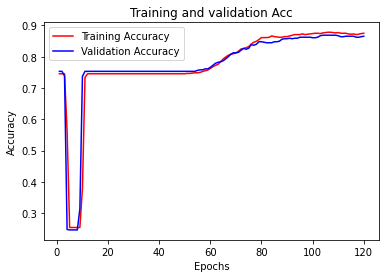

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy', c='r')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='b')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_23229/2382457563.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='Training Loss', c='r')
/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_23229/2382457563.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation Loss', c='b')


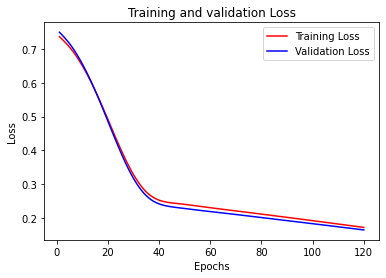

In [75]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss', c='r')
plt.plot(epochs, val_loss, 'b', label='Validation Loss', c='b')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

TRAINING:
               precision    recall  f1-score   support

  high-level       0.25      0.25      0.25       392
   low-level       0.75      0.75      0.75      1167

    accuracy                           0.63      1559
   macro avg       0.50      0.50      0.50      1559
weighted avg       0.62      0.63      0.63      1559

TEST:
               precision    recall  f1-score   support

  high-level       0.26      0.27      0.26       131
   low-level       0.75      0.74      0.75       389

    accuracy                           0.62       520
   macro avg       0.50      0.50      0.50       520
weighted avg       0.63      0.62      0.62       520



2022-01-05 12:23:38.962864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


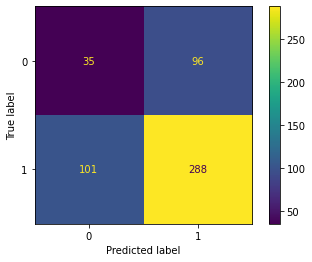

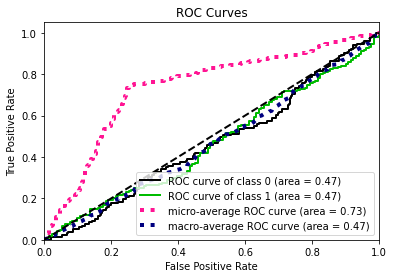

In [76]:
print_all(nn_grid,train_set_no,train_pred_nn,test_set_no,test_pred_nn)

## KNN

In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [69]:
train_set_no_cat = train_set.loc[:,~train_set.columns.str.contains('_num', case=False)] 
test_set_no_cat = test_set.loc[:,~test_set.columns.str.contains('_num', case=False)] 

k = math.sqrt(len(train_set))
k = round(k, 0)
k = int(k)
k = k - 10
k_range = []
for i in range(0,20):
    k_range.append(k)
    k = k + 1

In [70]:
knn_param_grid = {
    'n_neighbors': k_range,
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=8, scoring=make_scorer(f1_score))

In [71]:
knn_grid.fit(train_set_no_cat, train_label)

GridSearchCV(cv=8, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
                                         39, 40, 41, 42, 43, 44, 45, 46, 47,
                                         48],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score))

In [72]:
train_pred_knn = knn_grid.predict(train_set_no_cat)
test_pred_knn = knn_grid.predict(test_set_no_cat)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       1.00      1.00      1.00       392
   low-level       1.00      1.00      1.00      1167

    accuracy                           1.00      1559
   macro avg       1.00      1.00      1.00      1559
weighted avg       1.00      1.00      1.00      1559

TEST:
               precision    recall  f1-score   support

  high-level       0.90      0.72      0.80       131
   low-level       0.91      0.97      0.94       389

    accuracy                           0.91       520
   macro avg       0.91      0.85      0.87       520
weighted avg       0.91      0.91      0.91       520



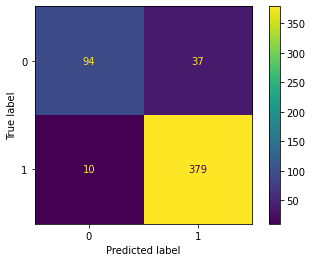


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [73]:
print_all(knn_grid,train_set_no_cat,train_pred_knn,test_set_no_cat,test_pred_knn,roc="None")

## Radius-Neighbors Classifier 

### Grid search

In [ ]:
from sklearn.neighbors import RadiusNeighborsClassifier
from scipy.stats import uniform
#radius = np.arange(1.0, 100000.0, 0.1)
radius = uniform(1.0, 10000000.0)
radius_param_grid = {
    'radius': radius,
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }

### Training

In [ ]:
radius_grid = RandomizedSearchCV(RadiusNeighborsClassifier(), radius_param_grid, n_jobs=-1, n_iter = 100, cv=8, scoring='accuracy')

radius_grid.fit(train_set_no_cat, train_label)

print('Accuracy: ' + str(radius_grid.best_score_))
print('Parameters: ' + str(radius_grid.best_params_))

In [ ]:
radius = RadiusNeighborsClassifier(**radius_grid.best_params_).fit(train_set_no_cat, train_label)

In [ ]:
train_pred_radius = radius.predict(train_set_no_cat)

In [ ]:
test_pred_radius = radius.predict(test_set_no_cat)

### Evaluation

In [ ]:
print_all(radius,train_set_no_cat,train_pred_radius,test_set_no_cat,test_pred_radius,roc="None")

## SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm_param_grid = {
    'C' : [0.5, 2.0],
    'kernel' : ['rbf', 'linear'] 
    }
svm_grid = GridSearchCV(SVC(probability=True), svm_param_grid, n_jobs=-1, cv=8, scoring=make_scorer(f1_score))

In [ ]:
svm_grid.fit(train_set, train_label)

In [ ]:
train_pred_svm = svm_grid.predict(train_set)
test_pred_svm = svm_grid.predict(test_set)

### Evaluation

In [ ]:
print_all(svm_grid,train_set,train_pred_svm,test_set,test_pred_svm)

## Rule Based Classifier

In [ ]:
import wittgenstein as lw
param_grid = {
    "prune_size": [0.1, 0.2, 0.5, 0.6], 
    "k": [1, 3, 7, 10]
}
rb_grid = GridSearchCV(lw.RIPPER(), param_grid=param_grid, n_jobs=10)

In [ ]:
rb_grid.fit(train_set, train_label)

In [ ]:
rb = rb_grid.best_estimator_
rb.out_model()

In [ ]:
train_pred_rb = rb_grid.predict(train_set)
test_pred_rb = rb_grid.predict(test_set)

### Evaluation

In [ ]:
print_all(rb_grid,train_set,train_pred_rb,test_set,test_pred_rb)

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.65, 1: 0.35}]}

rf_grid = RandomizedSearchCV(RandomForestClassifier(n_estimators=30), param_distributions=param_dist, 
                            n_iter=50, 
                            n_jobs=-1, 
                            scoring=make_scorer(accuracy_score))


In [ ]:
#run the grid search
rf_grid.fit(train_set, train_label)

In [ ]:
train_pred_rf = rf_grid.predict(train_set)
test_pred_rf = rf_grid.predict(test_set)

### Evaluation

In [ ]:
print_all(rf_grid,train_set,train_pred_rf,test_set,test_pred_rf)

## AdaBoosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
abc.fit(train_set, train_label)

In [ ]:
test_pred_abc = abc.predict(test_set)
train_pred_abc= abc.predict(train_set)

In [ ]:
print_all(abc,train_set,train_pred_abc,test_set,test_pred_abc)

## Global models evaluation

Compare results on test set of each model obtained with grid search

In [ ]:
df_blind_test = pd.DataFrame()
df_blind_test['DecisionTree'] = pd.Series(dt_grid.predict(blindtest))
df_blind_test['Bayesian'] = pd.Series(gnb.predict(blindtest))
#df_blind_test['NeuralNetwork'] = pd.Series(nn_grid.predict(blindtest))
#df_blind_test['KNN'] = pd.Series(knn_grid.predict(blindtest))
#df_blind_test['Radius-KNN'] = pd.Series(radius_grid.predict(blindtest))
df_blind_test['SVM'] = pd.Series(svm_grid.predict(blindtest))
df_blind_test['RuleBased'] = pd.Series(rb_grid.predict(blindtest))
df_blind_test['RandomForest'] = pd.Series(rf_grid.predict(blindtest))
df_blind_test['AdaBoosting'] = pd.Series(abc.predict(blindtest))
df_blind_test

In [ ]:
## aggiungi gli altri modelli sotto 

#decision tree 
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_dt)
auc = metrics.roc_auc_score(test_label, test_pred_dt)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

#bayesian classifier
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_gnb)
auc = metrics.roc_auc_score(test_label, test_pred_gnb)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

#neural network
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_nn)
auc = metrics.roc_auc_score(test_label, test_pred_nn)
plt.plot(fpr,tpr,label="NeuralNetwork, auc="+str(auc))

#KNN
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_knn)
auc = metrics.roc_auc_score(test_label, test_pred_knn)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))

#Radius-Neighbors
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_radius)
auc = metrics.roc_auc_score(test_label, test_pred_radius)
plt.plot(fpr,tpr,label="Radius-Neighbors, auc="+str(auc))

#SVM
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_svm)
auc = metrics.roc_auc_score(test_label, test_pred_svm)
plt.plot(fpr,tpr,label="SVM, auc="+str(auc))

#Rule Based Classifier
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rb)
auc = metrics.roc_auc_score(test_label, test_pred_rb)
plt.plot(fpr,tpr,label="RuleBasedClassifier, auc="+str(auc))

#RandomForest
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rf)
auc = metrics.roc_auc_score(test_label, test_pred_rf)
plt.plot(fpr,tpr,label="RandomForest, auc="+str(auc))

#AdaBoosting
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_abc)
auc = metrics.roc_auc_score(test_label, test_pred_abc)
plt.plot(fpr,tpr,label="AdaBoosting, auc="+str(auc))

plt.legend(loc=0)